## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


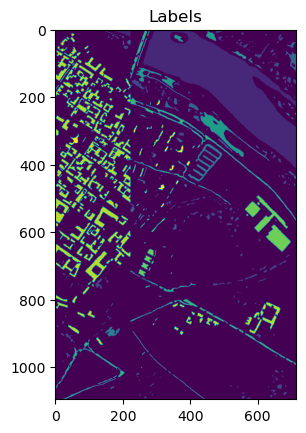

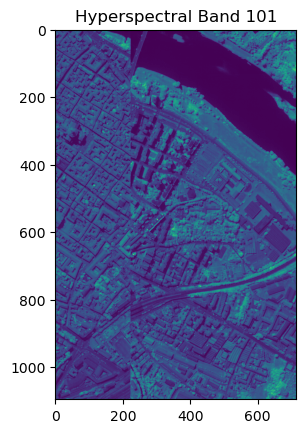

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 20 train


 -- Test set created with: 
	147927 samples
	shape (147927, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(180, 5, 5, 102)
(45, 5, 5, 102)
(147927, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1680, PSNR: 5.0003


	 Training Batch [200/1852], Loss: 0.0876, PSNR: 7.3061


	 Training Batch [400/1852], Loss: 0.0458, PSNR: 9.5537


	 Training Batch [600/1852], Loss: 0.0268, PSNR: 12.7667


	 Training Batch [800/1852], Loss: 0.0133, PSNR: 13.7657


	 Training Batch [1000/1852], Loss: 0.0105, PSNR: 16.7400


	 Training Batch [1200/1852], Loss: 0.0088, PSNR: 17.1551


	 Training Batch [1400/1852], Loss: 0.0093, PSNR: 17.8695


	 Training Batch [1600/1852], Loss: 0.0070, PSNR: 18.2600


	 Training Batch [1800/1852], Loss: 0.0060, PSNR: 18.8991


Epoch [1/50] Training Loss: 0.0319, PSNR: 13.7977
	[Val]   Batch [1/463] Loss: 0.0053, PSNR: 17.9460
	[Val]   Batch [10/463] Loss: 0.0050, PSNR: 19.0844
	[Val]   Batch [20/463] Loss: 0.0051, PSNR: 18.0742
	[Val]   Batch [30/463] Loss: 0.0060, PSNR: 18.6706
	[Val]   Batch [40/463] Loss: 0.0048, PSNR: 17.7412
	[Val]   Batch [50/463] Loss: 0.0051, PSNR: 17.9703
	[Val]   Batch [60/463] Loss: 0.0048, PSNR: 18.0208


	[Val]   Batch [70/463] Loss: 0.0068, PSNR: 18.3955
	[Val]   Batch [80/463] Loss: 0.0061, PSNR: 20.2882
	[Val]   Batch [90/463] Loss: 0.0059, PSNR: 19.3822
	[Val]   Batch [100/463] Loss: 0.0059, PSNR: 19.1141
	[Val]   Batch [110/463] Loss: 0.0069, PSNR: 18.5110
	[Val]   Batch [120/463] Loss: 0.0047, PSNR: 17.9973
	[Val]   Batch [130/463] Loss: 0.0055, PSNR: 19.4126


	[Val]   Batch [140/463] Loss: 0.0064, PSNR: 18.9716
	[Val]   Batch [150/463] Loss: 0.0073, PSNR: 19.0075
	[Val]   Batch [160/463] Loss: 0.0059, PSNR: 19.2486
	[Val]   Batch [170/463] Loss: 0.0075, PSNR: 18.2321
	[Val]   Batch [180/463] Loss: 0.0055, PSNR: 18.9905
	[Val]   Batch [190/463] Loss: 0.0060, PSNR: 19.3129
	[Val]   Batch [200/463] Loss: 0.0060, PSNR: 18.6903
	[Val]   Batch [210/463] Loss: 0.0058, PSNR: 18.3159


	[Val]   Batch [220/463] Loss: 0.0057, PSNR: 19.5335
	[Val]   Batch [230/463] Loss: 0.0067, PSNR: 19.3640
	[Val]   Batch [240/463] Loss: 0.0051, PSNR: 18.1365
	[Val]   Batch [250/463] Loss: 0.0066, PSNR: 17.3495
	[Val]   Batch [260/463] Loss: 0.0057, PSNR: 18.3498
	[Val]   Batch [270/463] Loss: 0.0044, PSNR: 17.4965
	[Val]   Batch [280/463] Loss: 0.0054, PSNR: 20.2273


	[Val]   Batch [290/463] Loss: 0.0059, PSNR: 17.2533
	[Val]   Batch [300/463] Loss: 0.0060, PSNR: 19.4761
	[Val]   Batch [310/463] Loss: 0.0056, PSNR: 19.3679
	[Val]   Batch [320/463] Loss: 0.0056, PSNR: 19.2454
	[Val]   Batch [330/463] Loss: 0.0065, PSNR: 18.6542
	[Val]   Batch [340/463] Loss: 0.0053, PSNR: 19.5840
	[Val]   Batch [350/463] Loss: 0.0070, PSNR: 19.5396


	[Val]   Batch [360/463] Loss: 0.0047, PSNR: 20.4355
	[Val]   Batch [370/463] Loss: 0.0069, PSNR: 18.5893
	[Val]   Batch [380/463] Loss: 0.0068, PSNR: 18.7316
	[Val]   Batch [390/463] Loss: 0.0062, PSNR: 18.5483
	[Val]   Batch [400/463] Loss: 0.0054, PSNR: 17.6174
	[Val]   Batch [410/463] Loss: 0.0054, PSNR: 19.9036
	[Val]   Batch [420/463] Loss: 0.0055, PSNR: 18.7071
	[Val]   Batch [430/463] Loss: 0.0054, PSNR: 18.1331


	[Val]   Batch [440/463] Loss: 0.0053, PSNR: 19.1201
	[Val]   Batch [450/463] Loss: 0.0042, PSNR: 16.4402
	[Val]   Batch [460/463] Loss: 0.0058, PSNR: 17.8569
Epoch [1/50] Validation Loss: 0.0058, PSNR: 18.6822

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0050, PSNR: 17.6622


	 Training Batch [200/1852], Loss: 0.0052, PSNR: 19.1065


	 Training Batch [400/1852], Loss: 0.0050, PSNR: 19.4474


	 Training Batch [600/1852], Loss: 0.0058, PSNR: 19.2607


	 Training Batch [800/1852], Loss: 0.0049, PSNR: 20.1003


	 Training Batch [1000/1852], Loss: 0.0040, PSNR: 20.6939


	 Training Batch [1200/1852], Loss: 0.0036, PSNR: 22.1705


	 Training Batch [1400/1852], Loss: 0.0050, PSNR: 20.7530


	 Training Batch [1600/1852], Loss: 0.0025, PSNR: 20.8615


	 Training Batch [1800/1852], Loss: 0.0033, PSNR: 21.6066


Epoch [2/50] Training Loss: 0.0042, PSNR: 20.2590
	[Val]   Batch [1/463] Loss: 0.0025, PSNR: 21.2523
	[Val]   Batch [10/463] Loss: 0.0023, PSNR: 22.5030
	[Val]   Batch [20/463] Loss: 0.0022, PSNR: 21.6057
	[Val]   Batch [30/463] Loss: 0.0029, PSNR: 21.9369
	[Val]   Batch [40/463] Loss: 0.0023, PSNR: 21.0060
	[Val]   Batch [50/463] Loss: 0.0024, PSNR: 21.2968
	[Val]   Batch [60/463] Loss: 0.0022, PSNR: 21.3497


	[Val]   Batch [70/463] Loss: 0.0033, PSNR: 21.5825
	[Val]   Batch [80/463] Loss: 0.0029, PSNR: 23.5165
	[Val]   Batch [90/463] Loss: 0.0027, PSNR: 22.6797
	[Val]   Batch [100/463] Loss: 0.0029, PSNR: 22.1985
	[Val]   Batch [110/463] Loss: 0.0033, PSNR: 21.7452
	[Val]   Batch [120/463] Loss: 0.0022, PSNR: 21.2589
	[Val]   Batch [130/463] Loss: 0.0025, PSNR: 22.8288


	[Val]   Batch [140/463] Loss: 0.0031, PSNR: 22.1445
	[Val]   Batch [150/463] Loss: 0.0033, PSNR: 22.3928
	[Val]   Batch [160/463] Loss: 0.0029, PSNR: 22.3072
	[Val]   Batch [170/463] Loss: 0.0037, PSNR: 21.3162
	[Val]   Batch [180/463] Loss: 0.0028, PSNR: 21.9786
	[Val]   Batch [190/463] Loss: 0.0027, PSNR: 22.7076
	[Val]   Batch [200/463] Loss: 0.0028, PSNR: 22.0184


	[Val]   Batch [210/463] Loss: 0.0029, PSNR: 21.2438
	[Val]   Batch [220/463] Loss: 0.0028, PSNR: 22.6327
	[Val]   Batch [230/463] Loss: 0.0031, PSNR: 22.7764
	[Val]   Batch [240/463] Loss: 0.0024, PSNR: 21.4248
	[Val]   Batch [250/463] Loss: 0.0032, PSNR: 20.4555
	[Val]   Batch [260/463] Loss: 0.0028, PSNR: 21.5094
	[Val]   Batch [270/463] Loss: 0.0020, PSNR: 20.9650


	[Val]   Batch [280/463] Loss: 0.0025, PSNR: 23.5145
	[Val]   Batch [290/463] Loss: 0.0028, PSNR: 20.5337
	[Val]   Batch [300/463] Loss: 0.0029, PSNR: 22.6991
	[Val]   Batch [310/463] Loss: 0.0028, PSNR: 22.3744
	[Val]   Batch [320/463] Loss: 0.0027, PSNR: 22.4326
	[Val]   Batch [330/463] Loss: 0.0030, PSNR: 22.0687
	[Val]   Batch [340/463] Loss: 0.0026, PSNR: 22.7984
	[Val]   Batch [350/463] Loss: 0.0035, PSNR: 22.5262


	[Val]   Batch [360/463] Loss: 0.0024, PSNR: 23.3358
	[Val]   Batch [370/463] Loss: 0.0032, PSNR: 21.8975
	[Val]   Batch [380/463] Loss: 0.0030, PSNR: 22.2515
	[Val]   Batch [390/463] Loss: 0.0028, PSNR: 21.9881
	[Val]   Batch [400/463] Loss: 0.0027, PSNR: 20.7286
	[Val]   Batch [410/463] Loss: 0.0025, PSNR: 23.2820
	[Val]   Batch [420/463] Loss: 0.0026, PSNR: 22.0739
	[Val]   Batch [430/463] Loss: 0.0027, PSNR: 21.2378


	[Val]   Batch [440/463] Loss: 0.0026, PSNR: 22.2055
	[Val]   Batch [450/463] Loss: 0.0020, PSNR: 19.6593
	[Val]   Batch [460/463] Loss: 0.0027, PSNR: 21.2236
Epoch [2/50] Validation Loss: 0.0027, PSNR: 21.9586

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0026, PSNR: 21.9067


	 Training Batch [200/1852], Loss: 0.0022, PSNR: 21.9711


	 Training Batch [400/1852], Loss: 0.0025, PSNR: 22.2282


	 Training Batch [600/1852], Loss: 0.0028, PSNR: 23.4674


	 Training Batch [800/1852], Loss: 0.0022, PSNR: 23.3246


	 Training Batch [1000/1852], Loss: 0.0022, PSNR: 23.8658


	 Training Batch [1200/1852], Loss: 0.0020, PSNR: 24.4720


	 Training Batch [1400/1852], Loss: 0.0021, PSNR: 23.9770


	 Training Batch [1600/1852], Loss: 0.0017, PSNR: 21.7709


	 Training Batch [1800/1852], Loss: 0.0017, PSNR: 22.3510


Epoch [3/50] Training Loss: 0.0023, PSNR: 22.7879
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.4572
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.7362
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 23.9042
	[Val]   Batch [30/463] Loss: 0.0016, PSNR: 24.3852
	[Val]   Batch [40/463] Loss: 0.0014, PSNR: 22.9842
	[Val]   Batch [50/463] Loss: 0.0015, PSNR: 23.3822
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.3693


	[Val]   Batch [70/463] Loss: 0.0018, PSNR: 24.0526
	[Val]   Batch [80/463] Loss: 0.0016, PSNR: 26.0245
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 24.9569
	[Val]   Batch [100/463] Loss: 0.0017, PSNR: 24.4915
	[Val]   Batch [110/463] Loss: 0.0018, PSNR: 24.2629
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.2584
	[Val]   Batch [130/463] Loss: 0.0014, PSNR: 25.3385


	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.5324
	[Val]   Batch [150/463] Loss: 0.0018, PSNR: 25.1900
	[Val]   Batch [160/463] Loss: 0.0018, PSNR: 24.3323
	[Val]   Batch [170/463] Loss: 0.0022, PSNR: 23.5775
	[Val]   Batch [180/463] Loss: 0.0017, PSNR: 24.0466
	[Val]   Batch [190/463] Loss: 0.0016, PSNR: 25.1066
	[Val]   Batch [200/463] Loss: 0.0016, PSNR: 24.5218
	[Val]   Batch [210/463] Loss: 0.0018, PSNR: 23.2588


	[Val]   Batch [220/463] Loss: 0.0017, PSNR: 24.7039
	[Val]   Batch [230/463] Loss: 0.0016, PSNR: 25.6647
	[Val]   Batch [240/463] Loss: 0.0014, PSNR: 23.6214
	[Val]   Batch [250/463] Loss: 0.0020, PSNR: 22.6025
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.6324
	[Val]   Batch [270/463] Loss: 0.0012, PSNR: 22.9838
	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.6942


	[Val]   Batch [290/463] Loss: 0.0016, PSNR: 22.8352
	[Val]   Batch [300/463] Loss: 0.0017, PSNR: 24.8763
	[Val]   Batch [310/463] Loss: 0.0018, PSNR: 24.2772
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.6713
	[Val]   Batch [330/463] Loss: 0.0017, PSNR: 24.6109
	[Val]   Batch [340/463] Loss: 0.0015, PSNR: 25.0155
	[Val]   Batch [350/463] Loss: 0.0021, PSNR: 24.8120


	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.8218
	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.4251
	[Val]   Batch [380/463] Loss: 0.0016, PSNR: 25.0793
	[Val]   Batch [390/463] Loss: 0.0015, PSNR: 24.6486
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.6515
	[Val]   Batch [410/463] Loss: 0.0014, PSNR: 25.6004
	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.4059


	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.1395
	[Val]   Batch [440/463] Loss: 0.0016, PSNR: 24.2333
	[Val]   Batch [450/463] Loss: 0.0013, PSNR: 21.3884
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.4637
Epoch [3/50] Validation Loss: 0.0016, PSNR: 24.2394

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0019, PSNR: 23.0092


	 Training Batch [200/1852], Loss: 0.0017, PSNR: 22.9308


	 Training Batch [400/1852], Loss: 0.0019, PSNR: 24.2156


	 Training Batch [600/1852], Loss: 0.0015, PSNR: 23.6540


	 Training Batch [800/1852], Loss: 0.0015, PSNR: 23.8802


	 Training Batch [1000/1852], Loss: 0.0018, PSNR: 24.9050


	 Training Batch [1200/1852], Loss: 0.0014, PSNR: 25.5243


	 Training Batch [1400/1852], Loss: 0.0013, PSNR: 25.4047


	 Training Batch [1600/1852], Loss: 0.0013, PSNR: 24.9424


	 Training Batch [1800/1852], Loss: 0.0012, PSNR: 25.7553


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.3489
	[Val]   Batch [1/463] Loss: 0.0012, PSNR: 24.5131
	[Val]   Batch [10/463] Loss: 0.0011, PSNR: 25.7816
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 24.9867
	[Val]   Batch [30/463] Loss: 0.0013, PSNR: 25.4645
	[Val]   Batch [40/463] Loss: 0.0012, PSNR: 23.9650
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.4487
	[Val]   Batch [60/463] Loss: 0.0011, PSNR: 24.3790


	[Val]   Batch [70/463] Loss: 0.0014, PSNR: 25.1719
	[Val]   Batch [80/463] Loss: 0.0012, PSNR: 27.2557
	[Val]   Batch [90/463] Loss: 0.0013, PSNR: 26.0501
	[Val]   Batch [100/463] Loss: 0.0013, PSNR: 25.6215
	[Val]   Batch [110/463] Loss: 0.0014, PSNR: 25.4519
	[Val]   Batch [120/463] Loss: 0.0011, PSNR: 24.3175
	[Val]   Batch [130/463] Loss: 0.0011, PSNR: 26.4774
	[Val]   Batch [140/463] Loss: 0.0014, PSNR: 25.6425


	[Val]   Batch [150/463] Loss: 0.0013, PSNR: 26.3735
	[Val]   Batch [160/463] Loss: 0.0015, PSNR: 25.3127
	[Val]   Batch [170/463] Loss: 0.0017, PSNR: 24.5825
	[Val]   Batch [180/463] Loss: 0.0014, PSNR: 25.0632
	[Val]   Batch [190/463] Loss: 0.0012, PSNR: 26.1703
	[Val]   Batch [200/463] Loss: 0.0012, PSNR: 25.7188
	[Val]   Batch [210/463] Loss: 0.0015, PSNR: 24.2522


	[Val]   Batch [220/463] Loss: 0.0014, PSNR: 25.7130
	[Val]   Batch [230/463] Loss: 0.0012, PSNR: 26.9189
	[Val]   Batch [240/463] Loss: 0.0011, PSNR: 24.7178
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.6277
	[Val]   Batch [260/463] Loss: 0.0014, PSNR: 24.6221
	[Val]   Batch [270/463] Loss: 0.0010, PSNR: 24.0654
	[Val]   Batch [280/463] Loss: 0.0012, PSNR: 26.7947


	[Val]   Batch [290/463] Loss: 0.0013, PSNR: 23.9522
	[Val]   Batch [300/463] Loss: 0.0014, PSNR: 25.8320
	[Val]   Batch [310/463] Loss: 0.0014, PSNR: 25.3044
	[Val]   Batch [320/463] Loss: 0.0012, PSNR: 25.8098
	[Val]   Batch [330/463] Loss: 0.0013, PSNR: 25.7238
	[Val]   Batch [340/463] Loss: 0.0012, PSNR: 26.1210
	[Val]   Batch [350/463] Loss: 0.0016, PSNR: 25.8700


	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.6463
	[Val]   Batch [370/463] Loss: 0.0014, PSNR: 25.5732
	[Val]   Batch [380/463] Loss: 0.0012, PSNR: 26.3078
	[Val]   Batch [390/463] Loss: 0.0012, PSNR: 25.8392
	[Val]   Batch [400/463] Loss: 0.0014, PSNR: 23.6529
	[Val]   Batch [410/463] Loss: 0.0011, PSNR: 26.6967
	[Val]   Batch [420/463] Loss: 0.0012, PSNR: 25.4582
	[Val]   Batch [430/463] Loss: 0.0014, PSNR: 24.0842


	[Val]   Batch [440/463] Loss: 0.0013, PSNR: 25.3441
	[Val]   Batch [450/463] Loss: 0.0011, PSNR: 22.4123
	[Val]   Batch [460/463] Loss: 0.0013, PSNR: 24.4899
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.3324

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0013, PSNR: 26.3142


	 Training Batch [200/1852], Loss: 0.0018, PSNR: 25.3656


	 Training Batch [400/1852], Loss: 0.0014, PSNR: 24.9616


	 Training Batch [600/1852], Loss: 0.0013, PSNR: 24.7566


	 Training Batch [800/1852], Loss: 0.0012, PSNR: 24.4685


	 Training Batch [1000/1852], Loss: 0.0011, PSNR: 24.7833


	 Training Batch [1200/1852], Loss: 0.0010, PSNR: 25.4281


	 Training Batch [1400/1852], Loss: 0.0010, PSNR: 27.2741


	 Training Batch [1600/1852], Loss: 0.0015, PSNR: 24.0375


	 Training Batch [1800/1852], Loss: 0.0010, PSNR: 25.2176


Epoch [5/50] Training Loss: 0.0013, PSNR: 25.3744
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.5103
	[Val]   Batch [10/463] Loss: 0.0009, PSNR: 26.8088
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.0037
	[Val]   Batch [30/463] Loss: 0.0010, PSNR: 26.5182
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 24.8583
	[Val]   Batch [50/463] Loss: 0.0009, PSNR: 25.4191
	[Val]   Batch [60/463] Loss: 0.0009, PSNR: 25.3008


	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.2387
	[Val]   Batch [80/463] Loss: 0.0009, PSNR: 28.5096
	[Val]   Batch [90/463] Loss: 0.0010, PSNR: 27.1737
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.6919
	[Val]   Batch [110/463] Loss: 0.0011, PSNR: 26.5938
	[Val]   Batch [120/463] Loss: 0.0009, PSNR: 25.3081


	[Val]   Batch [130/463] Loss: 0.0009, PSNR: 27.4923
	[Val]   Batch [140/463] Loss: 0.0011, PSNR: 26.7760
	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.5414
	[Val]   Batch [160/463] Loss: 0.0012, PSNR: 26.1976
	[Val]   Batch [170/463] Loss: 0.0014, PSNR: 25.5634
	[Val]   Batch [180/463] Loss: 0.0011, PSNR: 26.0637
	[Val]   Batch [190/463] Loss: 0.0010, PSNR: 27.1495
	[Val]   Batch [200/463] Loss: 0.0009, PSNR: 26.8461


	[Val]   Batch [210/463] Loss: 0.0012, PSNR: 25.2274
	[Val]   Batch [220/463] Loss: 0.0011, PSNR: 26.6881
	[Val]   Batch [230/463] Loss: 0.0009, PSNR: 28.1665
	[Val]   Batch [240/463] Loss: 0.0009, PSNR: 25.7967
	[Val]   Batch [250/463] Loss: 0.0013, PSNR: 24.5300
	[Val]   Batch [260/463] Loss: 0.0011, PSNR: 25.5238
	[Val]   Batch [270/463] Loss: 0.0008, PSNR: 25.1004


	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 27.8190
	[Val]   Batch [290/463] Loss: 0.0010, PSNR: 25.0283
	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 26.7299
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.2264
	[Val]   Batch [320/463] Loss: 0.0010, PSNR: 26.9065
	[Val]   Batch [330/463] Loss: 0.0010, PSNR: 26.8594
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.1590
	[Val]   Batch [350/463] Loss: 0.0013, PSNR: 26.9117


	[Val]   Batch [360/463] Loss: 0.0012, PSNR: 26.3340
	[Val]   Batch [370/463] Loss: 0.0011, PSNR: 26.7309
	[Val]   Batch [380/463] Loss: 0.0009, PSNR: 27.5408
	[Val]   Batch [390/463] Loss: 0.0009, PSNR: 27.0104
	[Val]   Batch [400/463] Loss: 0.0011, PSNR: 24.5706
	[Val]   Batch [410/463] Loss: 0.0009, PSNR: 27.7345
	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.4950


	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 24.8954
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.3394
	[Val]   Batch [450/463] Loss: 0.0009, PSNR: 23.2829
	[Val]   Batch [460/463] Loss: 0.0010, PSNR: 25.4230
Epoch [5/50] Validation Loss: 0.0010, PSNR: 26.3716

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0012, PSNR: 25.2958


	 Training Batch [200/1852], Loss: 0.0011, PSNR: 27.0299


	 Training Batch [400/1852], Loss: 0.0012, PSNR: 25.3465


	 Training Batch [600/1852], Loss: 0.0011, PSNR: 26.0319


	 Training Batch [800/1852], Loss: 0.0010, PSNR: 26.3584


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 26.2478


	 Training Batch [1200/1852], Loss: 0.0010, PSNR: 27.1874


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 26.0657


	 Training Batch [1600/1852], Loss: 0.0012, PSNR: 25.8289


	 Training Batch [1800/1852], Loss: 0.0010, PSNR: 25.4693


Epoch [6/50] Training Loss: 0.0011, PSNR: 26.1591
	[Val]   Batch [1/463] Loss: 0.0008, PSNR: 26.4646
	[Val]   Batch [10/463] Loss: 0.0007, PSNR: 27.7585
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.0268
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.4241
	[Val]   Batch [40/463] Loss: 0.0008, PSNR: 25.8145
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.4165
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.2245


	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.1446
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.5511
	[Val]   Batch [90/463] Loss: 0.0008, PSNR: 28.1040
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.6327
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.5895
	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 26.3154
	[Val]   Batch [130/463] Loss: 0.0007, PSNR: 28.4674
	[Val]   Batch [140/463] Loss: 0.0009, PSNR: 27.7375


	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.4940
	[Val]   Batch [160/463] Loss: 0.0010, PSNR: 27.0536
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.4084
	[Val]   Batch [180/463] Loss: 0.0009, PSNR: 27.0183
	[Val]   Batch [190/463] Loss: 0.0008, PSNR: 28.0620
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 27.8423
	[Val]   Batch [210/463] Loss: 0.0010, PSNR: 26.1340
	[Val]   Batch [220/463] Loss: 0.0009, PSNR: 27.5614


	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.1916
	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 26.7832
	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.4827
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.3602
	[Val]   Batch [270/463] Loss: 0.0006, PSNR: 26.2012
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 28.7981
	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.0134


	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.6035
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.1423
	[Val]   Batch [320/463] Loss: 0.0008, PSNR: 27.9589
	[Val]   Batch [330/463] Loss: 0.0008, PSNR: 27.8038
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.1516
	[Val]   Batch [350/463] Loss: 0.0011, PSNR: 27.7529
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.0602


	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.7406
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.5862
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.0228
	[Val]   Batch [400/463] Loss: 0.0009, PSNR: 25.4845
	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.6716
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.4825
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 25.8098


	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.2595
	[Val]   Batch [450/463] Loss: 0.0007, PSNR: 24.3191
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.3454
Epoch [6/50] Validation Loss: 0.0008, PSNR: 27.3378

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 27.2289


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 27.6464


	 Training Batch [400/1852], Loss: 0.0013, PSNR: 26.5508


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 27.1961


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 25.0003


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 27.3132


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 26.9003


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 27.8433


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 27.0773


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 26.5567


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.7943
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.2768
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.6726
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 27.9801
	[Val]   Batch [30/463] Loss: 0.0007, PSNR: 28.2316
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.6844
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.3242
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.0718


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 27.9688
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.5505
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 28.9921
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.5036
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.4674
	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 27.2180
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 29.3377
	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.6019


	[Val]   Batch [150/463] Loss: 0.0007, PSNR: 29.3781
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 27.8272
	[Val]   Batch [170/463] Loss: 0.0010, PSNR: 27.1179
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 27.9066
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.8942
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.8402
	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 26.9362


	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.3876
	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 30.1013
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.6809
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.2669
	[Val]   Batch [260/463] Loss: 0.0008, PSNR: 27.1226
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 27.2449
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.6753
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 26.9025


	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.3620
	[Val]   Batch [310/463] Loss: 0.0008, PSNR: 27.9782
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 28.8985
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 28.6948
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.0612
	[Val]   Batch [350/463] Loss: 0.0009, PSNR: 28.5397
	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.6737


	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.5674
	[Val]   Batch [380/463] Loss: 0.0006, PSNR: 29.5705
	[Val]   Batch [390/463] Loss: 0.0006, PSNR: 28.9881
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.2519
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.5322
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.3441
	[Val]   Batch [430/463] Loss: 0.0008, PSNR: 26.6096
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.0500


	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.2482
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 27.1287
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.2207

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 27.3638


	 Training Batch [200/1852], Loss: 0.0011, PSNR: 26.1699


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.5532


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 27.4327


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 27.8092


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 26.7963


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 26.5408


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 29.1566


	 Training Batch [1600/1852], Loss: 0.0009, PSNR: 27.3900


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 27.1127


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.3984
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.0610
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 29.4954
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.8138
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 29.0429
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.4205
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.1240
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.8295


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.7794
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 31.4628
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 29.8213
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 29.3239
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 29.3330
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.9960
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 30.1228
	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.4542


	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.2815
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.5316
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 27.8586
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.7009
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.6398
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.6584
	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.6964


	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.1689
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.9843
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.4812
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.0041
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 27.8452
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.0855


	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.4846
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.7818
	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 29.0339
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 28.7225
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.7842
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.5842
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 29.8976
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.2892


	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.1803
	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.4462
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.5266
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.8710
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 26.9719
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.3158
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.1732


	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 27.3351
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.8449
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 26.0860
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.8667
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.0358

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0009, PSNR: 28.4544


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 26.3724


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.2967


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.7855


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 29.7103


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 27.5739


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 27.6405


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 27.9781


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 29.2160


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.8916


Epoch [9/50] Training Loss: 0.0007, PSNR: 27.8827
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.6344
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.1003
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.4382
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.6114
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.9465
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.7910
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.3795


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.3695
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.0934
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.4131
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.9421
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.9329
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.5897


	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.7266
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.0158
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.9211
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.0543
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.4243
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.2486
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.2264
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.2962
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.2301


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.7168
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.6049
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.1167
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.5646
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.3783
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.6927
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.1247


	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.3852
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.5219
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.2680
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.4224
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 30.2303
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.4623
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.8059


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.5459
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.0361
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.2030
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.4555
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.5092
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 30.8859
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.7547
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.9070


	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.3832
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.6750
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.4399
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.6300

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0009, PSNR: 27.0301


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.7793


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 30.7309


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 27.2795


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 27.4714


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.9376


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 28.7807


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 26.6511


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.0991


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.2370


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.3006
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.0036
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.6319
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.8548
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.0620
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.3926
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.2918
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.8718


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.7949
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.5684
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.8234
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.3851
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.3649
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.0527
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.1025
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.4600


	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.2958
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.5689
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.7788
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.7362
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.6786
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.7521
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.7917


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.1442
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.9038
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.6448
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 28.0508
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.8727
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.2943
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.5463


	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.8334
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 29.9226
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.8149
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.9261
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.6741
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.9646
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.2549


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.9175
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.3473
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.5939
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.8605
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.9715
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.3021
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.2331


	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.3801
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.7921
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.1745
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.8296
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.0831

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 27.5992


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.0573


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 29.1651


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 29.6801


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 26.4614


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.5100


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.8687


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 27.1067


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 28.1985


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.8373


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.7060
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.5504
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.1597
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.3729
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.6096
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.8911
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.8541
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.3747


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.3304
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.1953
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.4102
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.9423
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.9616
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.4922
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.6877
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.0275


	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 32.0005
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.0449
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.3582
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.2783
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.0858
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.2775
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.3166


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.5785
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.5774
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.1658
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.6191
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.3747
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.7066
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 32.0525
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.4609


	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.3520
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.2380
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.4959
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.2447
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.4810
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.8438
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.2199


	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.0289
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.2998
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.4348
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.4469
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.7361
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.7461
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.8803
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.2789


	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.6062
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.3869
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.6237

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 27.9661


	 Training Batch [200/1852], Loss: 0.0009, PSNR: 27.6308


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 30.2992


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 28.9300


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.1139


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.7482


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 27.8700


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.4584


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 30.0854


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 28.6052


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.0159
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.7724
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.3789
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.6151
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.8200
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 29.1413
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.2143


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.6609
	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.6233
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.4953
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.6783
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.2822
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.2351
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.6674
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.9391


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.2388
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.3482
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.3907
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.6172
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.5463
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.3456
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.6256
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.6201


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.7705
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.7377
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.4511
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.9506
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.7269
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 29.9632
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.3399


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.7087
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.6125
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.5871
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.8078
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.5533
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.7724
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.1017


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3966
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.2433
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.6452
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.6600
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.6855
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.9563
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.0077


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.1254
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.4933
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.8316
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.6949
Epoch [12/50] Validation Loss: 0.0003, PSNR: 30.9001

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 30.0867


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.2149


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 27.7033


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.0068


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 29.6375


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 29.4841


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 28.4026


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 30.4893


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 29.0631


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 28.2029


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.2993
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.2061
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.8718
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 31.0795
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.3570
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.5803
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.6474
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.1144


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.1426
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.9656
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.1413
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.7266
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.7650
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.1199
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.4682


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.7739
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.9154
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.9096
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.1494
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.0739
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.7238
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.0636
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.2442


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.2127
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.3118
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.9998
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.4530
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.2890
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.4049
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.7366


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.2430
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.0286
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.0532
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.2920
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.9937
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.2934
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.6521
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.6938


	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.8109
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.1047
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.1179
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.1388
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.3619
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.4864


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.6236
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.9412
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.3196
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.1939
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.3874

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 30.7358


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 29.7972


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 31.8614


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.3222


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 30.2650


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.0113


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.8670


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 31.0300


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 28.7409


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 28.9119


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.5596
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.4326
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.1300
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.3282
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.6507
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.8211
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.9549
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.3988


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.4613
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.2329
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.4220
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.0796
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.1164
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.3515
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.6808
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 32.0229


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.2820
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.2644
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.4721
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.3329
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.9563
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.3139
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.5770
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.4300


	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.5737
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.2489
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.7101
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.6651
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.6746
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.9808
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.5186


	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.3014
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.3905
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.5225
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.3017
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.5331
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.9065
	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.8497


	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.0405
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.4624
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.3791
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.4228
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.5928
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.6829
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.8861
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.1834
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.5606


	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.4945
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.6552

LOG: Epoch [15/50]
	 Training Batch [1/1852], Loss: 0.0010, PSNR: 27.2665


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 29.8911


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 30.5400


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 28.3628


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.1495


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.4938


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.7754


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 29.9113


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 29.0063


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 29.3449


Epoch [15/50] Training Loss: 0.0005, PSNR: 29.8171
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.7141
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.4282
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.5891
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 32.0028
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 30.1042
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.2835
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.7460


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.8708
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.5514
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.7416
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.3711
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.4464
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.6497
	[Val]   Batch [130/463] Loss: 0.0002, PSNR: 32.9879
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 32.3599
	[Val]   Batch [150/463] Loss: 0.0002, PSNR: 33.6844


	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.7299
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.8753
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.6512
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.2326
	[Val]   Batch [200/463] Loss: 0.0002, PSNR: 32.6124
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.9995
	[Val]   Batch [220/463] Loss: 0.0003, PSNR: 31.7590
	[Val]   Batch [230/463] Loss: 0.0002, PSNR: 33.9001


	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.5699
	[Val]   Batch [250/463] Loss: 0.0003, PSNR: 30.0812
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.1343
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.9673
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 33.2494
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.8994
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.6562


	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.7349
	[Val]   Batch [320/463] Loss: 0.0002, PSNR: 32.8072
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.5911
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.8612
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.3376
	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 30.0331
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.4205


	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.7686
	[Val]   Batch [390/463] Loss: 0.0002, PSNR: 32.6653
	[Val]   Batch [400/463] Loss: 0.0003, PSNR: 29.7348
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.7828
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 32.0271
	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.1983
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.5312


	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 28.9670
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.9111
Epoch [15/50] Validation Loss: 0.0003, PSNR: 31.9930

LOG: Epoch [16/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.9432


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 29.7377


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 29.8726


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 30.4541


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 30.2250


	 Training Batch [1000/1852], Loss: 0.0003, PSNR: 29.9539


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.5967


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 30.7892


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 30.2951


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 28.2781


Epoch [16/50] Training Loss: 0.0004, PSNR: 30.0276
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.8772
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.5759
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.6743
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 32.1096
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 30.2237
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.4759
	[Val]   Batch [60/463] Loss: 0.0002, PSNR: 30.9032


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 32.0533
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.7147
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.8752
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.5526
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.6015
	[Val]   Batch [120/463] Loss: 0.0002, PSNR: 30.7860
	[Val]   Batch [130/463] Loss: 0.0002, PSNR: 33.2237
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 32.4875


	[Val]   Batch [150/463] Loss: 0.0002, PSNR: 33.8914
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 32.0026
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 31.0967
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.8132
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.3401
	[Val]   Batch [200/463] Loss: 0.0002, PSNR: 32.7210


	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 31.2253
	[Val]   Batch [220/463] Loss: 0.0003, PSNR: 31.8423
	[Val]   Batch [230/463] Loss: 0.0002, PSNR: 34.0600
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.7657
	[Val]   Batch [250/463] Loss: 0.0003, PSNR: 30.2334
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.4195
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 31.1547


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 33.3824
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 31.0025
	[Val]   Batch [300/463] Loss: 0.0003, PSNR: 31.8836
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.8871
	[Val]   Batch [320/463] Loss: 0.0002, PSNR: 33.0083
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.7054
	[Val]   Batch [340/463] Loss: 0.0002, PSNR: 33.0437
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.5255


	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 30.1244
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.5762
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.8670
	[Val]   Batch [390/463] Loss: 0.0002, PSNR: 32.6993
	[Val]   Batch [400/463] Loss: 0.0003, PSNR: 29.8666
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.9026
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 32.1622


	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.3734
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.6805
	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 29.1115
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 31.1478
Epoch [16/50] Validation Loss: 0.0003, PSNR: 32.1439
Early stopping triggered at epoch 16. No improvement for 3 epochs.


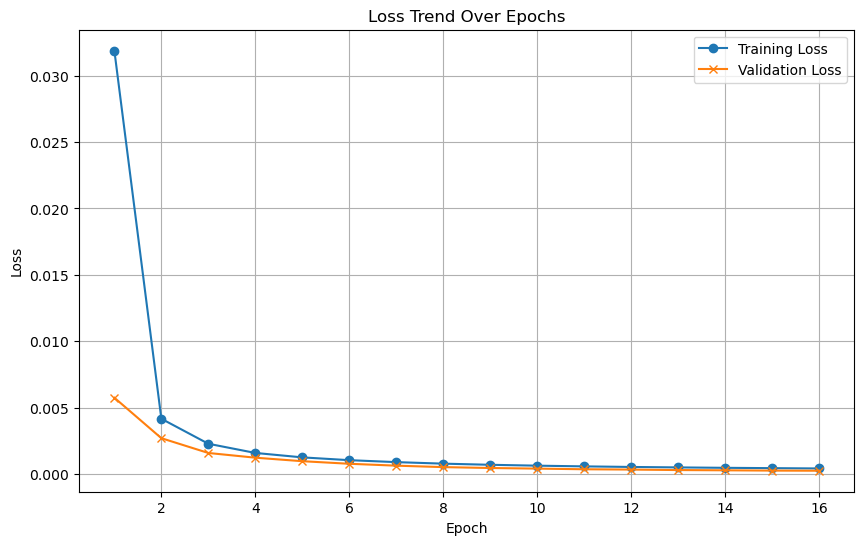

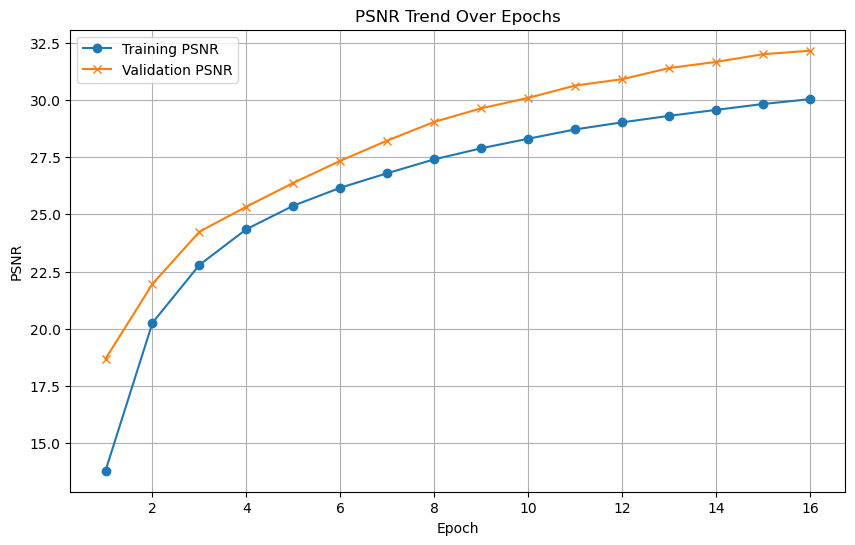

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/578 for test dataset.


    Processed batch 101/578 for test dataset.


    Processed batch 201/578 for test dataset.


    Processed batch 301/578 for test dataset.


    Processed batch 401/578 for test dataset.


    Processed batch 501/578 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1983
    Validation Batch [1/1], Loss: 2.2004
Validation Loss: 2.2004, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2004. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1509
    Validation Batch [1/1], Loss: 2.2003
Validation Loss: 2.2003, Validation Accuracy: 11.11%
Validation loss improved from 2.2004 to 2.2003. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1170
    Validation Batch [1/1], Loss: 2.2003
Validation Loss: 2.2003, Validation Accuracy: 11.11%
Validation loss improved from 2.2003 to 2.2003. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0909
    Validation Batch [1/1], Loss: 2.2002
Validation Loss: 2.2002, Validation Accuracy: 13.33%
Validation loss improved from 2.2003 to 2.2002. Saving model...

LOG: Epoch [5/1000

Epoch [8/1000] completed, Average Training Loss: 1.9784
    Validation Batch [1/1], Loss: 2.2000
Validation Loss: 2.2000, Validation Accuracy: 11.11%
Validation loss improved from 2.2000 to 2.2000. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 1.9957
    Validation Batch [1/1], Loss: 2.1999
Validation Loss: 2.1999, Validation Accuracy: 11.11%
Validation loss improved from 2.2000 to 2.1999. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 1.9623
    Validation Batch [1/1], Loss: 2.1997
Validation Loss: 2.1997, Validation Accuracy: 11.11%
Validation loss improved from 2.1999 to 2.1997. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 1.9548
    Validation Batch [1/1], Loss: 2.1994
Validation Loss: 2.1994, Validation Accuracy: 11.11%
Validation loss improved from 2.1997 to 2.1994. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1

    Validation Batch [1/1], Loss: 2.1073
Validation Loss: 2.1073, Validation Accuracy: 31.11%
Validation loss improved from 2.1203 to 2.1073. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 1.6291
    Validation Batch [1/1], Loss: 2.0918
Validation Loss: 2.0918, Validation Accuracy: 31.11%
Validation loss improved from 2.1073 to 2.0918. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 1.6393
    Validation Batch [1/1], Loss: 2.0743
Validation Loss: 2.0743, Validation Accuracy: 33.33%
Validation loss improved from 2.0918 to 2.0743. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.6363
    Validation Batch [1/1], Loss: 2.0559
Validation Loss: 2.0559, Validation Accuracy: 42.22%
Validation loss improved from 2.0743 to 2.0559. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.6016
    Vali

Epoch [66/1000] completed, Average Training Loss: 1.3285
    Validation Batch [1/1], Loss: 1.4261
Validation Loss: 1.4261, Validation Accuracy: 91.11%
Validation loss improved from 1.4420 to 1.4261. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 1.3717
    Validation Batch [1/1], Loss: 1.4069
Validation Loss: 1.4069, Validation Accuracy: 93.33%
Validation loss improved from 1.4261 to 1.4069. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.3172
    Validation Batch [1/1], Loss: 1.3898
Validation Loss: 1.3898, Validation Accuracy: 95.56%
Validation loss improved from 1.4069 to 1.3898. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.3139
    Validation Batch [1/1], Loss: 1.3757
Validation Loss: 1.3757, Validation Accuracy: 93.33%
Validation loss improved from 1.3898 to 1.3757. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [7

Epoch [93/1000] completed, Average Training Loss: 1.1312
    Validation Batch [1/1], Loss: 1.1333
Validation Loss: 1.1333, Validation Accuracy: 97.78%
Validation loss improved from 1.1505 to 1.1333. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.1308
    Validation Batch [1/1], Loss: 1.1107
Validation Loss: 1.1107, Validation Accuracy: 97.78%
Validation loss improved from 1.1333 to 1.1107. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.0992
    Validation Batch [1/1], Loss: 1.1094
Validation Loss: 1.1094, Validation Accuracy: 93.33%
Validation loss improved from 1.1107 to 1.1094. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.1064
    Validation Batch [1/1], Loss: 1.1042
Validation Loss: 1.1042, Validation Accuracy: 95.56%
Validation loss improved from 1.1094 to 1.1042. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [9

    Validation Batch [1/1], Loss: 0.9139
Validation Loss: 0.9139, Validation Accuracy: 95.56%
Validation loss improved from 0.9253 to 0.9139. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 0.9031
    Validation Batch [1/1], Loss: 0.9022
Validation Loss: 0.9022, Validation Accuracy: 95.56%
Validation loss improved from 0.9139 to 0.9022. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 0.8917
    Validation Batch [1/1], Loss: 0.8945
Validation Loss: 0.8945, Validation Accuracy: 95.56%
Validation loss improved from 0.9022 to 0.8945. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.8770
    Validation Batch [1/1], Loss: 0.8895
Validation Loss: 0.8895, Validation Accuracy: 95.56%
Validation loss improved from 0.8945 to 0.8895. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 0.8702


Epoch [150/1000] completed, Average Training Loss: 0.7004
    Validation Batch [1/1], Loss: 0.6883
Validation Loss: 0.6883, Validation Accuracy: 95.56%
Validation loss improved from 0.6914 to 0.6883. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 0.6788
    Validation Batch [1/1], Loss: 0.6846
Validation Loss: 0.6846, Validation Accuracy: 95.56%
Validation loss improved from 0.6883 to 0.6846. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.6886
    Validation Batch [1/1], Loss: 0.6791
Validation Loss: 0.6791, Validation Accuracy: 97.78%
Validation loss improved from 0.6846 to 0.6791. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.6835
    Validation Batch [1/1], Loss: 0.6629
Validation Loss: 0.6629, Validation Accuracy: 95.56%
Validation loss improved from 0.6791 to 0.6629. Saving model...

LOG: Epoch [154/1000] - Training


Epoch [179/1000] completed, Average Training Loss: 0.4990
    Validation Batch [1/1], Loss: 0.5073
Validation Loss: 0.5073, Validation Accuracy: 95.56%
Validation loss improved from 0.5101 to 0.5073. Saving model...

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 0.5121
    Validation Batch [1/1], Loss: 0.4966
Validation Loss: 0.4966, Validation Accuracy: 95.56%
Validation loss improved from 0.5073 to 0.4966. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 0.5047
    Validation Batch [1/1], Loss: 0.4893
Validation Loss: 0.4893, Validation Accuracy: 97.78%
Validation loss improved from 0.4966 to 0.4893. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 0.4973
    Validation Batch [1/1], Loss: 0.4837
Validation Loss: 0.4837, Validation Accuracy: 97.78%
Validation loss improved from 0.4893 to 0.4837. Saving model...

LOG: Epoch [183/1000] - Training


Epoch [209/1000] completed, Average Training Loss: 0.3589
    Validation Batch [1/1], Loss: 0.3544
Validation Loss: 0.3544, Validation Accuracy: 97.78%
Validation loss improved from 0.3691 to 0.3544. Saving model...

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.3656
    Validation Batch [1/1], Loss: 0.3558
Validation Loss: 0.3558, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.3542
    Validation Batch [1/1], Loss: 0.3572
Validation Loss: 0.3572, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.3654
    Validation Batch [1/1], Loss: 0.3580
Validation Loss: 0.3580, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training 

Epoch [238/1000] completed, Average Training Loss: 0.2598
    Validation Batch [1/1], Loss: 0.2539
Validation Loss: 0.2539, Validation Accuracy: 100.00%
Validation loss improved from 0.2648 to 0.2539. Saving model...

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.2671
    Validation Batch [1/1], Loss: 0.2541
Validation Loss: 0.2541, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.2756
    Validation Batch [1/1], Loss: 0.2708
Validation Loss: 0.2708, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.2641
    Validation Batch [1/1], Loss: 0.2766
Validation Loss: 0.2766, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Trainin

    Validation Batch [1/1], Loss: 0.2078
Validation Loss: 0.2078, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.2073
    Validation Batch [1/1], Loss: 0.2094
Validation Loss: 0.2094, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.1993
    Validation Batch [1/1], Loss: 0.1872
Validation Loss: 0.1872, Validation Accuracy: 97.78%
Validation loss improved from 0.2030 to 0.1872. Saving model...

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.1862
    Validation Batch [1/1], Loss: 0.1996
Validation Loss: 0.1996, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.1920
    Validation Batch [1/1], Loss: 0.1903
Vali

Epoch [298/1000] completed, Average Training Loss: 0.1496
    Validation Batch [1/1], Loss: 0.1619
Validation Loss: 0.1619, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.1386
    Validation Batch [1/1], Loss: 0.1616
Validation Loss: 0.1616, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.1467
    Validation Batch [1/1], Loss: 0.1676
Validation Loss: 0.1676, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.1645
    Validation Batch [1/1], Loss: 0.1655
Validation Loss: 0.1655, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.1369
  

    Validation Batch [1/1], Loss: 0.1401
Validation Loss: 0.1401, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.1134
    Validation Batch [1/1], Loss: 0.1226
Validation Loss: 0.1226, Validation Accuracy: 97.78%
Validation loss improved from 0.1285 to 0.1226. Saving model...

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.1174
    Validation Batch [1/1], Loss: 0.1261
Validation Loss: 0.1261, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.1220
    Validation Batch [1/1], Loss: 0.1290
Validation Loss: 0.1290, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.1057
    Validation Batch [1/1], Loss: 0.1542
Val

Epoch [354/1000] completed, Average Training Loss: 0.0965
    Validation Batch [1/1], Loss: 0.1073
Validation Loss: 0.1073, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.0822
    Validation Batch [1/1], Loss: 0.0945
Validation Loss: 0.0945, Validation Accuracy: 100.00%
Validation loss improved from 0.0968 to 0.0945. Saving model...

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.0885
    Validation Batch [1/1], Loss: 0.1213
Validation Loss: 0.1213, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.1000
    Validation Batch [1/1], Loss: 0.1284
Validation Loss: 0.1284, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Trainin

Epoch [382/1000] completed, Average Training Loss: 0.0956
    Validation Batch [1/1], Loss: 0.1001
Validation Loss: 0.1001, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.0753
    Validation Batch [1/1], Loss: 0.1177
Validation Loss: 0.1177, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.0781
    Validation Batch [1/1], Loss: 0.1453
Validation Loss: 0.1453, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.0823
    Validation Batch [1/1], Loss: 0.1574
Validation Loss: 0.1574, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.0864
  

Epoch [413/1000] completed, Average Training Loss: 0.0616
    Validation Batch [1/1], Loss: 0.0889
Validation Loss: 0.0889, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.0571
    Validation Batch [1/1], Loss: 0.0881
Validation Loss: 0.0881, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.0614
    Validation Batch [1/1], Loss: 0.0809
Validation Loss: 0.0809, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.0686
    Validation Batch [1/1], Loss: 0.0798
Validation Loss: 0.0798, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.070

Epoch [442/1000] completed, Average Training Loss: 0.0480
    Validation Batch [1/1], Loss: 0.1169
Validation Loss: 0.1169, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.0558
    Validation Batch [1/1], Loss: 0.0740
Validation Loss: 0.0740, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.0527
    Validation Batch [1/1], Loss: 0.0646
Validation Loss: 0.0646, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.0628
    Validation Batch [1/1], Loss: 0.0577
Validation Loss: 0.0577, Validation Accuracy: 100.00%
Validation loss improved from 0.0623 to 0.0577. Saving model...

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Train

Epoch [470/1000] completed, Average Training Loss: 0.0470
    Validation Batch [1/1], Loss: 0.0804
Validation Loss: 0.0804, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.0869
Validation Loss: 0.0869, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.0374
    Validation Batch [1/1], Loss: 0.0839
Validation Loss: 0.0839, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.0566
    Validation Batch [1/1], Loss: 0.0756
Validation Loss: 0.0756, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.047

Epoch [500/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.0644
Validation Loss: 0.0644, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.0669
Validation Loss: 0.0669, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0475
    Validation Batch [1/1], Loss: 0.0749
Validation Loss: 0.0749, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0451
    Validation Batch [1/1], Loss: 0.0789
Validation Loss: 0.0789, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.045

Epoch [531/1000] completed, Average Training Loss: 0.0368
    Validation Batch [1/1], Loss: 0.0715
Validation Loss: 0.0715, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0338
    Validation Batch [1/1], Loss: 0.0679
Validation Loss: 0.0679, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0364
    Validation Batch [1/1], Loss: 0.0635
Validation Loss: 0.0635, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.0613
Validation Loss: 0.0613, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.035

Epoch [562/1000] completed, Average Training Loss: 0.0338
    Validation Batch [1/1], Loss: 0.0518
Validation Loss: 0.0518, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.0355
    Validation Batch [1/1], Loss: 0.0375
Validation Loss: 0.0375, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.0325
    Validation Batch [1/1], Loss: 0.0303
Validation Loss: 0.0303, Validation Accuracy: 100.00%
Validation loss improved from 0.0339 to 0.0303. Saving model...

LOG: Epoch [565/1000] - Training
Epoch [565/1000] completed, Average Training Loss: 0.0346
    Validation Batch [1/1], Loss: 0.0283
Validation Loss: 0.0283, Validation Accuracy: 100.00%
Validation loss improved from 0.0303 to 0.0283. Saving model...

LOG: Epoch [566/1000] - Training
Epoch [566/1000] complete

Epoch [592/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.0391
Validation Loss: 0.0391, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.0323
Validation Loss: 0.0323, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0280
    Validation Batch [1/1], Loss: 0.0302
Validation Loss: 0.0302, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.0262
    Validation Batch [1/1], Loss: 0.0323
Validation Loss: 0.0323, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0

    Validation Batch [1/1], Loss: 0.0523
Validation Loss: 0.0523, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.0219
    Validation Batch [1/1], Loss: 0.0615
Validation Loss: 0.0615, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.0757
Validation Loss: 0.0757, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0276
    Validation Batch [1/1], Loss: 0.0841
Validation Loss: 0.0841, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0.0304
    Validation Batch [1/1], Loss: 0.0933
Validation Loss

    Validation Batch [1/1], Loss: 0.0264
Validation Loss: 0.0264, Validation Accuracy: 100.00%
Validation loss improved from 0.0275 to 0.0264. Saving model...

LOG: Epoch [651/1000] - Training
Epoch [651/1000] completed, Average Training Loss: 0.0264
    Validation Batch [1/1], Loss: 0.0300
Validation Loss: 0.0300, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [652/1000] - Training
Epoch [652/1000] completed, Average Training Loss: 0.0202
    Validation Batch [1/1], Loss: 0.0386
Validation Loss: 0.0386, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [653/1000] - Training
Epoch [653/1000] completed, Average Training Loss: 0.0177
    Validation Batch [1/1], Loss: 0.0579
Validation Loss: 0.0579, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [654/1000] - Training
Epoch [654/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.0723
Va

Epoch [680/1000] completed, Average Training Loss: 0.0208
    Validation Batch [1/1], Loss: 0.1109
Validation Loss: 0.1109, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [681/1000] - Training
Epoch [681/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.1046
Validation Loss: 0.1046, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [682/1000] - Training
Epoch [682/1000] completed, Average Training Loss: 0.0225
    Validation Batch [1/1], Loss: 0.0879
Validation Loss: 0.0879, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [683/1000] - Training
Epoch [683/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.0551
Validation Loss: 0.0551, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [684/1000] - Training
Epoch [684/1000] completed, Average Training Loss: 0.0206
  

    Validation Batch [1/1], Loss: 0.0326
Validation Loss: 0.0326, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [711/1000] - Training
Epoch [711/1000] completed, Average Training Loss: 0.0176
    Validation Batch [1/1], Loss: 0.0349
Validation Loss: 0.0349, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [712/1000] - Training
Epoch [712/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.0422
Validation Loss: 0.0422, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [713/1000] - Training
Epoch [713/1000] completed, Average Training Loss: 0.0247
    Validation Batch [1/1], Loss: 0.0487
Validation Loss: 0.0487, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [714/1000] - Training
Epoch [714/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.0574
Validation Loss

Epoch [739/1000] completed, Average Training Loss: 0.0142
    Validation Batch [1/1], Loss: 0.0717
Validation Loss: 0.0717, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [740/1000] - Training
Epoch [740/1000] completed, Average Training Loss: 0.0170
    Validation Batch [1/1], Loss: 0.0577
Validation Loss: 0.0577, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [741/1000] - Training
Epoch [741/1000] completed, Average Training Loss: 0.0161
    Validation Batch [1/1], Loss: 0.0575
Validation Loss: 0.0575, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [742/1000] - Training
Epoch [742/1000] completed, Average Training Loss: 0.0147
    Validation Batch [1/1], Loss: 0.0635
Validation Loss: 0.0635, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [743/1000] - Training
Epoch [743/1000] completed, Average Training Loss: 0.021

Epoch [768/1000] completed, Average Training Loss: 0.0160
    Validation Batch [1/1], Loss: 0.1006
Validation Loss: 0.1006, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [769/1000] - Training
Epoch [769/1000] completed, Average Training Loss: 0.0152
    Validation Batch [1/1], Loss: 0.0685
Validation Loss: 0.0685, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [770/1000] - Training
Epoch [770/1000] completed, Average Training Loss: 0.0143
    Validation Batch [1/1], Loss: 0.0546
Validation Loss: 0.0546, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [771/1000] - Training
Epoch [771/1000] completed, Average Training Loss: 0.0154
    Validation Batch [1/1], Loss: 0.0470
Validation Loss: 0.0470, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [772/1000] - Training
Epoch [772/1000] completed, Average Training Loss: 0.013

    Validation Batch [1/1], Loss: 0.0329
Validation Loss: 0.0329, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [796/1000] - Training
Epoch [796/1000] completed, Average Training Loss: 0.0166
    Validation Batch [1/1], Loss: 0.0315
Validation Loss: 0.0315, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [797/1000] - Training
Epoch [797/1000] completed, Average Training Loss: 0.0167
    Validation Batch [1/1], Loss: 0.0329
Validation Loss: 0.0329, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [798/1000] - Training
Epoch [798/1000] completed, Average Training Loss: 0.0218
    Validation Batch [1/1], Loss: 0.0378
Validation Loss: 0.0378, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [799/1000] - Training
Epoch [799/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.0376
Validation Loss

    Validation Batch [1/1], Loss: 0.0392
Validation Loss: 0.0392, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [824/1000] - Training
Epoch [824/1000] completed, Average Training Loss: 0.0136
    Validation Batch [1/1], Loss: 0.0479
Validation Loss: 0.0479, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [825/1000] - Training
Epoch [825/1000] completed, Average Training Loss: 0.0159
    Validation Batch [1/1], Loss: 0.0541
Validation Loss: 0.0541, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [826/1000] - Training
Epoch [826/1000] completed, Average Training Loss: 0.0114
    Validation Batch [1/1], Loss: 0.0623
Validation Loss: 0.0623, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [827/1000] - Training
Epoch [827/1000] completed, Average Training Loss: 0.0152
    Validation Batch [1/1], Loss: 0.0724
Validation Loss

Epoch [852/1000] completed, Average Training Loss: 0.0150
    Validation Batch [1/1], Loss: 0.0379
Validation Loss: 0.0379, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [853/1000] - Training
Epoch [853/1000] completed, Average Training Loss: 0.0116
    Validation Batch [1/1], Loss: 0.0423
Validation Loss: 0.0423, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [854/1000] - Training
Epoch [854/1000] completed, Average Training Loss: 0.0116
    Validation Batch [1/1], Loss: 0.0465
Validation Loss: 0.0465, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [855/1000] - Training
Epoch [855/1000] completed, Average Training Loss: 0.0098
    Validation Batch [1/1], Loss: 0.0402
Validation Loss: 0.0402, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [856/1000] - Training
Epoch [856/1000] completed, Average Training Loss: 0.013

    Validation Batch [1/1], Loss: 0.1029
Validation Loss: 0.1029, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [884/1000] - Training
Epoch [884/1000] completed, Average Training Loss: 0.0139
    Validation Batch [1/1], Loss: 0.0882
Validation Loss: 0.0882, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [885/1000] - Training
Epoch [885/1000] completed, Average Training Loss: 0.0119
    Validation Batch [1/1], Loss: 0.0721
Validation Loss: 0.0721, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [886/1000] - Training
Epoch [886/1000] completed, Average Training Loss: 0.0116
    Validation Batch [1/1], Loss: 0.0518
Validation Loss: 0.0518, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [887/1000] - Training
Epoch [887/1000] completed, Average Training Loss: 0.0139
    Validation Batch [1/1], Loss: 0.0315
Validation Loss: 0

Epoch [911/1000] completed, Average Training Loss: 0.0102
    Validation Batch [1/1], Loss: 0.0325
Validation Loss: 0.0325, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [912/1000] - Training
Epoch [912/1000] completed, Average Training Loss: 0.0127
    Validation Batch [1/1], Loss: 0.0279
Validation Loss: 0.0279, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [913/1000] - Training
Epoch [913/1000] completed, Average Training Loss: 0.0098
    Validation Batch [1/1], Loss: 0.0229
Validation Loss: 0.0229, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [914/1000] - Training
Epoch [914/1000] completed, Average Training Loss: 0.0096
    Validation Batch [1/1], Loss: 0.0205
Validation Loss: 0.0205, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [915/1000] - Training
Epoch [915/1000] completed, Average Training Loss: 0.0158

Epoch [940/1000] completed, Average Training Loss: 0.0107
    Validation Batch [1/1], Loss: 0.0479
Validation Loss: 0.0479, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [941/1000] - Training
Epoch [941/1000] completed, Average Training Loss: 0.0090
    Validation Batch [1/1], Loss: 0.0609
Validation Loss: 0.0609, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [942/1000] - Training
Epoch [942/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.0694
Validation Loss: 0.0694, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [943/1000] - Training
Epoch [943/1000] completed, Average Training Loss: 0.0123
    Validation Batch [1/1], Loss: 0.0788
Validation Loss: 0.0788, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [944/1000] - Training
Epoch [944/1000] completed, Average Training Loss: 0.008

Epoch [971/1000] completed, Average Training Loss: 0.0088
    Validation Batch [1/1], Loss: 0.0368
Validation Loss: 0.0368, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [972/1000] - Training
Epoch [972/1000] completed, Average Training Loss: 0.0101
    Validation Batch [1/1], Loss: 0.0373
Validation Loss: 0.0373, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [973/1000] - Training
Epoch [973/1000] completed, Average Training Loss: 0.0101
    Validation Batch [1/1], Loss: 0.0400
Validation Loss: 0.0400, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [974/1000] - Training
Epoch [974/1000] completed, Average Training Loss: 0.0083
    Validation Batch [1/1], Loss: 0.0434
Validation Loss: 0.0434, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [975/1000] - Training
Epoch [975/1000] completed, Average Training Loss: 0.010

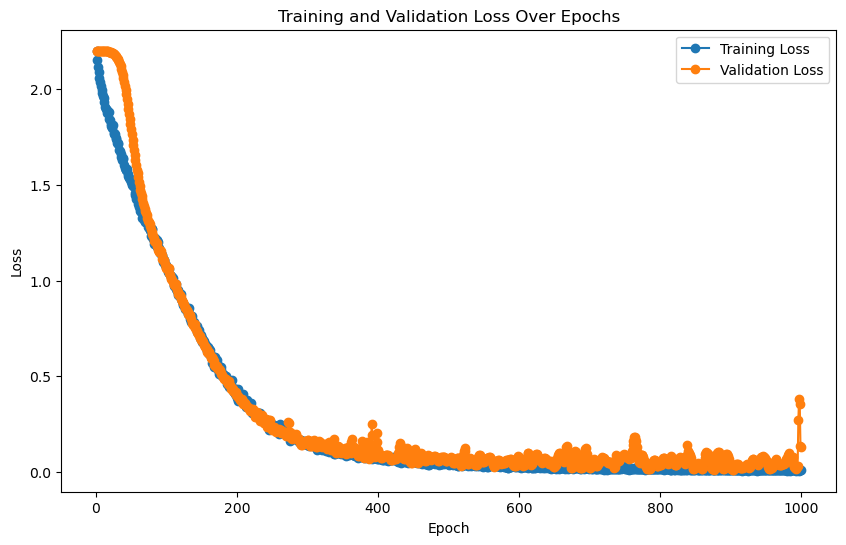

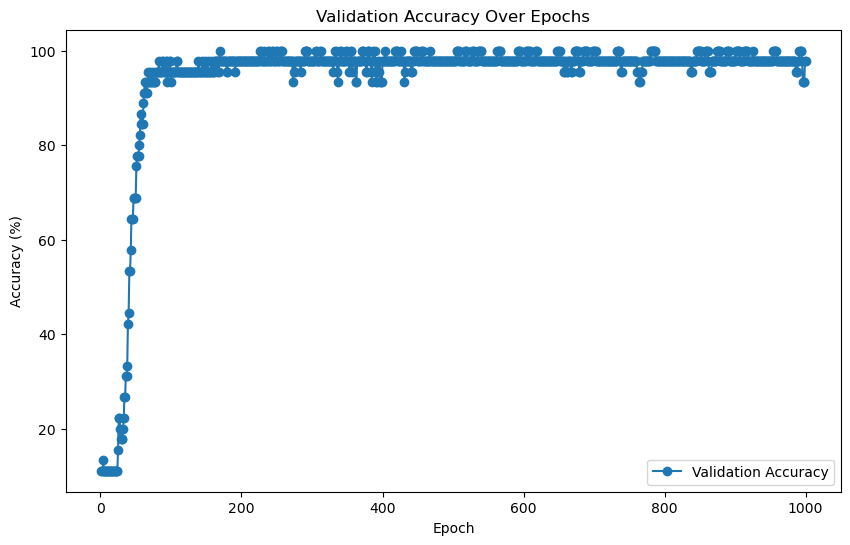


Evaluating on the test set...
    Test Batch [1/578], Loss: 0.0341



Final Test Loss: 0.1055, Test Accuracy: 97.80%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.


  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.
  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.


  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.


  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.
  Processed batch 240/578 for test dataset.


  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.
  Processed batch 290/578 for test dataset.


  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.
  Processed batch 340/578 for test dataset.


  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.
  Processed batch 390/578 for test dataset.


  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.
  Processed batch 440/578 for test dataset.


  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.
  Processed batch 490/578 for test dataset.


  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.
  Processed batch 540/578 for test dataset.


  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)

LOG: Training features shape: (180, 64), Training labels shape: (180,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (147927, 64), Test labels shape: (147927,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 97.78%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00    

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)
Train reps shape: (180, 64)
Train labels shape: (180,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (147927, 64)
Test labels shape: (147927,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1683  |  Val Loss: 2.0363
Validation loss improved from inf to 2.0363.
[Epoch 2/1000] Train Loss: 1.9992  |  Val Loss: 1.9127
Validation loss improved from 2.0363 to 1.9127.
[Epoch 3/1000] Train Loss: 1.8752  |  Val Loss: 1.8086
Validation loss improved from 1.9127 to 1.8086.
[Epoch 4/1000] Train Loss: 1.7676  |  Val Loss: 1.7060
Validation loss improved from 1.8086 to 1.7060.
[Epoch 5/1000] Train Loss: 1.6637  |  Val Loss: 1.6053
Validation loss improved from 1.7060 to 1.6053.


[Epoch 6/1000] Train Loss: 1.5671  |  Val Loss: 1.5098
Validation loss improved from 1.6053 to 1.5098.
[Epoch 7/1000] Train Loss: 1.4788  |  Val Loss: 1.4237
Validation loss improved from 1.5098 to 1.4237.
[Epoch 8/1000] Train Loss: 1.3940  |  Val Loss: 1.3371
Validation loss improved from 1.4237 to 1.3371.
[Epoch 9/1000] Train Loss: 1.3124  |  Val Loss: 1.2585
Validation loss improved from 1.3371 to 1.2585.
[Epoch 10/1000] Train Loss: 1.2314  |  Val Loss: 1.1824
Validation loss improved from 1.2585 to 1.1824.
[Epoch 11/1000] Train Loss: 1.1556  |  Val Loss: 1.1075
Validation loss improved from 1.1824 to 1.1075.
[Epoch 12/1000] Train Loss: 1.0761  |  Val Loss: 1.0301
Validation loss improved from 1.1075 to 1.0301.
[Epoch 13/1000] Train Loss: 0.9959  |  Val Loss: 0.9517
Validation loss improved from 1.0301 to 0.9517.
[Epoch 14/1000] Train Loss: 0.9188  |  Val Loss: 0.8755
Validation loss improved from 0.9517 to 0.8755.
[Epoch 15/1000] Train Loss: 0.8446  |  Val Loss: 0.7994
Validation l

[Epoch 30/1000] Train Loss: 0.1872  |  Val Loss: 0.2077
Validation loss improved from 0.2242 to 0.2077.
[Epoch 31/1000] Train Loss: 0.1783  |  Val Loss: 0.1928
Validation loss improved from 0.2077 to 0.1928.
[Epoch 32/1000] Train Loss: 0.1650  |  Val Loss: 0.1899
Validation loss improved from 0.1928 to 0.1899.
[Epoch 33/1000] Train Loss: 0.1539  |  Val Loss: 0.1803
Validation loss improved from 0.1899 to 0.1803.
[Epoch 34/1000] Train Loss: 0.1502  |  Val Loss: 0.1750
Validation loss improved from 0.1803 to 0.1750.
[Epoch 35/1000] Train Loss: 0.1476  |  Val Loss: 0.1773
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 36/1000] Train Loss: 0.1303  |  Val Loss: 0.1579
Validation loss improved from 0.1750 to 0.1579.
[Epoch 37/1000] Train Loss: 0.1275  |  Val Loss: 0.1533
Validation loss improved from 0.1579 to 0.1533.
[Epoch 38/1000] Train Loss: 0.1266  |  Val Loss: 0.1569
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 39/1000] Train Loss: 0.1143  |  Val Loss: 0.1504
Validation loss improved from 0.1533 to 0.1504.
[Epoch 40/1000] Train Loss: 0.1084  |  Val Loss: 0.1425
Validation loss improved from 0.1504 to 0.1425.
[Epoch 41/1000] Train Loss: 0.1056  |  Val Loss: 0.1343
Validation loss improved from 0.1425 to 0.1343.
[Epoch 42/1000] Train Loss: 0.0999  |  Val Loss: 0.1358
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 43/1000] Train Loss: 0.1000  |  Val Loss: 0.1335
Validation loss improved from 0.1343 to 0.1335.
[Epoch 44/1000] Train Loss: 0.0942  |  Val Loss: 0.1326
Validation loss improved from 0.1335 to 0.1326.
[Epoch 45/1000] Train Loss: 0.0905  |  Val Loss: 0.1338
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 46/1000] Train Loss: 0.0865  |  Val Loss: 0.1283
Validation loss improved from 0.1326 to 0.1283.
[Epoch 47/1000] Train Loss: 0.0878  |  Val Loss: 0.1238
Validation loss improved from 0.1283 to 0.1238.
[Epoch 48/1000] Train Loss: 0.0843  |  Val Loss: 0.1

[Epoch 59/1000] Train Loss: 0.0664  |  Val Loss: 0.1200
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 60/1000] Train Loss: 0.0667  |  Val Loss: 0.1060
Validation loss improved from 0.1104 to 0.1060.
[Epoch 61/1000] Train Loss: 0.0625  |  Val Loss: 0.1035
Validation loss improved from 0.1060 to 0.1035.
[Epoch 62/1000] Train Loss: 0.0607  |  Val Loss: 0.1058
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 63/1000] Train Loss: 0.0563  |  Val Loss: 0.1040
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 64/1000] Train Loss: 0.0558  |  Val Loss: 0.1009
Validation loss improved from 0.1035 to 0.1009.
[Epoch 65/1000] Train Loss: 0.0543  |  Val Loss: 0.1021
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 66/1000] Train Loss: 0.0536  |  Val Loss: 0.1012
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 67/1000] Train Loss: 0.0529  |  Val Loss: 0.1007
Validation loss improved from 0.1009 to 0.1007.


[Epoch 68/1000] Train Loss: 0.0514  |  Val Loss: 0.1021
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 69/1000] Train Loss: 0.0528  |  Val Loss: 0.1041
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 70/1000] Train Loss: 0.0495  |  Val Loss: 0.1015
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 71/1000] Train Loss: 0.0498  |  Val Loss: 0.0990
Validation loss improved from 0.1007 to 0.0990.
[Epoch 72/1000] Train Loss: 0.0486  |  Val Loss: 0.1008
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 0.0469  |  Val Loss: 0.1009
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 0.0453  |  Val Loss: 0.1007
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 75/1000] Train Loss: 0.0474  |  Val Loss: 0.0993
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 76/1000] Train Loss: 0.0454  |  Val Loss: 0.0979
Validation loss improved from 0.0990 to 0.0979.
[Epoch 77/1000] Train 

[Epoch 90/1000] Train Loss: 0.0382  |  Val Loss: 0.0897
Validation loss improved from 0.0914 to 0.0897.
[Epoch 91/1000] Train Loss: 0.0349  |  Val Loss: 0.0943
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 92/1000] Train Loss: 0.0364  |  Val Loss: 0.1007
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 93/1000] Train Loss: 0.0381  |  Val Loss: 0.0952
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 94/1000] Train Loss: 0.0337  |  Val Loss: 0.0945
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 95/1000] Train Loss: 0.0345  |  Val Loss: 0.0937
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 96/1000] Train Loss: 0.0351  |  Val Loss: 0.0920
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 97/1000] Train Loss: 0.0351  |  Val Loss: 0.0948
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 98/1000] Train Loss: 0.0330  |  Val Loss: 0.0949
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 99/1000] 

[Epoch 100/1000] Train Loss: 0.0316  |  Val Loss: 0.0959
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 101/1000] Train Loss: 0.0306  |  Val Loss: 0.0945
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 102/1000] Train Loss: 0.0326  |  Val Loss: 0.0918
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 103/1000] Train Loss: 0.0310  |  Val Loss: 0.0910
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 104/1000] Train Loss: 0.0314  |  Val Loss: 0.0958
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 105/1000] Train Loss: 0.0297  |  Val Loss: 0.0931
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 106/1000] Train Loss: 0.0302  |  Val Loss: 0.0915
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 107/1000] Train Loss: 0.0303  |  Val Loss: 0.0917
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 108/1000] Train Loss: 0.0301  |  Val Loss: 0.0904
!! Validation loss did NOT improve !! Patience:

[Epoch 121/1000] Train Loss: 0.0250  |  Val Loss: 0.0936
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 122/1000] Train Loss: 0.0237  |  Val Loss: 0.0921
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 123/1000] Train Loss: 0.0227  |  Val Loss: 0.0933
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 124/1000] Train Loss: 0.0262  |  Val Loss: 0.0934
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 125/1000] Train Loss: 0.0228  |  Val Loss: 0.0921
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 126/1000] Train Loss: 0.0223  |  Val Loss: 0.0929
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 127/1000] Train Loss: 0.0236  |  Val Loss: 0.0904
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 128/1000] Train Loss: 0.0209  |  Val Loss: 0.0903
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 129/1000] Train Loss: 0.0250  |  Val Loss: 0.0905
!! Validation loss did NOT improve !! Patience:

[Epoch 135/1000] Train Loss: 0.0191  |  Val Loss: 0.0914
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 136/1000] Train Loss: 0.0194  |  Val Loss: 0.0944
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 137/1000] Train Loss: 0.0193  |  Val Loss: 0.0954
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 138/1000] Train Loss: 0.0195  |  Val Loss: 0.0959
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 139/1000] Train Loss: 0.0189  |  Val Loss: 0.0970
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 140/1000] Train Loss: 0.0179  |  Val Loss: 0.0996
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 141/1000] Train Loss: 0.0179  |  Val Loss: 0.1003
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 142/1000] Train Loss: 0.0180  |  Val Loss: 0.0964
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 143/1000] Train Loss: 0.0180  |  Val Loss: 0.0938
!! Validation loss did NOT improve !! Patience:

[Epoch 154/1000] Train Loss: 0.0178  |  Val Loss: 0.0923
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 155/1000] Train Loss: 0.0169  |  Val Loss: 0.0955
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 156/1000] Train Loss: 0.0144  |  Val Loss: 0.0965
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 157/1000] Train Loss: 0.0150  |  Val Loss: 0.0926
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 158/1000] Train Loss: 0.0144  |  Val Loss: 0.0886
Validation loss improved from 0.0897 to 0.0886.
[Epoch 159/1000] Train Loss: 0.0163  |  Val Loss: 0.0906
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 160/1000] Train Loss: 0.0136  |  Val Loss: 0.0924
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 161/1000] Train Loss: 0.0141  |  Val Loss: 0.0963
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 162/1000] Train Loss: 0.0133  |  Val Loss: 0.0970
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 167/1000] Train Loss: 0.0144  |  Val Loss: 0.0970
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 168/1000] Train Loss: 0.0157  |  Val Loss: 0.0944
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 169/1000] Train Loss: 0.0124  |  Val Loss: 0.0923
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 170/1000] Train Loss: 0.0126  |  Val Loss: 0.0922
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 171/1000] Train Loss: 0.0126  |  Val Loss: 0.0904
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 172/1000] Train Loss: 0.0113  |  Val Loss: 0.0948
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 173/1000] Train Loss: 0.0142  |  Val Loss: 0.1000
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 174/1000] Train Loss: 0.0154  |  Val Loss: 0.1033
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 175/1000] Train Loss: 0.0166  |  Val Loss: 0.0936
!! Validation loss did NOT improve !! Patience: 

[Epoch 190/1000] Train Loss: 0.0092  |  Val Loss: 0.1060
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 191/1000] Train Loss: 0.0084  |  Val Loss: 0.1031
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 192/1000] Train Loss: 0.0083  |  Val Loss: 0.0974
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 193/1000] Train Loss: 0.0082  |  Val Loss: 0.0961
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 194/1000] Train Loss: 0.0085  |  Val Loss: 0.0983
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 195/1000] Train Loss: 0.0085  |  Val Loss: 0.1022
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 196/1000] Train Loss: 0.0084  |  Val Loss: 0.1072
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 197/1000] Train Loss: 0.0081  |  Val Loss: 0.1056
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 198/1000] Train Loss: 0.0074  |  Val Loss: 0.0991
!! Validation loss did NOT improve !! Patience:

[Epoch 203/1000] Train Loss: 0.0073  |  Val Loss: 0.1036
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 204/1000] Train Loss: 0.0079  |  Val Loss: 0.0926
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 205/1000] Train Loss: 0.0074  |  Val Loss: 0.0930
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 206/1000] Train Loss: 0.0079  |  Val Loss: 0.1054
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 207/1000] Train Loss: 0.0087  |  Val Loss: 0.1143
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 208/1000] Train Loss: 0.0078  |  Val Loss: 0.1091
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 209/1000] Train Loss: 0.0065  |  Val Loss: 0.1023
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 210/1000] Train Loss: 0.0068  |  Val Loss: 0.0967
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 211/1000] Train Loss: 0.0063  |  Val Loss: 0.0985
!! Validation loss did NOT improve !! Patience:

[Epoch 224/1000] Train Loss: 0.0058  |  Val Loss: 0.1053
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 225/1000] Train Loss: 0.0054  |  Val Loss: 0.1050
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 226/1000] Train Loss: 0.0051  |  Val Loss: 0.1040
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 227/1000] Train Loss: 0.0053  |  Val Loss: 0.1042
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 228/1000] Train Loss: 0.0051  |  Val Loss: 0.1078
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 229/1000] Train Loss: 0.0050  |  Val Loss: 0.1078
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 230/1000] Train Loss: 0.0057  |  Val Loss: 0.1092
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 231/1000] Train Loss: 0.0047  |  Val Loss: 0.1061
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 232/1000] Train Loss: 0.0053  |  Val Loss: 0.1070
!! Validation loss did NOT improve !! Patience:

[Epoch 236/1000] Train Loss: 0.0066  |  Val Loss: 0.1054
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 237/1000] Train Loss: 0.0051  |  Val Loss: 0.1112
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 238/1000] Train Loss: 0.0062  |  Val Loss: 0.1100
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 239/1000] Train Loss: 0.0043  |  Val Loss: 0.1056
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 240/1000] Train Loss: 0.0055  |  Val Loss: 0.1039
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 241/1000] Train Loss: 0.0046  |  Val Loss: 0.1072
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 242/1000] Train Loss: 0.0046  |  Val Loss: 0.1141
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 243/1000] Train Loss: 0.0048  |  Val Loss: 0.1129
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 244/1000] Train Loss: 0.0044  |  Val Loss: 0.1078
!! Validation loss did NOT improve !! Patience:

[Epoch 256/1000] Train Loss: 0.0035  |  Val Loss: 0.1052
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 257/1000] Train Loss: 0.0034  |  Val Loss: 0.1054
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 258/1000] Train Loss: 0.0033  |  Val Loss: 0.1060
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 258 !!
No improvement for 100 epochs.


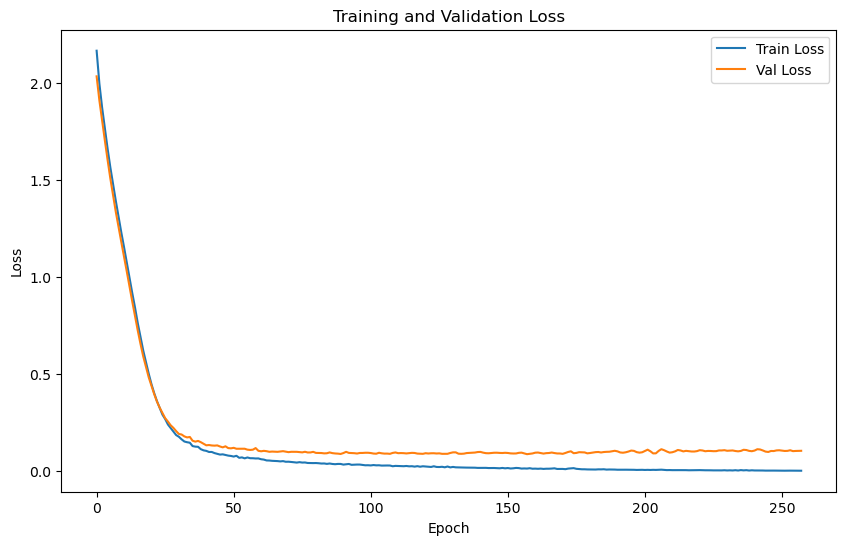

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.1516 | Test Accuracy: 96.81%


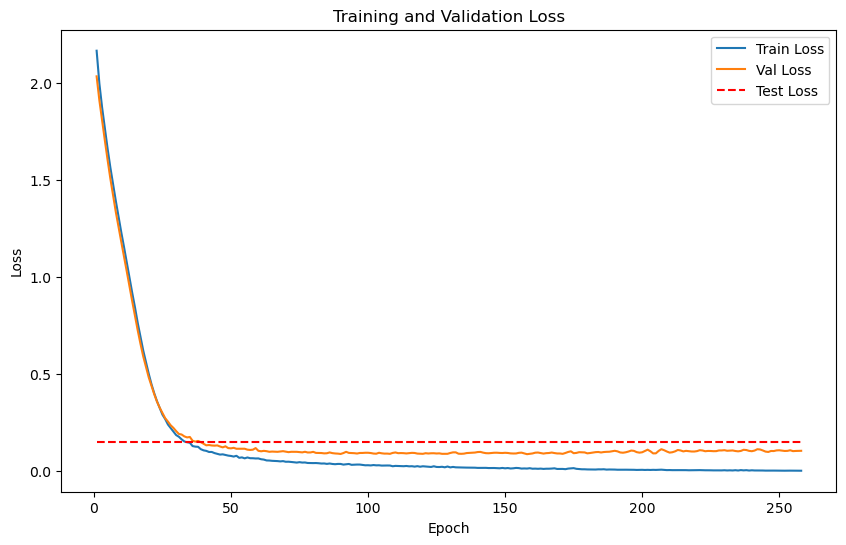

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147927, 64), 
Test labels shape: (147927,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.2696
Epoch [1/2000], Avg Train Loss: 8.2696
Epoch [1/2000], Avg Val Loss: 3.3544
Validation loss improved from inf to 3.3544. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.2404
Epoch [2/2000], Avg Train Loss: 8.2404
Epoch [2/2000], Avg Val Loss: 3.3175
Validation loss improved from 3.3544 to 3.3175. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.2460
Epoch [3/2000], Avg Train Loss: 8.2460
Epoch [3/2000], Avg Val Loss: 3.2819
Validation loss improved from 3.3175 to 3.2819. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.1180
Epoch [4/2000], Avg Train Loss: 8.1180
Epoch [4/2000], Avg Val Loss: 3.2478
Validation loss improved from 3.2819 to 3.2478. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.9979
Epoch [5/2000], Avg Train Loss: 7.9979
Epoch [5/2000], Avg Val Loss: 3.2148
Validation loss improved from 3.2478 to 3.2148. Saving mode

Epoch [13/2000], Avg Val Loss: 2.9901
Validation loss improved from 3.0146 to 2.9901. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.2016
Epoch [14/2000], Avg Train Loss: 7.2016
Epoch [14/2000], Avg Val Loss: 2.9665
Validation loss improved from 2.9901 to 2.9665. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.2148
Epoch [15/2000], Avg Train Loss: 7.2148
Epoch [15/2000], Avg Val Loss: 2.9438
Validation loss improved from 2.9665 to 2.9438. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.0687
Epoch [16/2000], Avg Train Loss: 7.0687
Epoch [16/2000], Avg Val Loss: 2.9221
Validation loss improved from 2.9438 to 2.9221. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 6.9759
Epoch [17/2000], Avg Train Loss: 6.9759
Epoch [17/2000], Avg Val Loss: 2.9012
Validation loss improved from 2.9221 to 2.9012. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.5315
Epoch [44/2000], Avg Train Loss: 5.5315
Epoch [44/2000], Avg Val Loss: 2.5809
Validation loss improved from 2.5870 to 2.5809. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 5.7537
Epoch [45/2000], Avg Train Loss: 5.7537
Epoch [45/2000], Avg Val Loss: 2.5752
Validation loss improved from 2.5809 to 2.5752. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 5.6765
Epoch [46/2000], Avg Train Loss: 5.6765
Epoch [46/2000], Avg Val Loss: 2.5697
Validation loss improved from 2.5752 to 2.5697. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.5371
Epoch [47/2000], Avg Train Loss: 5.5371
Epoch [47/2000], Avg Val Loss: 2.5645
Validation loss improved from 2.5697 to 2.5645. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.7322
Epoch [48/2000], Avg Train Loss: 5.7322
Epoch [48/2000], Avg Val Loss: 2.5595
Validation loss improved from 2.5645 to 2.

    Batch [1/1], Train Loss: 5.4959
Epoch [51/2000], Avg Train Loss: 5.4959
Epoch [51/2000], Avg Val Loss: 2.5459
Validation loss improved from 2.5502 to 2.5459. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.5330
Epoch [52/2000], Avg Train Loss: 5.5330
Epoch [52/2000], Avg Val Loss: 2.5419
Validation loss improved from 2.5459 to 2.5419. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.4806
Epoch [53/2000], Avg Train Loss: 5.4806
Epoch [53/2000], Avg Val Loss: 2.5380
Validation loss improved from 2.5419 to 2.5380. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.3858
Epoch [54/2000], Avg Train Loss: 5.3858
Epoch [54/2000], Avg Val Loss: 2.5343
Validation loss improved from 2.5380 to 2.5343. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.5069
Epoch [55/2000], Avg Train Loss: 5.5069
Epoch [55/2000], Avg Val Loss: 2.5308
Validation loss improved from 2.5343 to 2.

    Batch [1/1], Train Loss: 4.8078
Epoch [88/2000], Avg Train Loss: 4.8078
Epoch [88/2000], Avg Val Loss: 2.4701
Validation loss improved from 2.4711 to 2.4701. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 4.8679
Epoch [89/2000], Avg Train Loss: 4.8679
Epoch [89/2000], Avg Val Loss: 2.4690
Validation loss improved from 2.4701 to 2.4690. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 4.6892
Epoch [90/2000], Avg Train Loss: 4.6892
Epoch [90/2000], Avg Val Loss: 2.4679
Validation loss improved from 2.4690 to 2.4679. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 4.7356
Epoch [91/2000], Avg Train Loss: 4.7356
Epoch [91/2000], Avg Val Loss: 2.4668
Validation loss improved from 2.4679 to 2.4668. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 4.7288
Epoch [92/2000], Avg Train Loss: 4.7288
Epoch [92/2000], Avg Val Loss: 2.4657
Validation loss improved from 2.4668 to 2.

    Batch [1/1], Train Loss: 4.3957
Epoch [133/2000], Avg Train Loss: 4.3957
Epoch [133/2000], Avg Val Loss: 2.4234
Validation loss improved from 2.4245 to 2.4234. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.4211
Epoch [134/2000], Avg Train Loss: 4.4211
Epoch [134/2000], Avg Val Loss: 2.4223
Validation loss improved from 2.4234 to 2.4223. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.4256
Epoch [135/2000], Avg Train Loss: 4.4256
Epoch [135/2000], Avg Val Loss: 2.4212
Validation loss improved from 2.4223 to 2.4212. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 4.4685
Epoch [136/2000], Avg Train Loss: 4.4685
Epoch [136/2000], Avg Val Loss: 2.4202
Validation loss improved from 2.4212 to 2.4202. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 4.4101
Epoch [137/2000], Avg Train Loss: 4.4101
Epoch [137/2000], Avg Val Loss: 2.4191
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2815
Epoch [178/2000], Avg Train Loss: 4.2815
Epoch [178/2000], Avg Val Loss: 2.3730
Validation loss improved from 2.3741 to 2.3730. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 4.2714
Epoch [179/2000], Avg Train Loss: 4.2714
Epoch [179/2000], Avg Val Loss: 2.3719
Validation loss improved from 2.3730 to 2.3719. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 4.2346
Epoch [180/2000], Avg Train Loss: 4.2346
Epoch [180/2000], Avg Val Loss: 2.3708
Validation loss improved from 2.3719 to 2.3708. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 4.2862
Epoch [181/2000], Avg Train Loss: 4.2862
Epoch [181/2000], Avg Val Loss: 2.3698
Validation loss improved from 2.3708 to 2.3698. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 4.2245
Epoch [182/2000], Avg Train Loss: 4.2245
Epoch [182/2000], Avg Val Loss: 2.3687
Validation loss improved fro

Epoch [221/2000], Avg Val Loss: 2.3267
Validation loss improved from 2.3278 to 2.3267. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 4.1134
Epoch [222/2000], Avg Train Loss: 4.1134
Epoch [222/2000], Avg Val Loss: 2.3257
Validation loss improved from 2.3267 to 2.3257. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 4.1349
Epoch [223/2000], Avg Train Loss: 4.1349
Epoch [223/2000], Avg Val Loss: 2.3247
Validation loss improved from 2.3257 to 2.3247. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 4.1077
Epoch [224/2000], Avg Train Loss: 4.1077
Epoch [224/2000], Avg Val Loss: 2.3237
Validation loss improved from 2.3247 to 2.3237. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 4.1314
Epoch [225/2000], Avg Train Loss: 4.1314
Epoch [225/2000], Avg Val Loss: 2.3226
Validation loss improved from 2.3237 to 2.3226. Saving model...

LOG: Epoch [226/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0538
Epoch [268/2000], Avg Train Loss: 4.0538
Epoch [268/2000], Avg Val Loss: 2.2805
Validation loss improved from 2.2814 to 2.2805. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 4.0112
Epoch [269/2000], Avg Train Loss: 4.0112
Epoch [269/2000], Avg Val Loss: 2.2796
Validation loss improved from 2.2805 to 2.2796. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 4.0383
Epoch [270/2000], Avg Train Loss: 4.0383
Epoch [270/2000], Avg Val Loss: 2.2787
Validation loss improved from 2.2796 to 2.2787. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 4.0284
Epoch [271/2000], Avg Train Loss: 4.0284
Epoch [271/2000], Avg Val Loss: 2.2778
Validation loss improved from 2.2787 to 2.2778. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 4.0318
Epoch [272/2000], Avg Train Loss: 4.0318
Epoch [272/2000], Avg Val Loss: 2.2769
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9361
Epoch [311/2000], Avg Train Loss: 3.9361
Epoch [311/2000], Avg Val Loss: 2.2428
Validation loss improved from 2.2437 to 2.2428. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 3.9303
Epoch [312/2000], Avg Train Loss: 3.9303
Epoch [312/2000], Avg Val Loss: 2.2419
Validation loss improved from 2.2428 to 2.2419. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 3.9363
Epoch [313/2000], Avg Train Loss: 3.9363
Epoch [313/2000], Avg Val Loss: 2.2411
Validation loss improved from 2.2419 to 2.2411. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 3.9362
Epoch [314/2000], Avg Train Loss: 3.9362
Epoch [314/2000], Avg Val Loss: 2.2402
Validation loss improved from 2.2411 to 2.2402. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 3.9672
Epoch [315/2000], Avg Train Loss: 3.9672
Epoch [315/2000], Avg Val Loss: 2.2394
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8711
Epoch [357/2000], Avg Train Loss: 3.8711
Epoch [357/2000], Avg Val Loss: 2.2070
Validation loss improved from 2.2077 to 2.2070. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 3.8975
Epoch [358/2000], Avg Train Loss: 3.8975
Epoch [358/2000], Avg Val Loss: 2.2063
Validation loss improved from 2.2070 to 2.2063. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 3.9083
Epoch [359/2000], Avg Train Loss: 3.9083
Epoch [359/2000], Avg Val Loss: 2.2056
Validation loss improved from 2.2063 to 2.2056. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 3.8572
Epoch [360/2000], Avg Train Loss: 3.8572
Epoch [360/2000], Avg Val Loss: 2.2049
Validation loss improved from 2.2056 to 2.2049. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 3.8846
Epoch [361/2000], Avg Train Loss: 3.8846
Epoch [361/2000], Avg Val Loss: 2.2043
Validation loss improved fro

Epoch [403/2000], Avg Val Loss: 2.1757
Validation loss improved from 2.1763 to 2.1757. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 3.7959
Epoch [404/2000], Avg Train Loss: 3.7959
Epoch [404/2000], Avg Val Loss: 2.1750
Validation loss improved from 2.1757 to 2.1750. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 3.7831
Epoch [405/2000], Avg Train Loss: 3.7831
Epoch [405/2000], Avg Val Loss: 2.1744
Validation loss improved from 2.1750 to 2.1744. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 3.8275
Epoch [406/2000], Avg Train Loss: 3.8275
Epoch [406/2000], Avg Val Loss: 2.1738
Validation loss improved from 2.1744 to 2.1738. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 3.8230
Epoch [407/2000], Avg Train Loss: 3.8230
Epoch [407/2000], Avg Val Loss: 2.1732
Validation loss improved from 2.1738 to 2.1732. Saving model...

LOG: Epoch [408/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7565
Epoch [448/2000], Avg Train Loss: 3.7565
Epoch [448/2000], Avg Val Loss: 2.1496
Validation loss improved from 2.1501 to 2.1496. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 3.7379
Epoch [449/2000], Avg Train Loss: 3.7379
Epoch [449/2000], Avg Val Loss: 2.1491
Validation loss improved from 2.1496 to 2.1491. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 3.7748
Epoch [450/2000], Avg Train Loss: 3.7748
Epoch [450/2000], Avg Val Loss: 2.1486
Validation loss improved from 2.1491 to 2.1486. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 3.7769
Epoch [451/2000], Avg Train Loss: 3.7769
Epoch [451/2000], Avg Val Loss: 2.1481
Validation loss improved from 2.1486 to 2.1481. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 3.7986
Epoch [452/2000], Avg Train Loss: 3.7986
Epoch [452/2000], Avg Val Loss: 2.1477
Validation loss improved fro

Epoch [491/2000], Avg Val Loss: 2.1306
Validation loss improved from 2.1310 to 2.1306. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 3.7287
Epoch [492/2000], Avg Train Loss: 3.7287
Epoch [492/2000], Avg Val Loss: 2.1302
Validation loss improved from 2.1306 to 2.1302. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 3.7221
Epoch [493/2000], Avg Train Loss: 3.7221
Epoch [493/2000], Avg Val Loss: 2.1299
Validation loss improved from 2.1302 to 2.1299. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 3.7388
Epoch [494/2000], Avg Train Loss: 3.7388
Epoch [494/2000], Avg Val Loss: 2.1295
Validation loss improved from 2.1299 to 2.1295. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 3.7264
Epoch [495/2000], Avg Train Loss: 3.7264
Epoch [495/2000], Avg Val Loss: 2.1291
Validation loss improved from 2.1295 to 2.1291. Saving model...

LOG: Epoch [496/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6919
Epoch [533/2000], Avg Train Loss: 3.6919
Epoch [533/2000], Avg Val Loss: 2.1134
Validation loss improved from 2.1138 to 2.1134. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 3.6630
Epoch [534/2000], Avg Train Loss: 3.6630
Epoch [534/2000], Avg Val Loss: 2.1130
Validation loss improved from 2.1134 to 2.1130. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 3.6761
Epoch [535/2000], Avg Train Loss: 3.6761
Epoch [535/2000], Avg Val Loss: 2.1126
Validation loss improved from 2.1130 to 2.1126. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 3.6568
Epoch [536/2000], Avg Train Loss: 3.6568
Epoch [536/2000], Avg Val Loss: 2.1122
Validation loss improved from 2.1126 to 2.1122. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 3.6508
Epoch [537/2000], Avg Train Loss: 3.6508
Epoch [537/2000], Avg Val Loss: 2.1118
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6625
Epoch [580/2000], Avg Train Loss: 3.6625
Epoch [580/2000], Avg Val Loss: 2.0967
Validation loss improved from 2.0970 to 2.0967. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 3.6488
Epoch [581/2000], Avg Train Loss: 3.6488
Epoch [581/2000], Avg Val Loss: 2.0963
Validation loss improved from 2.0967 to 2.0963. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 3.6365
Epoch [582/2000], Avg Train Loss: 3.6365
Epoch [582/2000], Avg Val Loss: 2.0958
Validation loss improved from 2.0963 to 2.0958. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 3.6472
Epoch [583/2000], Avg Train Loss: 3.6472
Epoch [583/2000], Avg Val Loss: 2.0954
Validation loss improved from 2.0958 to 2.0954. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 3.6075
Epoch [584/2000], Avg Train Loss: 3.6075
Epoch [584/2000], Avg Val Loss: 2.0950
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5949
Epoch [620/2000], Avg Train Loss: 3.5949
Epoch [620/2000], Avg Val Loss: 2.0818
Validation loss improved from 2.0823 to 2.0818. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 3.6010
Epoch [621/2000], Avg Train Loss: 3.6010
Epoch [621/2000], Avg Val Loss: 2.0814
Validation loss improved from 2.0818 to 2.0814. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 3.6003
Epoch [622/2000], Avg Train Loss: 3.6003
Epoch [622/2000], Avg Val Loss: 2.0809
Validation loss improved from 2.0814 to 2.0809. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 3.6440
Epoch [623/2000], Avg Train Loss: 3.6440
Epoch [623/2000], Avg Val Loss: 2.0805
Validation loss improved from 2.0809 to 2.0805. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 3.6052
Epoch [624/2000], Avg Train Loss: 3.6052
Epoch [624/2000], Avg Val Loss: 2.0800
Validation loss improved fro

Epoch [665/2000], Avg Val Loss: 2.0650
Validation loss improved from 2.0653 to 2.0650. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 3.5817
Epoch [666/2000], Avg Train Loss: 3.5817
Epoch [666/2000], Avg Val Loss: 2.0647
Validation loss improved from 2.0650 to 2.0647. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 3.5806
Epoch [667/2000], Avg Train Loss: 3.5806
Epoch [667/2000], Avg Val Loss: 2.0644
Validation loss improved from 2.0647 to 2.0644. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 3.5862
Epoch [668/2000], Avg Train Loss: 3.5862
Epoch [668/2000], Avg Val Loss: 2.0640
Validation loss improved from 2.0644 to 2.0640. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 3.5723
Epoch [669/2000], Avg Train Loss: 3.5723
Epoch [669/2000], Avg Val Loss: 2.0637
Validation loss improved from 2.0640 to 2.0637. Saving model...

LOG: Epoch [670/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5421
Epoch [708/2000], Avg Train Loss: 3.5421
Epoch [708/2000], Avg Val Loss: 2.0522
Validation loss improved from 2.0525 to 2.0522. Saving model...

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 3.5446
Epoch [709/2000], Avg Train Loss: 3.5446
Epoch [709/2000], Avg Val Loss: 2.0520
Validation loss improved from 2.0522 to 2.0520. Saving model...

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 3.5687
Epoch [710/2000], Avg Train Loss: 3.5687
Epoch [710/2000], Avg Val Loss: 2.0517
Validation loss improved from 2.0520 to 2.0517. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 3.5546
Epoch [711/2000], Avg Train Loss: 3.5546
Epoch [711/2000], Avg Val Loss: 2.0515
Validation loss improved from 2.0517 to 2.0515. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 3.5597
Epoch [712/2000], Avg Train Loss: 3.5597
Epoch [712/2000], Avg Val Loss: 2.0511
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5206
Epoch [750/2000], Avg Train Loss: 3.5206
Epoch [750/2000], Avg Val Loss: 2.0389
Validation loss improved from 2.0392 to 2.0389. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 3.5613
Epoch [751/2000], Avg Train Loss: 3.5613
Epoch [751/2000], Avg Val Loss: 2.0386
Validation loss improved from 2.0389 to 2.0386. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 3.5508
Epoch [752/2000], Avg Train Loss: 3.5508
Epoch [752/2000], Avg Val Loss: 2.0383
Validation loss improved from 2.0386 to 2.0383. Saving model...

LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 3.5532
Epoch [753/2000], Avg Train Loss: 3.5532
Epoch [753/2000], Avg Val Loss: 2.0380
Validation loss improved from 2.0383 to 2.0380. Saving model...

LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 3.5411
Epoch [754/2000], Avg Train Loss: 3.5411
Epoch [754/2000], Avg Val Loss: 2.0377
Validation loss improved fro

Epoch [794/2000], Avg Val Loss: 2.0240
Validation loss improved from 2.0242 to 2.0240. Saving model...

LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 3.4948
Epoch [795/2000], Avg Train Loss: 3.4948
Epoch [795/2000], Avg Val Loss: 2.0238
Validation loss improved from 2.0240 to 2.0238. Saving model...

LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 3.5094
Epoch [796/2000], Avg Train Loss: 3.5094
Epoch [796/2000], Avg Val Loss: 2.0235
Validation loss improved from 2.0238 to 2.0235. Saving model...

LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 3.5338
Epoch [797/2000], Avg Train Loss: 3.5338
Epoch [797/2000], Avg Val Loss: 2.0232
Validation loss improved from 2.0235 to 2.0232. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 3.5082
Epoch [798/2000], Avg Train Loss: 3.5082
Epoch [798/2000], Avg Val Loss: 2.0229
Validation loss improved from 2.0232 to 2.0229. Saving model...

LOG: Epoch [799/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5034
Epoch [840/2000], Avg Train Loss: 3.5034
Epoch [840/2000], Avg Val Loss: 2.0079
Validation loss improved from 2.0083 to 2.0079. Saving model...

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 3.5105
Epoch [841/2000], Avg Train Loss: 3.5105
Epoch [841/2000], Avg Val Loss: 2.0076
Validation loss improved from 2.0079 to 2.0076. Saving model...

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 3.4381
Epoch [842/2000], Avg Train Loss: 3.4381
Epoch [842/2000], Avg Val Loss: 2.0072
Validation loss improved from 2.0076 to 2.0072. Saving model...

LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 3.4643
Epoch [843/2000], Avg Train Loss: 3.4643
Epoch [843/2000], Avg Val Loss: 2.0068
Validation loss improved from 2.0072 to 2.0068. Saving model...

LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 3.4889
Epoch [844/2000], Avg Train Loss: 3.4889
Epoch [844/2000], Avg Val Loss: 2.0064
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4560
Epoch [883/2000], Avg Train Loss: 3.4560
Epoch [883/2000], Avg Val Loss: 1.9927
Validation loss improved from 1.9931 to 1.9927. Saving model...

LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 3.4969
Epoch [884/2000], Avg Train Loss: 3.4969
Epoch [884/2000], Avg Val Loss: 1.9923
Validation loss improved from 1.9927 to 1.9923. Saving model...

LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 3.4607
Epoch [885/2000], Avg Train Loss: 3.4607
Epoch [885/2000], Avg Val Loss: 1.9920
Validation loss improved from 1.9923 to 1.9920. Saving model...

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 3.4471
Epoch [886/2000], Avg Train Loss: 3.4471
Epoch [886/2000], Avg Val Loss: 1.9916
Validation loss improved from 1.9920 to 1.9916. Saving model...

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 3.4572
Epoch [887/2000], Avg Train Loss: 3.4572
Epoch [887/2000], Avg Val Loss: 1.9912
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4856
Epoch [925/2000], Avg Train Loss: 3.4856
Epoch [925/2000], Avg Val Loss: 1.9769
Validation loss improved from 1.9772 to 1.9769. Saving model...

LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 3.4369
Epoch [926/2000], Avg Train Loss: 3.4369
Epoch [926/2000], Avg Val Loss: 1.9766
Validation loss improved from 1.9769 to 1.9766. Saving model...

LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 3.4712
Epoch [927/2000], Avg Train Loss: 3.4712
Epoch [927/2000], Avg Val Loss: 1.9764
Validation loss improved from 1.9766 to 1.9764. Saving model...

LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 3.4666
Epoch [928/2000], Avg Train Loss: 3.4666
Epoch [928/2000], Avg Val Loss: 1.9761
Validation loss improved from 1.9764 to 1.9761. Saving model...

LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 3.4281
Epoch [929/2000], Avg Train Loss: 3.4281
Epoch [929/2000], Avg Val Loss: 1.9757
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4113
Epoch [970/2000], Avg Train Loss: 3.4113
Epoch [970/2000], Avg Val Loss: 1.9620
Validation loss improved from 1.9623 to 1.9620. Saving model...

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 3.4066
Epoch [971/2000], Avg Train Loss: 3.4066
Epoch [971/2000], Avg Val Loss: 1.9618
Validation loss improved from 1.9620 to 1.9618. Saving model...

LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 3.4490
Epoch [972/2000], Avg Train Loss: 3.4490
Epoch [972/2000], Avg Val Loss: 1.9615
Validation loss improved from 1.9618 to 1.9615. Saving model...

LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 3.4626
Epoch [973/2000], Avg Train Loss: 3.4626
Epoch [973/2000], Avg Val Loss: 1.9612
Validation loss improved from 1.9615 to 1.9612. Saving model...

LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 3.4371
Epoch [974/2000], Avg Train Loss: 3.4371
Epoch [974/2000], Avg Val Loss: 1.9609
Validation loss improved fro

Epoch [1015/2000], Avg Val Loss: 1.9502
Validation loss improved from 1.9505 to 1.9502. Saving model...

LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 3.3969
Epoch [1016/2000], Avg Train Loss: 3.3969
Epoch [1016/2000], Avg Val Loss: 1.9499
Validation loss improved from 1.9502 to 1.9499. Saving model...

LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 3.3713
Epoch [1017/2000], Avg Train Loss: 3.3713
Epoch [1017/2000], Avg Val Loss: 1.9496
Validation loss improved from 1.9499 to 1.9496. Saving model...

LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 3.4037
Epoch [1018/2000], Avg Train Loss: 3.4037
Epoch [1018/2000], Avg Val Loss: 1.9493
Validation loss improved from 1.9496 to 1.9493. Saving model...

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 3.4004
Epoch [1019/2000], Avg Train Loss: 3.4004
Epoch [1019/2000], Avg Val Loss: 1.9489
Validation loss improved from 1.9493 to 1.9489. Saving model...

LOG: Epoch [1020/2000] - Tr

    Batch [1/1], Train Loss: 3.3889
Epoch [1059/2000], Avg Train Loss: 3.3889
Epoch [1059/2000], Avg Val Loss: 1.9358
Validation loss improved from 1.9361 to 1.9358. Saving model...

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 3.3865
Epoch [1060/2000], Avg Train Loss: 3.3865
Epoch [1060/2000], Avg Val Loss: 1.9356
Validation loss improved from 1.9358 to 1.9356. Saving model...

LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 3.4015
Epoch [1061/2000], Avg Train Loss: 3.4015
Epoch [1061/2000], Avg Val Loss: 1.9355
Validation loss improved from 1.9356 to 1.9355. Saving model...

LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 3.3896
Epoch [1062/2000], Avg Train Loss: 3.3896
Epoch [1062/2000], Avg Val Loss: 1.9354
Validation loss improved from 1.9355 to 1.9354. Saving model...

LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 3.3900
Epoch [1063/2000], Avg Train Loss: 3.3900
Epoch [1063/2000], Avg Val Loss: 1.9351
Validation los

    Batch [1/1], Train Loss: 3.3737
Epoch [1100/2000], Avg Train Loss: 3.3737
Epoch [1100/2000], Avg Val Loss: 1.9255
Validation loss improved from 1.9258 to 1.9255. Saving model...

LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 3.3773
Epoch [1101/2000], Avg Train Loss: 3.3773
Epoch [1101/2000], Avg Val Loss: 1.9253
Validation loss improved from 1.9255 to 1.9253. Saving model...

LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 3.4081
Epoch [1102/2000], Avg Train Loss: 3.4081
Epoch [1102/2000], Avg Val Loss: 1.9250
Validation loss improved from 1.9253 to 1.9250. Saving model...

LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 3.4132
Epoch [1103/2000], Avg Train Loss: 3.4132
Epoch [1103/2000], Avg Val Loss: 1.9248
Validation loss improved from 1.9250 to 1.9248. Saving model...

LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 3.3743
Epoch [1104/2000], Avg Train Loss: 3.3743
Epoch [1104/2000], Avg Val Loss: 1.9246
Validation los

    Batch [1/1], Train Loss: 3.3987
Epoch [1140/2000], Avg Train Loss: 3.3987
Epoch [1140/2000], Avg Val Loss: 1.9172
Validation loss improved from 1.9174 to 1.9172. Saving model...

LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 3.3613
Epoch [1141/2000], Avg Train Loss: 3.3613
Epoch [1141/2000], Avg Val Loss: 1.9170
Validation loss improved from 1.9172 to 1.9170. Saving model...

LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 3.3994
Epoch [1142/2000], Avg Train Loss: 3.3994
Epoch [1142/2000], Avg Val Loss: 1.9167
Validation loss improved from 1.9170 to 1.9167. Saving model...

LOG: Epoch [1143/2000] - Training
    Batch [1/1], Train Loss: 3.3553
Epoch [1143/2000], Avg Train Loss: 3.3553
Epoch [1143/2000], Avg Val Loss: 1.9165
Validation loss improved from 1.9167 to 1.9165. Saving model...

LOG: Epoch [1144/2000] - Training
    Batch [1/1], Train Loss: 3.3983
Epoch [1144/2000], Avg Train Loss: 3.3983
Epoch [1144/2000], Avg Val Loss: 1.9164
Validation los

    Batch [1/1], Train Loss: 3.3361
Epoch [1180/2000], Avg Train Loss: 3.3361
Epoch [1180/2000], Avg Val Loss: 1.9074
Validation loss improved from 1.9077 to 1.9074. Saving model...

LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 3.3962
Epoch [1181/2000], Avg Train Loss: 3.3962
Epoch [1181/2000], Avg Val Loss: 1.9071
Validation loss improved from 1.9074 to 1.9071. Saving model...

LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 3.3257
Epoch [1182/2000], Avg Train Loss: 3.3257
Epoch [1182/2000], Avg Val Loss: 1.9069
Validation loss improved from 1.9071 to 1.9069. Saving model...

LOG: Epoch [1183/2000] - Training
    Batch [1/1], Train Loss: 3.3690
Epoch [1183/2000], Avg Train Loss: 3.3690
Epoch [1183/2000], Avg Val Loss: 1.9066
Validation loss improved from 1.9069 to 1.9066. Saving model...

LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 3.3443
Epoch [1184/2000], Avg Train Loss: 3.3443
Epoch [1184/2000], Avg Val Loss: 1.9064
Validation los

    Batch [1/1], Train Loss: 3.3619
Epoch [1226/2000], Avg Train Loss: 3.3619
Epoch [1226/2000], Avg Val Loss: 1.8986
Validation loss improved from 1.8988 to 1.8986. Saving model...

LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 3.3124
Epoch [1227/2000], Avg Train Loss: 3.3124
Epoch [1227/2000], Avg Val Loss: 1.8984
Validation loss improved from 1.8986 to 1.8984. Saving model...

LOG: Epoch [1228/2000] - Training
    Batch [1/1], Train Loss: 3.3209
Epoch [1228/2000], Avg Train Loss: 3.3209
Epoch [1228/2000], Avg Val Loss: 1.8982
Validation loss improved from 1.8984 to 1.8982. Saving model...

LOG: Epoch [1229/2000] - Training
    Batch [1/1], Train Loss: 3.3242
Epoch [1229/2000], Avg Train Loss: 3.3242
Epoch [1229/2000], Avg Val Loss: 1.8980
Validation loss improved from 1.8982 to 1.8980. Saving model...

LOG: Epoch [1230/2000] - Training
    Batch [1/1], Train Loss: 3.3489
Epoch [1230/2000], Avg Train Loss: 3.3489
Epoch [1230/2000], Avg Val Loss: 1.8979
Validation los

    Batch [1/1], Train Loss: 3.3571
Epoch [1270/2000], Avg Train Loss: 3.3571
Epoch [1270/2000], Avg Val Loss: 1.8887
Validation loss improved from 1.8889 to 1.8887. Saving model...

LOG: Epoch [1271/2000] - Training
    Batch [1/1], Train Loss: 3.3512
Epoch [1271/2000], Avg Train Loss: 3.3512
Epoch [1271/2000], Avg Val Loss: 1.8884
Validation loss improved from 1.8887 to 1.8884. Saving model...

LOG: Epoch [1272/2000] - Training
    Batch [1/1], Train Loss: 3.3518
Epoch [1272/2000], Avg Train Loss: 3.3518
Epoch [1272/2000], Avg Val Loss: 1.8882
Validation loss improved from 1.8884 to 1.8882. Saving model...

LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 3.3581
Epoch [1273/2000], Avg Train Loss: 3.3581
Epoch [1273/2000], Avg Val Loss: 1.8879
Validation loss improved from 1.8882 to 1.8879. Saving model...

LOG: Epoch [1274/2000] - Training
    Batch [1/1], Train Loss: 3.3555
Epoch [1274/2000], Avg Train Loss: 3.3555
Epoch [1274/2000], Avg Val Loss: 1.8877
Validation los

    Batch [1/1], Train Loss: 3.3489
Epoch [1314/2000], Avg Train Loss: 3.3489
Epoch [1314/2000], Avg Val Loss: 1.8819
Validation loss improved from 1.8820 to 1.8819. Saving model...

LOG: Epoch [1315/2000] - Training
    Batch [1/1], Train Loss: 3.3360
Epoch [1315/2000], Avg Train Loss: 3.3360
Epoch [1315/2000], Avg Val Loss: 1.8818
Validation loss improved from 1.8819 to 1.8818. Saving model...

LOG: Epoch [1316/2000] - Training
    Batch [1/1], Train Loss: 3.3114
Epoch [1316/2000], Avg Train Loss: 3.3114
Epoch [1316/2000], Avg Val Loss: 1.8816
Validation loss improved from 1.8818 to 1.8816. Saving model...

LOG: Epoch [1317/2000] - Training
    Batch [1/1], Train Loss: 3.3203
Epoch [1317/2000], Avg Train Loss: 3.3203
Epoch [1317/2000], Avg Val Loss: 1.8815
Validation loss improved from 1.8816 to 1.8815. Saving model...

LOG: Epoch [1318/2000] - Training
    Batch [1/1], Train Loss: 3.3239
Epoch [1318/2000], Avg Train Loss: 3.3239
Epoch [1318/2000], Avg Val Loss: 1.8814
Validation los

    Batch [1/1], Train Loss: 3.2992
Epoch [1361/2000], Avg Train Loss: 3.2992
Epoch [1361/2000], Avg Val Loss: 1.8744
Validation loss improved from 1.8746 to 1.8744. Saving model...

LOG: Epoch [1362/2000] - Training
    Batch [1/1], Train Loss: 3.3118
Epoch [1362/2000], Avg Train Loss: 3.3118
Epoch [1362/2000], Avg Val Loss: 1.8742
Validation loss improved from 1.8744 to 1.8742. Saving model...

LOG: Epoch [1363/2000] - Training
    Batch [1/1], Train Loss: 3.3300
Epoch [1363/2000], Avg Train Loss: 3.3300
Epoch [1363/2000], Avg Val Loss: 1.8740
Validation loss improved from 1.8742 to 1.8740. Saving model...

LOG: Epoch [1364/2000] - Training
    Batch [1/1], Train Loss: 3.3208
Epoch [1364/2000], Avg Train Loss: 3.3208
Epoch [1364/2000], Avg Val Loss: 1.8739
Validation loss improved from 1.8740 to 1.8739. Saving model...

LOG: Epoch [1365/2000] - Training
    Batch [1/1], Train Loss: 3.3418
Epoch [1365/2000], Avg Train Loss: 3.3418
Epoch [1365/2000], Avg Val Loss: 1.8737
Validation los

    Batch [1/1], Train Loss: 3.3100
Epoch [1410/2000], Avg Train Loss: 3.3100
Epoch [1410/2000], Avg Val Loss: 1.8680
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 3.3071
Epoch [1411/2000], Avg Train Loss: 3.3071
Epoch [1411/2000], Avg Val Loss: 1.8680
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 3.3537
Epoch [1412/2000], Avg Train Loss: 3.3537
Epoch [1412/2000], Avg Val Loss: 1.8681
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 3.3109
Epoch [1413/2000], Avg Train Loss: 3.3109
Epoch [1413/2000], Avg Val Loss: 1.8681
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1414/2000] - Training
    Batch [1/1], Train Loss: 3.3371
Epoch [1414/2000], Avg Train Loss: 3.3371
Epoch [1414/2000], Avg Val Loss: 1.8681
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1415/20

    Batch [1/1], Train Loss: 3.3359
Epoch [1451/2000], Avg Train Loss: 3.3359
Epoch [1451/2000], Avg Val Loss: 1.8635
Validation loss improved from 1.8636 to 1.8635. Saving model...

LOG: Epoch [1452/2000] - Training
    Batch [1/1], Train Loss: 3.2996
Epoch [1452/2000], Avg Train Loss: 3.2996
Epoch [1452/2000], Avg Val Loss: 1.8635
Validation loss improved from 1.8635 to 1.8635. Saving model...

LOG: Epoch [1453/2000] - Training
    Batch [1/1], Train Loss: 3.3026
Epoch [1453/2000], Avg Train Loss: 3.3026
Epoch [1453/2000], Avg Val Loss: 1.8635
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1454/2000] - Training
    Batch [1/1], Train Loss: 3.2768
Epoch [1454/2000], Avg Train Loss: 3.2768
Epoch [1454/2000], Avg Val Loss: 1.8635
Validation loss improved from 1.8635 to 1.8635. Saving model...

LOG: Epoch [1455/2000] - Training
    Batch [1/1], Train Loss: 3.3048
Epoch [1455/2000], Avg Train Loss: 3.3048
Epoch [1455/2000], Avg Val Loss: 1.8634
Validation loss improved from

    Batch [1/1], Train Loss: 3.3248
Epoch [1492/2000], Avg Train Loss: 3.3248
Epoch [1492/2000], Avg Val Loss: 1.8598
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1493/2000] - Training
    Batch [1/1], Train Loss: 3.2901
Epoch [1493/2000], Avg Train Loss: 3.2901
Epoch [1493/2000], Avg Val Loss: 1.8598
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1494/2000] - Training
    Batch [1/1], Train Loss: 3.2841
Epoch [1494/2000], Avg Train Loss: 3.2841
Epoch [1494/2000], Avg Val Loss: 1.8599
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1495/2000] - Training
    Batch [1/1], Train Loss: 3.2762
Epoch [1495/2000], Avg Train Loss: 3.2762
Epoch [1495/2000], Avg Val Loss: 1.8599
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1496/2000] - Training
    Batch [1/1], Train Loss: 3.2977
Epoch [1496/2000], Avg Train Loss: 3.2977
Epoch [1496/2000], Avg Val Loss: 1.8598
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1497/2000

Epoch [1535/2000], Avg Val Loss: 1.8536
Validation loss improved from 1.8537 to 1.8536. Saving model...

LOG: Epoch [1536/2000] - Training
    Batch [1/1], Train Loss: 3.2915
Epoch [1536/2000], Avg Train Loss: 3.2915
Epoch [1536/2000], Avg Val Loss: 1.8534
Validation loss improved from 1.8536 to 1.8534. Saving model...

LOG: Epoch [1537/2000] - Training
    Batch [1/1], Train Loss: 3.2769
Epoch [1537/2000], Avg Train Loss: 3.2769
Epoch [1537/2000], Avg Val Loss: 1.8533
Validation loss improved from 1.8534 to 1.8533. Saving model...

LOG: Epoch [1538/2000] - Training
    Batch [1/1], Train Loss: 3.3295
Epoch [1538/2000], Avg Train Loss: 3.3295
Epoch [1538/2000], Avg Val Loss: 1.8532
Validation loss improved from 1.8533 to 1.8532. Saving model...

LOG: Epoch [1539/2000] - Training
    Batch [1/1], Train Loss: 3.2811
Epoch [1539/2000], Avg Train Loss: 3.2811
Epoch [1539/2000], Avg Val Loss: 1.8531
Validation loss improved from 1.8532 to 1.8531. Saving model...

LOG: Epoch [1540/2000] - Tr

    Batch [1/1], Train Loss: 3.2635
Epoch [1578/2000], Avg Train Loss: 3.2635
Epoch [1578/2000], Avg Val Loss: 1.8464
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1579/2000] - Training
    Batch [1/1], Train Loss: 3.3183
Epoch [1579/2000], Avg Train Loss: 3.3183
Epoch [1579/2000], Avg Val Loss: 1.8465
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1580/2000] - Training
    Batch [1/1], Train Loss: 3.2643
Epoch [1580/2000], Avg Train Loss: 3.2643
Epoch [1580/2000], Avg Val Loss: 1.8466
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 3.2658
Epoch [1581/2000], Avg Train Loss: 3.2658
Epoch [1581/2000], Avg Val Loss: 1.8466
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 3.2894
Epoch [1582/2000], Avg Train Loss: 3.2894
Epoch [1582/2000], Avg Val Loss: 1.8465
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1583/2000] -

    Batch [1/1], Train Loss: 3.2656
Epoch [1624/2000], Avg Train Loss: 3.2656
Epoch [1624/2000], Avg Val Loss: 1.8406
Validation loss improved from 1.8407 to 1.8406. Saving model...

LOG: Epoch [1625/2000] - Training
    Batch [1/1], Train Loss: 3.2564
Epoch [1625/2000], Avg Train Loss: 3.2564
Epoch [1625/2000], Avg Val Loss: 1.8406
Validation loss improved from 1.8406 to 1.8406. Saving model...

LOG: Epoch [1626/2000] - Training
    Batch [1/1], Train Loss: 3.2797
Epoch [1626/2000], Avg Train Loss: 3.2797
Epoch [1626/2000], Avg Val Loss: 1.8406
Validation loss improved from 1.8406 to 1.8406. Saving model...

LOG: Epoch [1627/2000] - Training
    Batch [1/1], Train Loss: 3.2683
Epoch [1627/2000], Avg Train Loss: 3.2683
Epoch [1627/2000], Avg Val Loss: 1.8405
Validation loss improved from 1.8406 to 1.8405. Saving model...

LOG: Epoch [1628/2000] - Training
    Batch [1/1], Train Loss: 3.2710
Epoch [1628/2000], Avg Train Loss: 3.2710
Epoch [1628/2000], Avg Val Loss: 1.8404
Validation los

Epoch [1669/2000], Avg Val Loss: 1.8370
Validation loss improved from 1.8372 to 1.8370. Saving model...

LOG: Epoch [1670/2000] - Training
    Batch [1/1], Train Loss: 3.2714
Epoch [1670/2000], Avg Train Loss: 3.2714
Epoch [1670/2000], Avg Val Loss: 1.8370
Validation loss improved from 1.8370 to 1.8370. Saving model...

LOG: Epoch [1671/2000] - Training
    Batch [1/1], Train Loss: 3.2788
Epoch [1671/2000], Avg Train Loss: 3.2788
Epoch [1671/2000], Avg Val Loss: 1.8370
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1672/2000] - Training
    Batch [1/1], Train Loss: 3.2415
Epoch [1672/2000], Avg Train Loss: 3.2415
Epoch [1672/2000], Avg Val Loss: 1.8370
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1673/2000] - Training
    Batch [1/1], Train Loss: 3.2615
Epoch [1673/2000], Avg Train Loss: 3.2615
Epoch [1673/2000], Avg Val Loss: 1.8369
Validation loss improved from 1.8370 to 1.8369. Saving model...

LOG: Epoch [1674/2000] - Training
    Batch [1/1], Train 

    Batch [1/1], Train Loss: 3.2493
Epoch [1711/2000], Avg Train Loss: 3.2493
Epoch [1711/2000], Avg Val Loss: 1.8330
Validation loss improved from 1.8331 to 1.8330. Saving model...

LOG: Epoch [1712/2000] - Training
    Batch [1/1], Train Loss: 3.2598
Epoch [1712/2000], Avg Train Loss: 3.2598
Epoch [1712/2000], Avg Val Loss: 1.8328
Validation loss improved from 1.8330 to 1.8328. Saving model...

LOG: Epoch [1713/2000] - Training
    Batch [1/1], Train Loss: 3.2612
Epoch [1713/2000], Avg Train Loss: 3.2612
Epoch [1713/2000], Avg Val Loss: 1.8327
Validation loss improved from 1.8328 to 1.8327. Saving model...

LOG: Epoch [1714/2000] - Training
    Batch [1/1], Train Loss: 3.2851
Epoch [1714/2000], Avg Train Loss: 3.2851
Epoch [1714/2000], Avg Val Loss: 1.8325
Validation loss improved from 1.8327 to 1.8325. Saving model...

LOG: Epoch [1715/2000] - Training
    Batch [1/1], Train Loss: 3.2442
Epoch [1715/2000], Avg Train Loss: 3.2442
Epoch [1715/2000], Avg Val Loss: 1.8323
Validation los

    Batch [1/1], Train Loss: 3.2495
Epoch [1753/2000], Avg Train Loss: 3.2495
Epoch [1753/2000], Avg Val Loss: 1.8319
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1754/2000] - Training
    Batch [1/1], Train Loss: 3.2748
Epoch [1754/2000], Avg Train Loss: 3.2748
Epoch [1754/2000], Avg Val Loss: 1.8317
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1755/2000] - Training
    Batch [1/1], Train Loss: 3.2337
Epoch [1755/2000], Avg Train Loss: 3.2337
Epoch [1755/2000], Avg Val Loss: 1.8316
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1756/2000] - Training
    Batch [1/1], Train Loss: 3.2690
Epoch [1756/2000], Avg Train Loss: 3.2690
Epoch [1756/2000], Avg Val Loss: 1.8315
Validation loss improved from 1.8315 to 1.8315. Saving model...

LOG: Epoch [1757/2000] - Training
    Batch [1/1], Train Loss: 3.2551
Epoch [1757/2000], Avg Train Loss: 3.2551
Epoch [1757/2000], Avg Val Loss: 1.8314
Validation loss improved from 1.8315 to 1.8314. Saving m

    Batch [1/1], Train Loss: 3.2494
Epoch [1798/2000], Avg Train Loss: 3.2494
Epoch [1798/2000], Avg Val Loss: 1.8269
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1799/2000] - Training
    Batch [1/1], Train Loss: 3.2153
Epoch [1799/2000], Avg Train Loss: 3.2153
Epoch [1799/2000], Avg Val Loss: 1.8270
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1800/2000] - Training
    Batch [1/1], Train Loss: 3.2889
Epoch [1800/2000], Avg Train Loss: 3.2889
Epoch [1800/2000], Avg Val Loss: 1.8269
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1801/2000] - Training
    Batch [1/1], Train Loss: 3.2440
Epoch [1801/2000], Avg Train Loss: 3.2440
Epoch [1801/2000], Avg Val Loss: 1.8268
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1802/2000] - Training
    Batch [1/1], Train Loss: 3.2553
Epoch [1802/2000], Avg Train Loss: 3.2553
Epoch [1802/2000], Avg Val Loss: 1.8268
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1803/2000] -

    Batch [1/1], Train Loss: 3.2554
Epoch [1844/2000], Avg Train Loss: 3.2554
Epoch [1844/2000], Avg Val Loss: 1.8233
Validation loss improved from 1.8234 to 1.8233. Saving model...

LOG: Epoch [1845/2000] - Training
    Batch [1/1], Train Loss: 3.2594
Epoch [1845/2000], Avg Train Loss: 3.2594
Epoch [1845/2000], Avg Val Loss: 1.8231
Validation loss improved from 1.8233 to 1.8231. Saving model...

LOG: Epoch [1846/2000] - Training
    Batch [1/1], Train Loss: 3.2472
Epoch [1846/2000], Avg Train Loss: 3.2472
Epoch [1846/2000], Avg Val Loss: 1.8230
Validation loss improved from 1.8231 to 1.8230. Saving model...

LOG: Epoch [1847/2000] - Training
    Batch [1/1], Train Loss: 3.2172
Epoch [1847/2000], Avg Train Loss: 3.2172
Epoch [1847/2000], Avg Val Loss: 1.8228
Validation loss improved from 1.8230 to 1.8228. Saving model...

LOG: Epoch [1848/2000] - Training
    Batch [1/1], Train Loss: 3.2313
Epoch [1848/2000], Avg Train Loss: 3.2313
Epoch [1848/2000], Avg Val Loss: 1.8227
Validation los

Epoch [1888/2000], Avg Val Loss: 1.8221
Validation loss improved from 1.8223 to 1.8221. Saving model...

LOG: Epoch [1889/2000] - Training
    Batch [1/1], Train Loss: 3.2208
Epoch [1889/2000], Avg Train Loss: 3.2208
Epoch [1889/2000], Avg Val Loss: 1.8220
Validation loss improved from 1.8221 to 1.8220. Saving model...

LOG: Epoch [1890/2000] - Training
    Batch [1/1], Train Loss: 3.2258
Epoch [1890/2000], Avg Train Loss: 3.2258
Epoch [1890/2000], Avg Val Loss: 1.8218
Validation loss improved from 1.8220 to 1.8218. Saving model...

LOG: Epoch [1891/2000] - Training
    Batch [1/1], Train Loss: 3.2602
Epoch [1891/2000], Avg Train Loss: 3.2602
Epoch [1891/2000], Avg Val Loss: 1.8216
Validation loss improved from 1.8218 to 1.8216. Saving model...

LOG: Epoch [1892/2000] - Training
    Batch [1/1], Train Loss: 3.2354
Epoch [1892/2000], Avg Train Loss: 3.2354
Epoch [1892/2000], Avg Val Loss: 1.8215
Validation loss improved from 1.8216 to 1.8215. Saving model...

LOG: Epoch [1893/2000] - Tr

    Batch [1/1], Train Loss: 3.2333
Epoch [1930/2000], Avg Train Loss: 3.2333
Epoch [1930/2000], Avg Val Loss: 1.8192
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1931/2000] - Training
    Batch [1/1], Train Loss: 3.2291
Epoch [1931/2000], Avg Train Loss: 3.2291
Epoch [1931/2000], Avg Val Loss: 1.8191
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1932/2000] - Training
    Batch [1/1], Train Loss: 3.2159
Epoch [1932/2000], Avg Train Loss: 3.2159
Epoch [1932/2000], Avg Val Loss: 1.8190
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1933/2000] - Training
    Batch [1/1], Train Loss: 3.2159
Epoch [1933/2000], Avg Train Loss: 3.2159
Epoch [1933/2000], Avg Val Loss: 1.8190
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1934/2000] - Training
    Batch [1/1], Train Loss: 3.2266
Epoch [1934/2000], Avg Train Loss: 3.2266
Epoch [1934/2000], Avg Val Loss: 1.8189
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1935/20

    Batch [1/1], Train Loss: 3.2263
Epoch [1975/2000], Avg Train Loss: 3.2263
Epoch [1975/2000], Avg Val Loss: 1.8179
Validation loss improved from 1.8180 to 1.8179. Saving model...

LOG: Epoch [1976/2000] - Training
    Batch [1/1], Train Loss: 3.2199
Epoch [1976/2000], Avg Train Loss: 3.2199
Epoch [1976/2000], Avg Val Loss: 1.8178
Validation loss improved from 1.8179 to 1.8178. Saving model...

LOG: Epoch [1977/2000] - Training
    Batch [1/1], Train Loss: 3.2656
Epoch [1977/2000], Avg Train Loss: 3.2656
Epoch [1977/2000], Avg Val Loss: 1.8177
Validation loss improved from 1.8178 to 1.8177. Saving model...

LOG: Epoch [1978/2000] - Training
    Batch [1/1], Train Loss: 3.2126
Epoch [1978/2000], Avg Train Loss: 3.2126
Epoch [1978/2000], Avg Val Loss: 1.8177
Validation loss improved from 1.8177 to 1.8177. Saving model...

LOG: Epoch [1979/2000] - Training
    Batch [1/1], Train Loss: 3.2075
Epoch [1979/2000], Avg Train Loss: 3.2075
Epoch [1979/2000], Avg Val Loss: 1.8176
Validation los

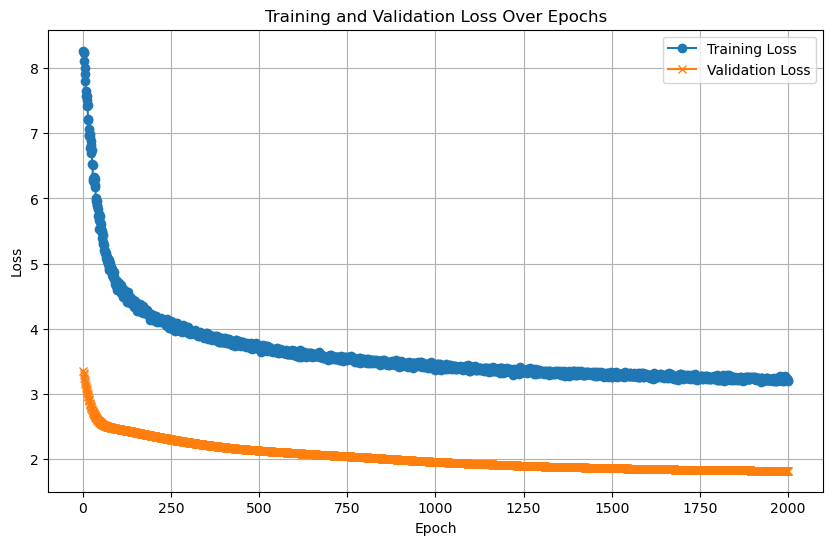

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/578], Loss: 5.9878
Test Batch [20/578], Loss: 6.0814
Test Batch [30/578], Loss: 6.0117
Test Batch [40/578], Loss: 5.8126
Test Batch [50/578], Loss: 5.8342
Test Batch [60/578], Loss: 5.9006
Test Batch [70/578], Loss: 6.0074
Test Batch [80/578], Loss: 5.6688
Test Batch [90/578], Loss: 5.9534
Test Batch [100/578], Loss: 5.9872
Test Batch [110/578], Loss: 5.9908
Test Batch [120/578], Loss: 5.9870
Test Batch [130/578], Loss: 5.9229
Test Batch [140/578], Loss: 6.0154
Test Batch [150/578], Loss: 6.0662


Test Batch [160/578], Loss: 6.0125
Test Batch [170/578], Loss: 6.1141
Test Batch [180/578], Loss: 6.2395
Test Batch [190/578], Loss: 5.7620
Test Batch [200/578], Loss: 5.8174
Test Batch [210/578], Loss: 5.8410
Test Batch [220/578], Loss: 5.7059
Test Batch [230/578], Loss: 5.7766
Test Batch [240/578], Loss: 5.6703
Test Batch [250/578], Loss: 5.7704
Test Batch [260/578], Loss: 5.9086


Test Batch [270/578], Loss: 5.9611
Test Batch [280/578], Loss: 6.1518
Test Batch [290/578], Loss: 5.7993
Test Batch [300/578], Loss: 5.7234
Test Batch [310/578], Loss: 5.6890
Test Batch [320/578], Loss: 5.4008
Test Batch [330/578], Loss: 5.3408
Test Batch [340/578], Loss: 5.3709
Test Batch [350/578], Loss: 5.3835
Test Batch [360/578], Loss: 5.3658
Test Batch [370/578], Loss: 5.8010
Test Batch [380/578], Loss: 6.1432
Test Batch [390/578], Loss: 5.4278
Test Batch [400/578], Loss: 5.3634


Test Batch [410/578], Loss: 5.4084
Test Batch [420/578], Loss: 5.4041
Test Batch [430/578], Loss: 5.5044
Test Batch [440/578], Loss: 5.4795
Test Batch [450/578], Loss: 5.3866
Test Batch [460/578], Loss: 5.6405
Test Batch [470/578], Loss: 5.3850
Test Batch [480/578], Loss: 6.1086
Test Batch [490/578], Loss: 5.1266
Test Batch [500/578], Loss: 5.1988
Test Batch [510/578], Loss: 5.1151
Test Batch [520/578], Loss: 4.7403
Test Batch [530/578], Loss: 4.9104
Test Batch [540/578], Loss: 6.2960
Test Batch [550/578], Loss: 6.1035


Test Batch [560/578], Loss: 6.2275
Test Batch [570/578], Loss: 6.1521

Test Loss: 5.7645


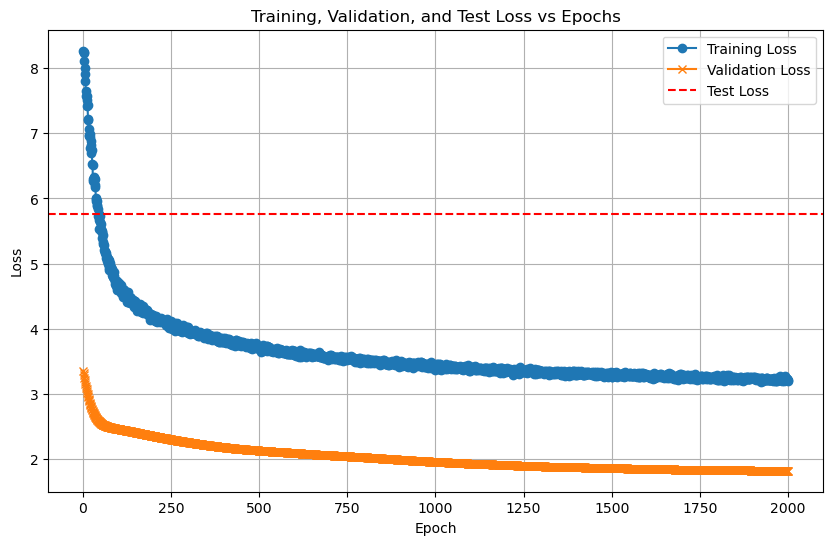

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.


  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.
  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.
  Processed batch 60/578 for test dataset.


  Processed batch 70/578 for test dataset.


  Processed batch 80/578 for test dataset.
  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.


  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.
  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.


  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.
  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.


  Processed batch 280/578 for test dataset.
  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.
  Processed batch 340/578 for test dataset.


  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.
  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.


  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.
  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.


  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.
  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.


  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 97.78%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45


LOG: Evaluating on the test set...
Test Accuracy: 96.00%

Test Classifica

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3672  |  Val Loss: 2.3066
Validation loss improved from inf to 2.3066.
[Epoch 2/1000] Train Loss: 2.3049  |  Val Loss: 2.2530
Validation loss improved from 2.3066 to 2.2530.
[Epoch 3/1000] Train Loss: 2.2466  |  Val Loss: 2.2011
Validation loss improved from 2.2530 to 2.2011.
[Epoch 4/1000] Train Loss: 2.1904  |  Val Loss: 2.1534
Validation loss improved from 2.2011 to 2.1534.
[Epoch 5/1000] Train Loss: 2.1420  |  Val Loss: 2.1094
Validation loss improved from 2.1534 to 2.1094.
[Epoch 6/1000] Train Loss: 2.0965  |  Val Loss: 2.0681
Validation loss improved from 2.1094 to 2.0681.
[Epoch 7/1000] Train Loss: 2.0508  |  Val Loss: 2.0292
Validation loss improved from 2.0681 to 2.0292.
[Epoch 8/1000] Train Loss: 2.0110  |  Val Loss: 1.9919
Validation loss improved from 2.0292 to 1.9919.
[Epoch 9/1000] Train Loss: 1.9703  |  Val Loss: 1.9562
Validation loss improved from 1.9919 to 1.9562.
[Epoch 10/1000] Train Loss: 1.9321  |  Val Loss: 1.9217
Validation loss impr

[Epoch 27/1000] Train Loss: 1.4780  |  Val Loss: 1.5043
Validation loss improved from 1.5234 to 1.5043.
[Epoch 28/1000] Train Loss: 1.4584  |  Val Loss: 1.4854
Validation loss improved from 1.5043 to 1.4854.
[Epoch 29/1000] Train Loss: 1.4391  |  Val Loss: 1.4667
Validation loss improved from 1.4854 to 1.4667.
[Epoch 30/1000] Train Loss: 1.4194  |  Val Loss: 1.4482
Validation loss improved from 1.4667 to 1.4482.
[Epoch 31/1000] Train Loss: 1.4007  |  Val Loss: 1.4298
Validation loss improved from 1.4482 to 1.4298.
[Epoch 32/1000] Train Loss: 1.3813  |  Val Loss: 1.4117
Validation loss improved from 1.4298 to 1.4117.
[Epoch 33/1000] Train Loss: 1.3628  |  Val Loss: 1.3937
Validation loss improved from 1.4117 to 1.3937.


[Epoch 34/1000] Train Loss: 1.3437  |  Val Loss: 1.3757
Validation loss improved from 1.3937 to 1.3757.
[Epoch 35/1000] Train Loss: 1.3253  |  Val Loss: 1.3577
Validation loss improved from 1.3757 to 1.3577.
[Epoch 36/1000] Train Loss: 1.3066  |  Val Loss: 1.3399
Validation loss improved from 1.3577 to 1.3399.
[Epoch 37/1000] Train Loss: 1.2878  |  Val Loss: 1.3222
Validation loss improved from 1.3399 to 1.3222.
[Epoch 38/1000] Train Loss: 1.2691  |  Val Loss: 1.3046
Validation loss improved from 1.3222 to 1.3046.
[Epoch 39/1000] Train Loss: 1.2509  |  Val Loss: 1.2872
Validation loss improved from 1.3046 to 1.2872.
[Epoch 40/1000] Train Loss: 1.2323  |  Val Loss: 1.2699
Validation loss improved from 1.2872 to 1.2699.
[Epoch 41/1000] Train Loss: 1.2142  |  Val Loss: 1.2528
Validation loss improved from 1.2699 to 1.2528.
[Epoch 42/1000] Train Loss: 1.1959  |  Val Loss: 1.2360
Validation loss improved from 1.2528 to 1.2360.
[Epoch 43/1000] Train Loss: 1.1781  |  Val Loss: 1.2195
Validati

[Epoch 59/1000] Train Loss: 0.9260  |  Val Loss: 0.9859
Validation loss improved from 0.9987 to 0.9859.
[Epoch 60/1000] Train Loss: 0.9125  |  Val Loss: 0.9731
Validation loss improved from 0.9859 to 0.9731.
[Epoch 61/1000] Train Loss: 0.8995  |  Val Loss: 0.9605
Validation loss improved from 0.9731 to 0.9605.
[Epoch 62/1000] Train Loss: 0.8861  |  Val Loss: 0.9482
Validation loss improved from 0.9605 to 0.9482.
[Epoch 63/1000] Train Loss: 0.8727  |  Val Loss: 0.9362
Validation loss improved from 0.9482 to 0.9362.
[Epoch 64/1000] Train Loss: 0.8598  |  Val Loss: 0.9241
Validation loss improved from 0.9362 to 0.9241.
[Epoch 65/1000] Train Loss: 0.8471  |  Val Loss: 0.9125
Validation loss improved from 0.9241 to 0.9125.


[Epoch 66/1000] Train Loss: 0.8352  |  Val Loss: 0.9011
Validation loss improved from 0.9125 to 0.9011.
[Epoch 67/1000] Train Loss: 0.8226  |  Val Loss: 0.8899
Validation loss improved from 0.9011 to 0.8899.
[Epoch 68/1000] Train Loss: 0.8109  |  Val Loss: 0.8789
Validation loss improved from 0.8899 to 0.8789.
[Epoch 69/1000] Train Loss: 0.7990  |  Val Loss: 0.8680
Validation loss improved from 0.8789 to 0.8680.
[Epoch 70/1000] Train Loss: 0.7874  |  Val Loss: 0.8573
Validation loss improved from 0.8680 to 0.8573.
[Epoch 71/1000] Train Loss: 0.7761  |  Val Loss: 0.8467
Validation loss improved from 0.8573 to 0.8467.
[Epoch 72/1000] Train Loss: 0.7653  |  Val Loss: 0.8363
Validation loss improved from 0.8467 to 0.8363.
[Epoch 73/1000] Train Loss: 0.7542  |  Val Loss: 0.8260
Validation loss improved from 0.8363 to 0.8260.
[Epoch 74/1000] Train Loss: 0.7433  |  Val Loss: 0.8158
Validation loss improved from 0.8260 to 0.8158.
[Epoch 75/1000] Train Loss: 0.7327  |  Val Loss: 0.8058
Validati

[Epoch 93/1000] Train Loss: 0.5674  |  Val Loss: 0.6509
Validation loss improved from 0.6585 to 0.6509.
[Epoch 94/1000] Train Loss: 0.5595  |  Val Loss: 0.6435
Validation loss improved from 0.6509 to 0.6435.
[Epoch 95/1000] Train Loss: 0.5519  |  Val Loss: 0.6360
Validation loss improved from 0.6435 to 0.6360.
[Epoch 96/1000] Train Loss: 0.5445  |  Val Loss: 0.6286
Validation loss improved from 0.6360 to 0.6286.
[Epoch 97/1000] Train Loss: 0.5369  |  Val Loss: 0.6215
Validation loss improved from 0.6286 to 0.6215.
[Epoch 98/1000] Train Loss: 0.5299  |  Val Loss: 0.6144
Validation loss improved from 0.6215 to 0.6144.
[Epoch 99/1000] Train Loss: 0.5226  |  Val Loss: 0.6075
Validation loss improved from 0.6144 to 0.6075.
[Epoch 100/1000] Train Loss: 0.5157  |  Val Loss: 0.6006
Validation loss improved from 0.6075 to 0.6006.
[Epoch 101/1000] Train Loss: 0.5088  |  Val Loss: 0.5940
Validation loss improved from 0.6006 to 0.5940.


[Epoch 102/1000] Train Loss: 0.5022  |  Val Loss: 0.5875
Validation loss improved from 0.5940 to 0.5875.
[Epoch 103/1000] Train Loss: 0.4955  |  Val Loss: 0.5809
Validation loss improved from 0.5875 to 0.5809.
[Epoch 104/1000] Train Loss: 0.4891  |  Val Loss: 0.5745
Validation loss improved from 0.5809 to 0.5745.
[Epoch 105/1000] Train Loss: 0.4828  |  Val Loss: 0.5681
Validation loss improved from 0.5745 to 0.5681.
[Epoch 106/1000] Train Loss: 0.4764  |  Val Loss: 0.5619
Validation loss improved from 0.5681 to 0.5619.
[Epoch 107/1000] Train Loss: 0.4703  |  Val Loss: 0.5560
Validation loss improved from 0.5619 to 0.5560.
[Epoch 108/1000] Train Loss: 0.4644  |  Val Loss: 0.5500
Validation loss improved from 0.5560 to 0.5500.
[Epoch 109/1000] Train Loss: 0.4585  |  Val Loss: 0.5443
Validation loss improved from 0.5500 to 0.5443.
[Epoch 110/1000] Train Loss: 0.4527  |  Val Loss: 0.5386
Validation loss improved from 0.5443 to 0.5386.
[Epoch 111/1000] Train Loss: 0.4472  |  Val Loss: 0.532

[Epoch 126/1000] Train Loss: 0.3749  |  Val Loss: 0.4587
Validation loss improved from 0.4630 to 0.4587.
[Epoch 127/1000] Train Loss: 0.3710  |  Val Loss: 0.4545
Validation loss improved from 0.4587 to 0.4545.
[Epoch 128/1000] Train Loss: 0.3669  |  Val Loss: 0.4501
Validation loss improved from 0.4545 to 0.4501.
[Epoch 129/1000] Train Loss: 0.3630  |  Val Loss: 0.4461
Validation loss improved from 0.4501 to 0.4461.
[Epoch 130/1000] Train Loss: 0.3592  |  Val Loss: 0.4419
Validation loss improved from 0.4461 to 0.4419.
[Epoch 131/1000] Train Loss: 0.3551  |  Val Loss: 0.4378
Validation loss improved from 0.4419 to 0.4378.
[Epoch 132/1000] Train Loss: 0.3514  |  Val Loss: 0.4337
Validation loss improved from 0.4378 to 0.4337.
[Epoch 133/1000] Train Loss: 0.3479  |  Val Loss: 0.4295
Validation loss improved from 0.4337 to 0.4295.


[Epoch 134/1000] Train Loss: 0.3442  |  Val Loss: 0.4255
Validation loss improved from 0.4295 to 0.4255.
[Epoch 135/1000] Train Loss: 0.3405  |  Val Loss: 0.4216
Validation loss improved from 0.4255 to 0.4216.
[Epoch 136/1000] Train Loss: 0.3371  |  Val Loss: 0.4178
Validation loss improved from 0.4216 to 0.4178.
[Epoch 137/1000] Train Loss: 0.3335  |  Val Loss: 0.4139
Validation loss improved from 0.4178 to 0.4139.
[Epoch 138/1000] Train Loss: 0.3301  |  Val Loss: 0.4101
Validation loss improved from 0.4139 to 0.4101.
[Epoch 139/1000] Train Loss: 0.3267  |  Val Loss: 0.4063
Validation loss improved from 0.4101 to 0.4063.
[Epoch 140/1000] Train Loss: 0.3233  |  Val Loss: 0.4026
Validation loss improved from 0.4063 to 0.4026.
[Epoch 141/1000] Train Loss: 0.3199  |  Val Loss: 0.3991
Validation loss improved from 0.4026 to 0.3991.
[Epoch 142/1000] Train Loss: 0.3167  |  Val Loss: 0.3955
Validation loss improved from 0.3991 to 0.3955.
[Epoch 143/1000] Train Loss: 0.3136  |  Val Loss: 0.391

[Epoch 156/1000] Train Loss: 0.2761  |  Val Loss: 0.3507
Validation loss improved from 0.3538 to 0.3507.
[Epoch 157/1000] Train Loss: 0.2735  |  Val Loss: 0.3477
Validation loss improved from 0.3507 to 0.3477.
[Epoch 158/1000] Train Loss: 0.2710  |  Val Loss: 0.3448
Validation loss improved from 0.3477 to 0.3448.
[Epoch 159/1000] Train Loss: 0.2683  |  Val Loss: 0.3420
Validation loss improved from 0.3448 to 0.3420.
[Epoch 160/1000] Train Loss: 0.2658  |  Val Loss: 0.3391
Validation loss improved from 0.3420 to 0.3391.
[Epoch 161/1000] Train Loss: 0.2632  |  Val Loss: 0.3360
Validation loss improved from 0.3391 to 0.3360.


[Epoch 162/1000] Train Loss: 0.2607  |  Val Loss: 0.3332
Validation loss improved from 0.3360 to 0.3332.
[Epoch 163/1000] Train Loss: 0.2582  |  Val Loss: 0.3304
Validation loss improved from 0.3332 to 0.3304.
[Epoch 164/1000] Train Loss: 0.2557  |  Val Loss: 0.3277
Validation loss improved from 0.3304 to 0.3277.
[Epoch 165/1000] Train Loss: 0.2532  |  Val Loss: 0.3248
Validation loss improved from 0.3277 to 0.3248.
[Epoch 166/1000] Train Loss: 0.2508  |  Val Loss: 0.3218
Validation loss improved from 0.3248 to 0.3218.
[Epoch 167/1000] Train Loss: 0.2482  |  Val Loss: 0.3191
Validation loss improved from 0.3218 to 0.3191.
[Epoch 168/1000] Train Loss: 0.2460  |  Val Loss: 0.3162
Validation loss improved from 0.3191 to 0.3162.
[Epoch 169/1000] Train Loss: 0.2435  |  Val Loss: 0.3134
Validation loss improved from 0.3162 to 0.3134.
[Epoch 170/1000] Train Loss: 0.2412  |  Val Loss: 0.3109
Validation loss improved from 0.3134 to 0.3109.
[Epoch 171/1000] Train Loss: 0.2387  |  Val Loss: 0.308

[Epoch 186/1000] Train Loss: 0.2062  |  Val Loss: 0.2701
Validation loss improved from 0.2725 to 0.2701.
[Epoch 187/1000] Train Loss: 0.2040  |  Val Loss: 0.2678
Validation loss improved from 0.2701 to 0.2678.
[Epoch 188/1000] Train Loss: 0.2020  |  Val Loss: 0.2655
Validation loss improved from 0.2678 to 0.2655.
[Epoch 189/1000] Train Loss: 0.2001  |  Val Loss: 0.2633
Validation loss improved from 0.2655 to 0.2633.
[Epoch 190/1000] Train Loss: 0.1980  |  Val Loss: 0.2608
Validation loss improved from 0.2633 to 0.2608.
[Epoch 191/1000] Train Loss: 0.1961  |  Val Loss: 0.2585
Validation loss improved from 0.2608 to 0.2585.


[Epoch 192/1000] Train Loss: 0.1942  |  Val Loss: 0.2563
Validation loss improved from 0.2585 to 0.2563.
[Epoch 193/1000] Train Loss: 0.1921  |  Val Loss: 0.2542
Validation loss improved from 0.2563 to 0.2542.
[Epoch 194/1000] Train Loss: 0.1903  |  Val Loss: 0.2521
Validation loss improved from 0.2542 to 0.2521.
[Epoch 195/1000] Train Loss: 0.1883  |  Val Loss: 0.2497
Validation loss improved from 0.2521 to 0.2497.
[Epoch 196/1000] Train Loss: 0.1865  |  Val Loss: 0.2474
Validation loss improved from 0.2497 to 0.2474.
[Epoch 197/1000] Train Loss: 0.1845  |  Val Loss: 0.2451
Validation loss improved from 0.2474 to 0.2451.
[Epoch 198/1000] Train Loss: 0.1827  |  Val Loss: 0.2429
Validation loss improved from 0.2451 to 0.2429.
[Epoch 199/1000] Train Loss: 0.1809  |  Val Loss: 0.2407
Validation loss improved from 0.2429 to 0.2407.
[Epoch 200/1000] Train Loss: 0.1790  |  Val Loss: 0.2388
Validation loss improved from 0.2407 to 0.2388.
[Epoch 201/1000] Train Loss: 0.1772  |  Val Loss: 0.236

[Epoch 219/1000] Train Loss: 0.1467  |  Val Loss: 0.2016
Validation loss improved from 0.2034 to 0.2016.
[Epoch 220/1000] Train Loss: 0.1453  |  Val Loss: 0.1996
Validation loss improved from 0.2016 to 0.1996.
[Epoch 221/1000] Train Loss: 0.1436  |  Val Loss: 0.1980
Validation loss improved from 0.1996 to 0.1980.
[Epoch 222/1000] Train Loss: 0.1421  |  Val Loss: 0.1964
Validation loss improved from 0.1980 to 0.1964.
[Epoch 223/1000] Train Loss: 0.1407  |  Val Loss: 0.1946
Validation loss improved from 0.1964 to 0.1946.
[Epoch 224/1000] Train Loss: 0.1391  |  Val Loss: 0.1930
Validation loss improved from 0.1946 to 0.1930.
[Epoch 225/1000] Train Loss: 0.1378  |  Val Loss: 0.1913
Validation loss improved from 0.1930 to 0.1913.


[Epoch 226/1000] Train Loss: 0.1364  |  Val Loss: 0.1895
Validation loss improved from 0.1913 to 0.1895.
[Epoch 227/1000] Train Loss: 0.1348  |  Val Loss: 0.1879
Validation loss improved from 0.1895 to 0.1879.
[Epoch 228/1000] Train Loss: 0.1334  |  Val Loss: 0.1865
Validation loss improved from 0.1879 to 0.1865.
[Epoch 229/1000] Train Loss: 0.1321  |  Val Loss: 0.1849
Validation loss improved from 0.1865 to 0.1849.
[Epoch 230/1000] Train Loss: 0.1306  |  Val Loss: 0.1834
Validation loss improved from 0.1849 to 0.1834.
[Epoch 231/1000] Train Loss: 0.1292  |  Val Loss: 0.1817
Validation loss improved from 0.1834 to 0.1817.
[Epoch 232/1000] Train Loss: 0.1278  |  Val Loss: 0.1801
Validation loss improved from 0.1817 to 0.1801.
[Epoch 233/1000] Train Loss: 0.1266  |  Val Loss: 0.1785
Validation loss improved from 0.1801 to 0.1785.
[Epoch 234/1000] Train Loss: 0.1252  |  Val Loss: 0.1769
Validation loss improved from 0.1785 to 0.1769.
[Epoch 235/1000] Train Loss: 0.1240  |  Val Loss: 0.175

[Epoch 253/1000] Train Loss: 0.1027  |  Val Loss: 0.1516
Validation loss improved from 0.1529 to 0.1516.
[Epoch 254/1000] Train Loss: 0.1017  |  Val Loss: 0.1505
Validation loss improved from 0.1516 to 0.1505.
[Epoch 255/1000] Train Loss: 0.1006  |  Val Loss: 0.1492
Validation loss improved from 0.1505 to 0.1492.
[Epoch 256/1000] Train Loss: 0.0996  |  Val Loss: 0.1480
Validation loss improved from 0.1492 to 0.1480.
[Epoch 257/1000] Train Loss: 0.0986  |  Val Loss: 0.1468
Validation loss improved from 0.1480 to 0.1468.
[Epoch 258/1000] Train Loss: 0.0975  |  Val Loss: 0.1456
Validation loss improved from 0.1468 to 0.1456.
[Epoch 259/1000] Train Loss: 0.0966  |  Val Loss: 0.1444
Validation loss improved from 0.1456 to 0.1444.


[Epoch 260/1000] Train Loss: 0.0956  |  Val Loss: 0.1433
Validation loss improved from 0.1444 to 0.1433.
[Epoch 261/1000] Train Loss: 0.0947  |  Val Loss: 0.1423
Validation loss improved from 0.1433 to 0.1423.
[Epoch 262/1000] Train Loss: 0.0938  |  Val Loss: 0.1413
Validation loss improved from 0.1423 to 0.1413.
[Epoch 263/1000] Train Loss: 0.0929  |  Val Loss: 0.1400
Validation loss improved from 0.1413 to 0.1400.
[Epoch 264/1000] Train Loss: 0.0919  |  Val Loss: 0.1390
Validation loss improved from 0.1400 to 0.1390.
[Epoch 265/1000] Train Loss: 0.0910  |  Val Loss: 0.1381
Validation loss improved from 0.1390 to 0.1381.
[Epoch 266/1000] Train Loss: 0.0902  |  Val Loss: 0.1370
Validation loss improved from 0.1381 to 0.1370.
[Epoch 267/1000] Train Loss: 0.0894  |  Val Loss: 0.1361
Validation loss improved from 0.1370 to 0.1361.
[Epoch 268/1000] Train Loss: 0.0885  |  Val Loss: 0.1351
Validation loss improved from 0.1361 to 0.1351.
[Epoch 269/1000] Train Loss: 0.0876  |  Val Loss: 0.134

[Epoch 285/1000] Train Loss: 0.0755  |  Val Loss: 0.1206
Validation loss improved from 0.1213 to 0.1206.
[Epoch 286/1000] Train Loss: 0.0747  |  Val Loss: 0.1199
Validation loss improved from 0.1206 to 0.1199.
[Epoch 287/1000] Train Loss: 0.0741  |  Val Loss: 0.1190
Validation loss improved from 0.1199 to 0.1190.
[Epoch 288/1000] Train Loss: 0.0734  |  Val Loss: 0.1182
Validation loss improved from 0.1190 to 0.1182.
[Epoch 289/1000] Train Loss: 0.0728  |  Val Loss: 0.1176
Validation loss improved from 0.1182 to 0.1176.
[Epoch 290/1000] Train Loss: 0.0721  |  Val Loss: 0.1168
Validation loss improved from 0.1176 to 0.1168.
[Epoch 291/1000] Train Loss: 0.0716  |  Val Loss: 0.1160
Validation loss improved from 0.1168 to 0.1160.
[Epoch 292/1000] Train Loss: 0.0710  |  Val Loss: 0.1153
Validation loss improved from 0.1160 to 0.1153.


[Epoch 293/1000] Train Loss: 0.0704  |  Val Loss: 0.1145
Validation loss improved from 0.1153 to 0.1145.
[Epoch 294/1000] Train Loss: 0.0697  |  Val Loss: 0.1139
Validation loss improved from 0.1145 to 0.1139.
[Epoch 295/1000] Train Loss: 0.0691  |  Val Loss: 0.1133
Validation loss improved from 0.1139 to 0.1133.
[Epoch 296/1000] Train Loss: 0.0685  |  Val Loss: 0.1126
Validation loss improved from 0.1133 to 0.1126.
[Epoch 297/1000] Train Loss: 0.0680  |  Val Loss: 0.1121
Validation loss improved from 0.1126 to 0.1121.
[Epoch 298/1000] Train Loss: 0.0675  |  Val Loss: 0.1113
Validation loss improved from 0.1121 to 0.1113.
[Epoch 299/1000] Train Loss: 0.0668  |  Val Loss: 0.1106
Validation loss improved from 0.1113 to 0.1106.
[Epoch 300/1000] Train Loss: 0.0664  |  Val Loss: 0.1101
Validation loss improved from 0.1106 to 0.1101.
[Epoch 301/1000] Train Loss: 0.0658  |  Val Loss: 0.1094
Validation loss improved from 0.1101 to 0.1094.
[Epoch 302/1000] Train Loss: 0.0652  |  Val Loss: 0.108

[Epoch 314/1000] Train Loss: 0.0594  |  Val Loss: 0.1019
Validation loss improved from 0.1024 to 0.1019.
[Epoch 315/1000] Train Loss: 0.0589  |  Val Loss: 0.1015
Validation loss improved from 0.1019 to 0.1015.
[Epoch 316/1000] Train Loss: 0.0586  |  Val Loss: 0.1010
Validation loss improved from 0.1015 to 0.1010.
[Epoch 317/1000] Train Loss: 0.0581  |  Val Loss: 0.1005
Validation loss improved from 0.1010 to 0.1005.
[Epoch 318/1000] Train Loss: 0.0576  |  Val Loss: 0.1000
Validation loss improved from 0.1005 to 0.1000.
[Epoch 319/1000] Train Loss: 0.0572  |  Val Loss: 0.0994
Validation loss improved from 0.1000 to 0.0994.
[Epoch 320/1000] Train Loss: 0.0568  |  Val Loss: 0.0989
Validation loss improved from 0.0994 to 0.0989.
[Epoch 321/1000] Train Loss: 0.0565  |  Val Loss: 0.0984
Validation loss improved from 0.0989 to 0.0984.


[Epoch 322/1000] Train Loss: 0.0560  |  Val Loss: 0.0979
Validation loss improved from 0.0984 to 0.0979.
[Epoch 323/1000] Train Loss: 0.0556  |  Val Loss: 0.0973
Validation loss improved from 0.0979 to 0.0973.
[Epoch 324/1000] Train Loss: 0.0553  |  Val Loss: 0.0968
Validation loss improved from 0.0973 to 0.0968.
[Epoch 325/1000] Train Loss: 0.0548  |  Val Loss: 0.0963
Validation loss improved from 0.0968 to 0.0963.
[Epoch 326/1000] Train Loss: 0.0544  |  Val Loss: 0.0958
Validation loss improved from 0.0963 to 0.0958.
[Epoch 327/1000] Train Loss: 0.0541  |  Val Loss: 0.0953
Validation loss improved from 0.0958 to 0.0953.
[Epoch 328/1000] Train Loss: 0.0537  |  Val Loss: 0.0948
Validation loss improved from 0.0953 to 0.0948.
[Epoch 329/1000] Train Loss: 0.0534  |  Val Loss: 0.0944
Validation loss improved from 0.0948 to 0.0944.
[Epoch 330/1000] Train Loss: 0.0529  |  Val Loss: 0.0940
Validation loss improved from 0.0944 to 0.0940.
[Epoch 331/1000] Train Loss: 0.0528  |  Val Loss: 0.093

[Epoch 343/1000] Train Loss: 0.0487  |  Val Loss: 0.0893
Validation loss improved from 0.0897 to 0.0893.
[Epoch 344/1000] Train Loss: 0.0484  |  Val Loss: 0.0889
Validation loss improved from 0.0893 to 0.0889.
[Epoch 345/1000] Train Loss: 0.0482  |  Val Loss: 0.0887
Validation loss improved from 0.0889 to 0.0887.
[Epoch 346/1000] Train Loss: 0.0478  |  Val Loss: 0.0882
Validation loss improved from 0.0887 to 0.0882.
[Epoch 347/1000] Train Loss: 0.0477  |  Val Loss: 0.0878
Validation loss improved from 0.0882 to 0.0878.
[Epoch 348/1000] Train Loss: 0.0474  |  Val Loss: 0.0875
Validation loss improved from 0.0878 to 0.0875.
[Epoch 349/1000] Train Loss: 0.0471  |  Val Loss: 0.0872
Validation loss improved from 0.0875 to 0.0872.
[Epoch 350/1000] Train Loss: 0.0468  |  Val Loss: 0.0869
Validation loss improved from 0.0872 to 0.0869.
[Epoch 351/1000] Train Loss: 0.0466  |  Val Loss: 0.0866
Validation loss improved from 0.0869 to 0.0866.


[Epoch 352/1000] Train Loss: 0.0462  |  Val Loss: 0.0863
Validation loss improved from 0.0866 to 0.0863.
[Epoch 353/1000] Train Loss: 0.0460  |  Val Loss: 0.0860
Validation loss improved from 0.0863 to 0.0860.
[Epoch 354/1000] Train Loss: 0.0457  |  Val Loss: 0.0858
Validation loss improved from 0.0860 to 0.0858.
[Epoch 355/1000] Train Loss: 0.0455  |  Val Loss: 0.0854
Validation loss improved from 0.0858 to 0.0854.
[Epoch 356/1000] Train Loss: 0.0452  |  Val Loss: 0.0851
Validation loss improved from 0.0854 to 0.0851.
[Epoch 357/1000] Train Loss: 0.0450  |  Val Loss: 0.0848
Validation loss improved from 0.0851 to 0.0848.
[Epoch 358/1000] Train Loss: 0.0449  |  Val Loss: 0.0844
Validation loss improved from 0.0848 to 0.0844.
[Epoch 359/1000] Train Loss: 0.0446  |  Val Loss: 0.0843
Validation loss improved from 0.0844 to 0.0843.
[Epoch 360/1000] Train Loss: 0.0442  |  Val Loss: 0.0840
Validation loss improved from 0.0843 to 0.0840.
[Epoch 361/1000] Train Loss: 0.0440  |  Val Loss: 0.083

[Epoch 379/1000] Train Loss: 0.0401  |  Val Loss: 0.0795
Validation loss improved from 0.0798 to 0.0795.
[Epoch 380/1000] Train Loss: 0.0399  |  Val Loss: 0.0792
Validation loss improved from 0.0795 to 0.0792.
[Epoch 381/1000] Train Loss: 0.0398  |  Val Loss: 0.0791
Validation loss improved from 0.0792 to 0.0791.
[Epoch 382/1000] Train Loss: 0.0396  |  Val Loss: 0.0789
Validation loss improved from 0.0791 to 0.0789.
[Epoch 383/1000] Train Loss: 0.0394  |  Val Loss: 0.0788
Validation loss improved from 0.0789 to 0.0788.
[Epoch 384/1000] Train Loss: 0.0392  |  Val Loss: 0.0786
Validation loss improved from 0.0788 to 0.0786.


[Epoch 385/1000] Train Loss: 0.0392  |  Val Loss: 0.0782
Validation loss improved from 0.0786 to 0.0782.
[Epoch 386/1000] Train Loss: 0.0389  |  Val Loss: 0.0780
Validation loss improved from 0.0782 to 0.0780.
[Epoch 387/1000] Train Loss: 0.0387  |  Val Loss: 0.0778
Validation loss improved from 0.0780 to 0.0778.
[Epoch 388/1000] Train Loss: 0.0386  |  Val Loss: 0.0777
Validation loss improved from 0.0778 to 0.0777.
[Epoch 389/1000] Train Loss: 0.0383  |  Val Loss: 0.0775
Validation loss improved from 0.0777 to 0.0775.
[Epoch 390/1000] Train Loss: 0.0382  |  Val Loss: 0.0774
Validation loss improved from 0.0775 to 0.0774.
[Epoch 391/1000] Train Loss: 0.0381  |  Val Loss: 0.0772
Validation loss improved from 0.0774 to 0.0772.
[Epoch 392/1000] Train Loss: 0.0378  |  Val Loss: 0.0772
Validation loss improved from 0.0772 to 0.0772.
[Epoch 393/1000] Train Loss: 0.0377  |  Val Loss: 0.0770
Validation loss improved from 0.0772 to 0.0770.
[Epoch 394/1000] Train Loss: 0.0375  |  Val Loss: 0.077

[Epoch 409/1000] Train Loss: 0.0354  |  Val Loss: 0.0744
Validation loss improved from 0.0744 to 0.0744.
[Epoch 410/1000] Train Loss: 0.0352  |  Val Loss: 0.0743
Validation loss improved from 0.0744 to 0.0743.
[Epoch 411/1000] Train Loss: 0.0351  |  Val Loss: 0.0741
Validation loss improved from 0.0743 to 0.0741.
[Epoch 412/1000] Train Loss: 0.0350  |  Val Loss: 0.0741
Validation loss improved from 0.0741 to 0.0741.
[Epoch 413/1000] Train Loss: 0.0349  |  Val Loss: 0.0743
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 414/1000] Train Loss: 0.0347  |  Val Loss: 0.0742
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 415/1000] Train Loss: 0.0346  |  Val Loss: 0.0743
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 416/1000] Train Loss: 0.0344  |  Val Loss: 0.0742
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 417/1000] Train Loss: 0.0343  |  Val Loss: 0.0740
Validation loss improved from 0.0741 to 0.0740.
[Epoch 418/1000] Train Loss: 0.0341  |  Val Loss: 0.0739
Validation loss improved from 0.0740 to 0.0739.
[Epoch 419/1000] Train Loss: 0.0340  |  Val Loss: 0.0736
Validation loss improved from 0.0739 to 0.0736.
[Epoch 420/1000] Train Loss: 0.0340  |  Val Loss: 0.0734
Validation loss improved from 0.0736 to 0.0734.
[Epoch 421/1000] Train Loss: 0.0338  |  Val Loss: 0.0732
Validation loss improved from 0.0734 to 0.0732.
[Epoch 422/1000] Train Loss: 0.0338  |  Val Loss: 0.0731
Validation loss improved from 0.0732 to 0.0731.
[Epoch 423/1000] Train Loss: 0.0337  

[Epoch 441/1000] Train Loss: 0.0317  |  Val Loss: 0.0710
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 442/1000] Train Loss: 0.0316  |  Val Loss: 0.0712
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 443/1000] Train Loss: 0.0315  |  Val Loss: 0.0710
Validation loss improved from 0.0710 to 0.0710.
[Epoch 444/1000] Train Loss: 0.0315  |  Val Loss: 0.0710
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 445/1000] Train Loss: 0.0314  |  Val Loss: 0.0709
Validation loss improved from 0.0710 to 0.0709.
[Epoch 446/1000] Train Loss: 0.0315  |  Val Loss: 0.0705
Validation loss improved from 0.0709 to 0.0705.
[Epoch 447/1000] Train Loss: 0.0312  |  Val Loss: 0.0703
Validation loss improved from 0.0705 to 0.0703.
[Epoch 448/1000] Train Loss: 0.0311  |  Val Loss: 0.0703
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 449/1000] Train Loss: 0.0311  |  Val Loss: 0.0704
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 450/1000] Train Lo

[Epoch 470/1000] Train Loss: 0.0295  |  Val Loss: 0.0679
Validation loss improved from 0.0680 to 0.0679.
[Epoch 471/1000] Train Loss: 0.0292  |  Val Loss: 0.0680
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 472/1000] Train Loss: 0.0292  |  Val Loss: 0.0680
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 473/1000] Train Loss: 0.0292  |  Val Loss: 0.0680
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 474/1000] Train Loss: 0.0291  |  Val Loss: 0.0680
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 475/1000] Train Loss: 0.0290  |  Val Loss: 0.0680
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 476/1000] Train Loss: 0.0290  |  Val Loss: 0.0682
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 477/1000] Train Loss: 0.0289  |  Val Loss: 0.0681
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 478/1000] Train Loss: 0.0289  |  Val Loss: 0.0677
Validation loss improved from 0.0679 to 0.0677.
[Epoch 479/10

[Epoch 504/1000] Train Loss: 0.0272  |  Val Loss: 0.0665
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 505/1000] Train Loss: 0.0272  |  Val Loss: 0.0669
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 506/1000] Train Loss: 0.0271  |  Val Loss: 0.0669
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 507/1000] Train Loss: 0.0272  |  Val Loss: 0.0670
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 508/1000] Train Loss: 0.0272  |  Val Loss: 0.0665
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 509/1000] Train Loss: 0.0269  |  Val Loss: 0.0661
Validation loss improved from 0.0663 to 0.0661.
[Epoch 510/1000] Train Loss: 0.0270  |  Val Loss: 0.0657
Validation loss improved from 0.0661 to 0.0657.
[Epoch 511/1000] Train Loss: 0.0269  |  Val Loss: 0.0654
Validation loss improved from 0.0657 to 0.0654.
[Epoch 512/1000] Train Loss: 0.0271  |  Val Loss: 0.0646
Validation loss improved from 0.0654 to 0.0646.
[Epoch 513/1000] Train Lo

[Epoch 537/1000] Train Loss: 0.0256  |  Val Loss: 0.0649
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 538/1000] Train Loss: 0.0258  |  Val Loss: 0.0651
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 539/1000] Train Loss: 0.0256  |  Val Loss: 0.0649
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 540/1000] Train Loss: 0.0255  |  Val Loss: 0.0648
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 541/1000] Train Loss: 0.0254  |  Val Loss: 0.0647
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 542/1000] Train Loss: 0.0253  |  Val Loss: 0.0646
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 543/1000] Train Loss: 0.0254  |  Val Loss: 0.0642
Validation loss improved from 0.0646 to 0.0642.
[Epoch 544/1000] Train Loss: 0.0254  |  Val Loss: 0.0640
Validation loss improved from 0.0642 to 0.0640.
[Epoch 545/1000] Train Loss: 0.0252  |  Val Loss: 0.0639
Validation loss improved from 0.0640 to 0.0639.
[Epoch 546/10

[Epoch 566/1000] Train Loss: 0.0243  |  Val Loss: 0.0636
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 567/1000] Train Loss: 0.0244  |  Val Loss: 0.0635
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 568/1000] Train Loss: 0.0244  |  Val Loss: 0.0630
Validation loss improved from 0.0634 to 0.0630.
[Epoch 569/1000] Train Loss: 0.0243  |  Val Loss: 0.0630
Validation loss improved from 0.0630 to 0.0630.
[Epoch 570/1000] Train Loss: 0.0243  |  Val Loss: 0.0630
Validation loss improved from 0.0630 to 0.0630.
[Epoch 571/1000] Train Loss: 0.0242  |  Val Loss: 0.0631
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 572/1000] Train Loss: 0.0242  |  Val Loss: 0.0639
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 573/1000] Train Loss: 0.0242  |  Val Loss: 0.0645
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 574/1000] Train Loss: 0.0242  |  Val Loss: 0.0642
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 575/1000] 

[Epoch 593/1000] Train Loss: 0.0234  |  Val Loss: 0.0624
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 594/1000] Train Loss: 0.0234  |  Val Loss: 0.0627
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 595/1000] Train Loss: 0.0234  |  Val Loss: 0.0627
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 596/1000] Train Loss: 0.0233  |  Val Loss: 0.0625
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 597/1000] Train Loss: 0.0232  |  Val Loss: 0.0627
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 598/1000] Train Loss: 0.0232  |  Val Loss: 0.0624
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 599/1000] Train Loss: 0.0232  |  Val Loss: 0.0626
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 600/1000] Train Loss: 0.0232  |  Val Loss: 0.0626
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 601/1000] Train Loss: 0.0232  |  Val Loss: 0.0622
Validation loss improved from 0.0624 to 0.0622.
[Epoch 

[Epoch 623/1000] Train Loss: 0.0225  |  Val Loss: 0.0630
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 624/1000] Train Loss: 0.0225  |  Val Loss: 0.0631
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 625/1000] Train Loss: 0.0224  |  Val Loss: 0.0628
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 626/1000] Train Loss: 0.0224  |  Val Loss: 0.0626
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 627/1000] Train Loss: 0.0224  |  Val Loss: 0.0624
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 628/1000] Train Loss: 0.0224  |  Val Loss: 0.0627
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 629/1000] Train Loss: 0.0223  |  Val Loss: 0.0630
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 630/1000] Train Loss: 0.0225  |  Val Loss: 0.0629
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 631/1000] Train Loss: 0.0224  |  Val Loss: 0.0622
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 655/1000] Train Loss: 0.0219  |  Val Loss: 0.0626
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 656/1000] Train Loss: 0.0218  |  Val Loss: 0.0625
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 657/1000] Train Loss: 0.0217  |  Val Loss: 0.0623
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 658/1000] Train Loss: 0.0217  |  Val Loss: 0.0622
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 659/1000] Train Loss: 0.0217  |  Val Loss: 0.0620
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 660/1000] Train Loss: 0.0216  |  Val Loss: 0.0622
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 661/1000] Train Loss: 0.0216  |  Val Loss: 0.0628
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 662/1000] Train Loss: 0.0214  |  Val Loss: 0.0627
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 663/1000] Train Loss: 0.0215  |  Val Loss: 0.0623
!! Validation loss did NOT improve !! Patience:

[Epoch 687/1000] Train Loss: 0.0209  |  Val Loss: 0.0615
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 688/1000] Train Loss: 0.0209  |  Val Loss: 0.0616
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 689/1000] Train Loss: 0.0208  |  Val Loss: 0.0615
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 690/1000] Train Loss: 0.0212  |  Val Loss: 0.0615
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 691/1000] Train Loss: 0.0210  |  Val Loss: 0.0618
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 692/1000] Train Loss: 0.0210  |  Val Loss: 0.0611
Validation loss improved from 0.0611 to 0.0611.
[Epoch 693/1000] Train Loss: 0.0211  |  Val Loss: 0.0603
Validation loss improved from 0.0611 to 0.0603.
[Epoch 694/1000] Train Loss: 0.0208  |  Val Loss: 0.0604
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 695/1000] Train Loss: 0.0209  |  Val Loss: 0.0608
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 6

[Epoch 717/1000] Train Loss: 0.0204  |  Val Loss: 0.0613
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 718/1000] Train Loss: 0.0203  |  Val Loss: 0.0609
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 719/1000] Train Loss: 0.0204  |  Val Loss: 0.0606
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 720/1000] Train Loss: 0.0203  |  Val Loss: 0.0604
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 721/1000] Train Loss: 0.0202  |  Val Loss: 0.0601
Validation loss improved from 0.0603 to 0.0601.
[Epoch 722/1000] Train Loss: 0.0203  |  Val Loss: 0.0602
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 723/1000] Train Loss: 0.0202  |  Val Loss: 0.0607
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 724/1000] Train Loss: 0.0202  |  Val Loss: 0.0611
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 725/1000] Train Loss: 0.0202  |  Val Loss: 0.0615
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 747/1000] Train Loss: 0.0200  |  Val Loss: 0.0613
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 748/1000] Train Loss: 0.0197  |  Val Loss: 0.0612
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 749/1000] Train Loss: 0.0198  |  Val Loss: 0.0619
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 750/1000] Train Loss: 0.0197  |  Val Loss: 0.0619
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 751/1000] Train Loss: 0.0198  |  Val Loss: 0.0626
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 752/1000] Train Loss: 0.0198  |  Val Loss: 0.0630
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 753/1000] Train Loss: 0.0196  |  Val Loss: 0.0629
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 754/1000] Train Loss: 0.0196  |  Val Loss: 0.0629
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 755/1000] Train Loss: 0.0195  |  Val Loss: 0.0623
!! Validation loss did NOT improve !! Patience:

[Epoch 777/1000] Train Loss: 0.0194  |  Val Loss: 0.0606
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 778/1000] Train Loss: 0.0192  |  Val Loss: 0.0606
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 779/1000] Train Loss: 0.0193  |  Val Loss: 0.0615
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 780/1000] Train Loss: 0.0191  |  Val Loss: 0.0617
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 781/1000] Train Loss: 0.0192  |  Val Loss: 0.0617
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 782/1000] Train Loss: 0.0191  |  Val Loss: 0.0621
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 783/1000] Train Loss: 0.0191  |  Val Loss: 0.0625
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 784/1000] Train Loss: 0.0190  |  Val Loss: 0.0626
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 785/1000] Train Loss: 0.0192  |  Val Loss: 0.0631
!! Validation loss did NOT improve !! Patience:

[Epoch 810/1000] Train Loss: 0.0187  |  Val Loss: 0.0625
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 811/1000] Train Loss: 0.0188  |  Val Loss: 0.0624
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 812/1000] Train Loss: 0.0187  |  Val Loss: 0.0625
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 813/1000] Train Loss: 0.0186  |  Val Loss: 0.0617
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 814/1000] Train Loss: 0.0186  |  Val Loss: 0.0613
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 815/1000] Train Loss: 0.0187  |  Val Loss: 0.0614
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 816/1000] Train Loss: 0.0188  |  Val Loss: 0.0607
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 817/1000] Train Loss: 0.0186  |  Val Loss: 0.0610
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 818/1000] Train Loss: 0.0185  |  Val Loss: 0.0609
!! Validation loss did NOT improve !! Patience:

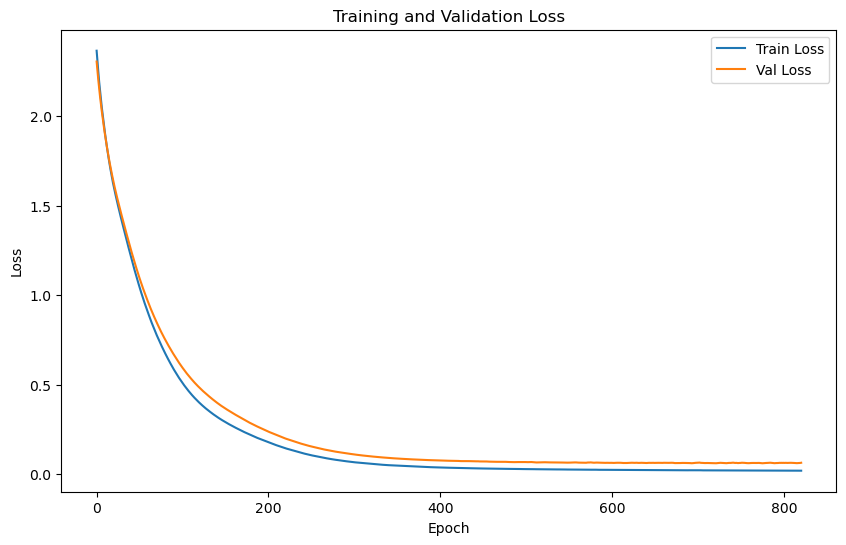

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.2196 | Test Accuracy: 95.41%


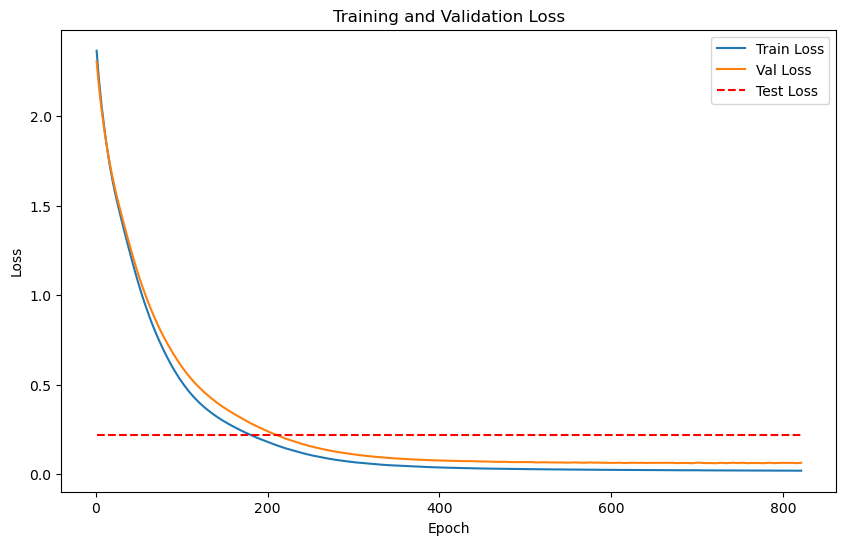

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147927, 64), 
Test labels shape: (147927,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [1/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3578

Validation loss improved from inf to 0.3578. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3577
Epoch [2/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3577

Validation loss improved from 0.3578 to 0.3577. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [3/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3583
Epoch [4/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.3583

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3587
Epoch [5/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.3587

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3586
Epoch [6/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.3586

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.3587
Epoch [7/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.3587

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3582
Epoch [8/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.3582

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.3573
Epoch [9/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.3573

Validation loss improved from 0.3577 to 0.3573. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [10/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.3560

Validation loss improved from 0.3573 to 0.3560. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [11/2000] - Validation


    Batch [1/1], Val Loss: 0.3546
Epoch [11/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.3546

Validation loss improved from 0.3560 to 0.3546. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [12/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.3532

Validation loss improved from 0.3546 to 0.3532. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [13/2000] - Validation


    Batch [1/1], Val Loss: 0.3520
Epoch [13/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.3520

Validation loss improved from 0.3532 to 0.3520. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3509
Epoch [14/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.3509

Validation loss improved from 0.3520 to 0.3509. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3498
Epoch [15/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.3498

Validation loss improved from 0.3509 to 0.3498. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3486
Epoch [16/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.3486

Validation loss improved from 0.3498 to 0.3486. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3477
Epoch [17/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.3477

Validation loss improved from 0.3486 to 0.3477. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3469
Epoch [18/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.3469

Validation loss improved from 0.3477 to 0.3469. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3458
Epoch [19/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.3458

Validation loss improved from 0.3469 to 0.3458. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3447
Epoch [20/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.3447

Validation loss improved from 0.3458 to 0.3447. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [21/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3435

Validation loss improved from 0.3447 to 0.3435. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [22/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3423

Validation loss improved from 0.3435 to 0.3423. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [23/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.3410

Validation loss improved from 0.3423 to 0.3410. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3397
Epoch [24/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.3397

Validation loss improved from 0.3410 to 0.3397. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [25/2000] - Validation


    Batch [1/1], Val Loss: 0.3383
Epoch [25/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.3383

Validation loss improved from 0.3397 to 0.3383. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [26/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.3370

Validation loss improved from 0.3383 to 0.3370. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [27/2000] - Validation


    Batch [1/1], Val Loss: 0.3358
Epoch [27/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.3358

Validation loss improved from 0.3370 to 0.3358. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3345
Epoch [28/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.3345

Validation loss improved from 0.3358 to 0.3345. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [29/2000] - Validation


    Batch [1/1], Val Loss: 0.3333
Epoch [29/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.3333

Validation loss improved from 0.3345 to 0.3333. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [30/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.3321

Validation loss improved from 0.3333 to 0.3321. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [31/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3309

Validation loss improved from 0.3321 to 0.3309. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [32/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.3297

Validation loss improved from 0.3309 to 0.3297. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3286
Epoch [33/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3286

Validation loss improved from 0.3297 to 0.3286. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3275
Epoch [34/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.3275

Validation loss improved from 0.3286 to 0.3275. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3263
Epoch [35/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.3263

Validation loss improved from 0.3275 to 0.3263. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3251
Epoch [36/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.3251

Validation loss improved from 0.3263 to 0.3251. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3240
Epoch [37/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.3240

Validation loss improved from 0.3251 to 0.3240. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3228
Epoch [38/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.3228

Validation loss improved from 0.3240 to 0.3228. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3216
Epoch [39/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3216

Validation loss improved from 0.3228 to 0.3216. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [40/2000] - Validation


    Batch [1/1], Val Loss: 0.3205
Epoch [40/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3205

Validation loss improved from 0.3216 to 0.3205. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3193
Epoch [41/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3193

Validation loss improved from 0.3205 to 0.3193. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [42/2000] - Validation


    Batch [1/1], Val Loss: 0.3181
Epoch [42/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3181

Validation loss improved from 0.3193 to 0.3181. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [43/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3169

Validation loss improved from 0.3181 to 0.3169. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [44/2000] - Validation


    Batch [1/1], Val Loss: 0.3157
Epoch [44/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3157

Validation loss improved from 0.3169 to 0.3157. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [45/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3145

Validation loss improved from 0.3157 to 0.3145. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [46/2000] - Validation


    Batch [1/1], Val Loss: 0.3134
Epoch [46/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3134

Validation loss improved from 0.3145 to 0.3134. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3122
Epoch [47/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.3122

Validation loss improved from 0.3134 to 0.3122. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [48/2000] - Validation


    Batch [1/1], Val Loss: 0.3110
Epoch [48/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3110

Validation loss improved from 0.3122 to 0.3110. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [49/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3099

Validation loss improved from 0.3110 to 0.3099. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [50/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3087

Validation loss improved from 0.3099 to 0.3087. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [51/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.3076

Validation loss improved from 0.3087 to 0.3076. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [52/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3065

Validation loss improved from 0.3076 to 0.3065. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [53/2000] - Validation


    Batch [1/1], Val Loss: 0.3054
Epoch [53/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.3054

Validation loss improved from 0.3065 to 0.3054. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [54/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.3043

Validation loss improved from 0.3054 to 0.3043. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [55/2000] - Validation


    Batch [1/1], Val Loss: 0.3032
Epoch [55/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.3032

Validation loss improved from 0.3043 to 0.3032. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3020
Epoch [56/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.3020

Validation loss improved from 0.3032 to 0.3020. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [57/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [57/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.3009

Validation loss improved from 0.3020 to 0.3009. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.2998
Epoch [58/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2998

Validation loss improved from 0.3009 to 0.2998. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [59/2000] - Validation


    Batch [1/1], Val Loss: 0.2988
Epoch [59/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2988

Validation loss improved from 0.2998 to 0.2988. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.2977
Epoch [60/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2977

Validation loss improved from 0.2988 to 0.2977. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [61/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.2966

Validation loss improved from 0.2977 to 0.2966. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.2955
Epoch [62/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2955

Validation loss improved from 0.2966 to 0.2955. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [63/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2944

Validation loss improved from 0.2955 to 0.2944. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.2933
Epoch [64/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2933

Validation loss improved from 0.2944 to 0.2933. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [65/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2922

Validation loss improved from 0.2933 to 0.2922. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.2911
Epoch [66/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2911

Validation loss improved from 0.2922 to 0.2911. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [67/2000] - Validation


    Batch [1/1], Val Loss: 0.2900
Epoch [67/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2900

Validation loss improved from 0.2911 to 0.2900. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [68/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2889

Validation loss improved from 0.2900 to 0.2889. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [69/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2878

Validation loss improved from 0.2889 to 0.2878. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.2867
Epoch [70/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2867

Validation loss improved from 0.2878 to 0.2867. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.2857
Epoch [71/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2857

Validation loss improved from 0.2867 to 0.2857. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.2847
Epoch [72/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.2847

Validation loss improved from 0.2857 to 0.2847. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [73/2000] - Validation


    Batch [1/1], Val Loss: 0.2836
Epoch [73/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2836

Validation loss improved from 0.2847 to 0.2836. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [74/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2826

Validation loss improved from 0.2836 to 0.2826. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3594
LOG: Epoch [75/2000] - Validation


    Batch [1/1], Val Loss: 0.2816
Epoch [75/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.2816

Validation loss improved from 0.2826 to 0.2816. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.2806
Epoch [76/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.2806

Validation loss improved from 0.2816 to 0.2806. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [77/2000] - Validation


    Batch [1/1], Val Loss: 0.2797
Epoch [77/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2797

Validation loss improved from 0.2806 to 0.2797. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.2787
Epoch [78/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2787

Validation loss improved from 0.2797 to 0.2787. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [79/2000] - Validation


    Batch [1/1], Val Loss: 0.2778
Epoch [79/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2778

Validation loss improved from 0.2787 to 0.2778. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.2768
Epoch [80/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2768

Validation loss improved from 0.2778 to 0.2768. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.2759
Epoch [81/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2759

Validation loss improved from 0.2768 to 0.2759. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.2750
Epoch [82/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2750

Validation loss improved from 0.2759 to 0.2750. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.2740
Epoch [83/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.2740

Validation loss improved from 0.2750 to 0.2740. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.2731
Epoch [84/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.2731

Validation loss improved from 0.2740 to 0.2731. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [85/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2722

Validation loss improved from 0.2731 to 0.2722. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [86/2000] - Validation


    Batch [1/1], Val Loss: 0.2713
Epoch [86/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.2713

Validation loss improved from 0.2722 to 0.2713. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.2703
Epoch [87/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2703

Validation loss improved from 0.2713 to 0.2703. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [88/2000] - Validation


    Batch [1/1], Val Loss: 0.2694
Epoch [88/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2694

Validation loss improved from 0.2703 to 0.2694. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.2685
Epoch [89/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.2685

Validation loss improved from 0.2694 to 0.2685. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [90/2000] - Validation


    Batch [1/1], Val Loss: 0.2676
Epoch [90/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2676

Validation loss improved from 0.2685 to 0.2676. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.2666
Epoch [91/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2666

Validation loss improved from 0.2676 to 0.2666. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [92/2000] - Validation


    Batch [1/1], Val Loss: 0.2657
Epoch [92/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.2657

Validation loss improved from 0.2666 to 0.2657. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.2649
Epoch [93/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2649

Validation loss improved from 0.2657 to 0.2649. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [94/2000] - Validation


    Batch [1/1], Val Loss: 0.2640
Epoch [94/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2640

Validation loss improved from 0.2649 to 0.2640. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.2632
Epoch [95/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2632

Validation loss improved from 0.2640 to 0.2632. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [96/2000] - Validation


    Batch [1/1], Val Loss: 0.2623
Epoch [96/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2623

Validation loss improved from 0.2632 to 0.2623. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.2615
Epoch [97/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2615

Validation loss improved from 0.2623 to 0.2615. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [98/2000] - Validation


    Batch [1/1], Val Loss: 0.2607
Epoch [98/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2607

Validation loss improved from 0.2615 to 0.2607. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.2599
Epoch [99/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2599

Validation loss improved from 0.2607 to 0.2599. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3390
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.2591
Epoch [100/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.2591

Validation loss improved from 0.2599 to 0.2591. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [101/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2584

Validation loss improved from 0.2591 to 0.2584. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [102/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2576

Validation loss improved from 0.2584 to 0.2576. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [103/2000] - Validation


    Batch [1/1], Val Loss: 0.2568
Epoch [103/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2568

Validation loss improved from 0.2576 to 0.2568. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3381
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.2561
Epoch [104/2000], Avg Train Loss: 0.3381, Avg Val Loss: 0.2561

Validation loss improved from 0.2568 to 0.2561. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [105/2000] - Validation


    Batch [1/1], Val Loss: 0.2553
Epoch [105/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.2553

Validation loss improved from 0.2561 to 0.2553. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.2546
Epoch [106/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.2546

Validation loss improved from 0.2553 to 0.2546. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [107/2000] - Validation


    Batch [1/1], Val Loss: 0.2538
Epoch [107/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.2538

Validation loss improved from 0.2546 to 0.2538. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.2531
Epoch [108/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.2531

Validation loss improved from 0.2538 to 0.2531. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [109/2000] - Validation


    Batch [1/1], Val Loss: 0.2524
Epoch [109/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.2524

Validation loss improved from 0.2531 to 0.2524. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3230
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.2517
Epoch [110/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.2517

Validation loss improved from 0.2524 to 0.2517. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3330
LOG: Epoch [111/2000] - Validation


    Batch [1/1], Val Loss: 0.2509
Epoch [111/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.2509

Validation loss improved from 0.2517 to 0.2509. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [112/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.2502

Validation loss improved from 0.2509 to 0.2502. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [113/2000] - Validation


    Batch [1/1], Val Loss: 0.2495
Epoch [113/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.2495

Validation loss improved from 0.2502 to 0.2495. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.2488
Epoch [114/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.2488

Validation loss improved from 0.2495 to 0.2488. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [115/2000] - Validation


    Batch [1/1], Val Loss: 0.2481
Epoch [115/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.2481

Validation loss improved from 0.2488 to 0.2481. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [116/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.2474

Validation loss improved from 0.2481 to 0.2474. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3258
LOG: Epoch [117/2000] - Validation


    Batch [1/1], Val Loss: 0.2467
Epoch [117/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.2467

Validation loss improved from 0.2474 to 0.2467. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [118/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2460

Validation loss improved from 0.2467 to 0.2460. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [119/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.2453

Validation loss improved from 0.2460 to 0.2453. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [120/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.2446

Validation loss improved from 0.2453 to 0.2446. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3299
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.2440
Epoch [121/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.2440

Validation loss improved from 0.2446 to 0.2440. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.2433
Epoch [122/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2433

Validation loss improved from 0.2440 to 0.2433. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.2426
Epoch [123/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2426

Validation loss improved from 0.2433 to 0.2426. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.2419
Epoch [124/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.2419

Validation loss improved from 0.2426 to 0.2419. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.2412
Epoch [125/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.2412

Validation loss improved from 0.2419 to 0.2412. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.2405
Epoch [126/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.2405

Validation loss improved from 0.2412 to 0.2405. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.2398
Epoch [127/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2398

Validation loss improved from 0.2405 to 0.2398. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.2391
Epoch [128/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.2391

Validation loss improved from 0.2398 to 0.2391. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3231
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.2385
Epoch [129/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.2385

Validation loss improved from 0.2391 to 0.2385. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [130/2000] - Validation


    Batch [1/1], Val Loss: 0.2378
Epoch [130/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2378

Validation loss improved from 0.2385 to 0.2378. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.2371
Epoch [131/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.2371

Validation loss improved from 0.2378 to 0.2371. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3174
LOG: Epoch [132/2000] - Validation


    Batch [1/1], Val Loss: 0.2365
Epoch [132/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.2365

Validation loss improved from 0.2371 to 0.2365. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3160
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [133/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.2358

Validation loss improved from 0.2365 to 0.2358. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3145
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.2352
Epoch [134/2000], Avg Train Loss: 0.3145, Avg Val Loss: 0.2352

Validation loss improved from 0.2358 to 0.2352. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.2346
Epoch [135/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2346

Validation loss improved from 0.2352 to 0.2346. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [136/2000] - Validation


    Batch [1/1], Val Loss: 0.2339
Epoch [136/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.2339

Validation loss improved from 0.2346 to 0.2339. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3124
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.2333
Epoch [137/2000], Avg Train Loss: 0.3124, Avg Val Loss: 0.2333

Validation loss improved from 0.2339 to 0.2333. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3060
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.2326
Epoch [138/2000], Avg Train Loss: 0.3060, Avg Val Loss: 0.2326

Validation loss improved from 0.2333 to 0.2326. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.2320
Epoch [139/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.2320

Validation loss improved from 0.2326 to 0.2320. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.2314
Epoch [140/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.2314

Validation loss improved from 0.2320 to 0.2314. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3037
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.2308
Epoch [141/2000], Avg Train Loss: 0.3037, Avg Val Loss: 0.2308

Validation loss improved from 0.2314 to 0.2308. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3072
LOG: Epoch [142/2000] - Validation


    Batch [1/1], Val Loss: 0.2302
Epoch [142/2000], Avg Train Loss: 0.3072, Avg Val Loss: 0.2302

Validation loss improved from 0.2308 to 0.2302. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.2296
Epoch [143/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.2296

Validation loss improved from 0.2302 to 0.2296. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.2290
Epoch [144/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.2290

Validation loss improved from 0.2296 to 0.2290. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.2284
Epoch [145/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.2284

Validation loss improved from 0.2290 to 0.2284. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.2278
Epoch [146/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.2278

Validation loss improved from 0.2284 to 0.2278. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3056
LOG: Epoch [147/2000] - Validation


    Batch [1/1], Val Loss: 0.2272
Epoch [147/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.2272

Validation loss improved from 0.2278 to 0.2272. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.2266
Epoch [148/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.2266

Validation loss improved from 0.2272 to 0.2266. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3008
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.2260
Epoch [149/2000], Avg Train Loss: 0.3008, Avg Val Loss: 0.2260

Validation loss improved from 0.2266 to 0.2260. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.2255
Epoch [150/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.2255

Validation loss improved from 0.2260 to 0.2255. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [151/2000] - Validation


    Batch [1/1], Val Loss: 0.2249
Epoch [151/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.2249

Validation loss improved from 0.2255 to 0.2249. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3012
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.2243
Epoch [152/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.2243

Validation loss improved from 0.2249 to 0.2243. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3007
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.2237
Epoch [153/2000], Avg Train Loss: 0.3007, Avg Val Loss: 0.2237

Validation loss improved from 0.2243 to 0.2237. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.2232
Epoch [154/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.2232

Validation loss improved from 0.2237 to 0.2232. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.2227
Epoch [155/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.2227

Validation loss improved from 0.2232 to 0.2227. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.2967
LOG: Epoch [156/2000] - Validation


    Batch [1/1], Val Loss: 0.2221
Epoch [156/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.2221

Validation loss improved from 0.2227 to 0.2221. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.2216
Epoch [157/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.2216

Validation loss improved from 0.2221 to 0.2216. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.2963
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [158/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.2210

Validation loss improved from 0.2216 to 0.2210. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.2205
Epoch [159/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.2205

Validation loss improved from 0.2210 to 0.2205. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.2990
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.2200
Epoch [160/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.2200

Validation loss improved from 0.2205 to 0.2200. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.2195
Epoch [161/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.2195

Validation loss improved from 0.2200 to 0.2195. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.2190
Epoch [162/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.2190

Validation loss improved from 0.2195 to 0.2190. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.2934
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.2185
Epoch [163/2000], Avg Train Loss: 0.2934, Avg Val Loss: 0.2185

Validation loss improved from 0.2190 to 0.2185. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.2180
Epoch [164/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.2180

Validation loss improved from 0.2185 to 0.2180. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [165/2000] - Validation


    Batch [1/1], Val Loss: 0.2176
Epoch [165/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2176

Validation loss improved from 0.2180 to 0.2176. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.2171
Epoch [166/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.2171

Validation loss improved from 0.2176 to 0.2171. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.2965
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.2166
Epoch [167/2000], Avg Train Loss: 0.2965, Avg Val Loss: 0.2166

Validation loss improved from 0.2171 to 0.2166. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.2895
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.2162
Epoch [168/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.2162

Validation loss improved from 0.2166 to 0.2162. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [169/2000] - Validation


    Batch [1/1], Val Loss: 0.2157
Epoch [169/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.2157

Validation loss improved from 0.2162 to 0.2157. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.2153
Epoch [170/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.2153

Validation loss improved from 0.2157 to 0.2153. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [171/2000] - Validation


    Batch [1/1], Val Loss: 0.2148
Epoch [171/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.2148

Validation loss improved from 0.2153 to 0.2148. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.2144
Epoch [172/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.2144

Validation loss improved from 0.2148 to 0.2144. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.2139
Epoch [173/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2139

Validation loss improved from 0.2144 to 0.2139. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.2134
Epoch [174/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2134

Validation loss improved from 0.2139 to 0.2134. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.2130
Epoch [175/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2130

Validation loss improved from 0.2134 to 0.2130. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [176/2000] - Validation


    Batch [1/1], Val Loss: 0.2125
Epoch [176/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.2125

Validation loss improved from 0.2130 to 0.2125. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.2120
Epoch [177/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2120

Validation loss improved from 0.2125 to 0.2120. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [178/2000] - Validation


    Batch [1/1], Val Loss: 0.2115
Epoch [178/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.2115

Validation loss improved from 0.2120 to 0.2115. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.2110
Epoch [179/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2110

Validation loss improved from 0.2115 to 0.2110. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [180/2000] - Validation


    Batch [1/1], Val Loss: 0.2106
Epoch [180/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.2106

Validation loss improved from 0.2110 to 0.2106. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.2100
Epoch [181/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2100

Validation loss improved from 0.2106 to 0.2100. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.2096
Epoch [182/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.2096

Validation loss improved from 0.2100 to 0.2096. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.2091
Epoch [183/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2091

Validation loss improved from 0.2096 to 0.2091. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.2086
Epoch [184/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2086

Validation loss improved from 0.2091 to 0.2086. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.2082
Epoch [185/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2082

Validation loss improved from 0.2086 to 0.2082. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.2077
Epoch [186/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.2077

Validation loss improved from 0.2082 to 0.2077. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.2073
Epoch [187/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2073

Validation loss improved from 0.2077 to 0.2073. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.2068
Epoch [188/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2068

Validation loss improved from 0.2073 to 0.2068. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.2064
Epoch [189/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2064

Validation loss improved from 0.2068 to 0.2064. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.2060
Epoch [190/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2060

Validation loss improved from 0.2064 to 0.2060. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2056
Epoch [191/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.2056

Validation loss improved from 0.2060 to 0.2056. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [192/2000] - Validation


    Batch [1/1], Val Loss: 0.2051
Epoch [192/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2051

Validation loss improved from 0.2056 to 0.2051. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.2047
Epoch [193/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.2047

Validation loss improved from 0.2051 to 0.2047. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.2742
LOG: Epoch [194/2000] - Validation


    Batch [1/1], Val Loss: 0.2043
Epoch [194/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.2043

Validation loss improved from 0.2047 to 0.2043. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.2039
Epoch [195/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2039

Validation loss improved from 0.2043 to 0.2039. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.2035
Epoch [196/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2035

Validation loss improved from 0.2039 to 0.2035. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.2031
Epoch [197/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2031

Validation loss improved from 0.2035 to 0.2031. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.2027
Epoch [198/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2027

Validation loss improved from 0.2031 to 0.2027. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.2023
Epoch [199/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2023

Validation loss improved from 0.2027 to 0.2023. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.2019
Epoch [200/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2019

Validation loss improved from 0.2023 to 0.2019. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.2015
Epoch [201/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2015

Validation loss improved from 0.2019 to 0.2015. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.2011
Epoch [202/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2011

Validation loss improved from 0.2015 to 0.2011. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.2006
Epoch [203/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2006

Validation loss improved from 0.2011 to 0.2006. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [204/2000] - Validation


    Batch [1/1], Val Loss: 0.2002
Epoch [204/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2002

Validation loss improved from 0.2006 to 0.2002. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.1998
Epoch [205/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.1998

Validation loss improved from 0.2002 to 0.1998. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [206/2000] - Validation


    Batch [1/1], Val Loss: 0.1994
Epoch [206/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.1994

Validation loss improved from 0.1998 to 0.1994. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.1990
Epoch [207/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.1990

Validation loss improved from 0.1994 to 0.1990. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.2702
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.1986
Epoch [208/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.1986

Validation loss improved from 0.1990 to 0.1986. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [209/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.1982

Validation loss improved from 0.1986 to 0.1982. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.1978
Epoch [210/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.1978

Validation loss improved from 0.1982 to 0.1978. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.1974
Epoch [211/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.1974

Validation loss improved from 0.1978 to 0.1974. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.1970
Epoch [212/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.1970

Validation loss improved from 0.1974 to 0.1970. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.1967
Epoch [213/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.1967

Validation loss improved from 0.1970 to 0.1967. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.1963
Epoch [214/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.1963

Validation loss improved from 0.1967 to 0.1963. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.1959
Epoch [215/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.1959

Validation loss improved from 0.1963 to 0.1959. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.1956
Epoch [216/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.1956

Validation loss improved from 0.1959 to 0.1956. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.2513
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.1952
Epoch [217/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.1952

Validation loss improved from 0.1956 to 0.1952. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [218/2000] - Validation


    Batch [1/1], Val Loss: 0.1949
Epoch [218/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.1949

Validation loss improved from 0.1952 to 0.1949. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.2583
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.1946
Epoch [219/2000], Avg Train Loss: 0.2583, Avg Val Loss: 0.1946

Validation loss improved from 0.1949 to 0.1946. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.1942
Epoch [220/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.1942

Validation loss improved from 0.1946 to 0.1942. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.1939
Epoch [221/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.1939

Validation loss improved from 0.1942 to 0.1939. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.1936
Epoch [222/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.1936

Validation loss improved from 0.1939 to 0.1936. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.1933
Epoch [223/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.1933

Validation loss improved from 0.1936 to 0.1933. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.1929
Epoch [224/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.1929

Validation loss improved from 0.1933 to 0.1929. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.1926
Epoch [225/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.1926

Validation loss improved from 0.1929 to 0.1926. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.1923
Epoch [226/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.1923

Validation loss improved from 0.1926 to 0.1923. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.1919
Epoch [227/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.1919

Validation loss improved from 0.1923 to 0.1919. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [228/2000] - Validation


    Batch [1/1], Val Loss: 0.1916
Epoch [228/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.1916

Validation loss improved from 0.1919 to 0.1916. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.1913
Epoch [229/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.1913

Validation loss improved from 0.1916 to 0.1913. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [230/2000] - Validation


    Batch [1/1], Val Loss: 0.1909
Epoch [230/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.1909

Validation loss improved from 0.1913 to 0.1909. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.2497
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.1906
Epoch [231/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.1906

Validation loss improved from 0.1909 to 0.1906. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.2473
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.1903
Epoch [232/2000], Avg Train Loss: 0.2473, Avg Val Loss: 0.1903

Validation loss improved from 0.1906 to 0.1903. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.1900
Epoch [233/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.1900

Validation loss improved from 0.1903 to 0.1900. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.1898
Epoch [234/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.1898

Validation loss improved from 0.1900 to 0.1898. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.1895
Epoch [235/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.1895

Validation loss improved from 0.1898 to 0.1895. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2565
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.1891
Epoch [236/2000], Avg Train Loss: 0.2565, Avg Val Loss: 0.1891

Validation loss improved from 0.1895 to 0.1891. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.1888
Epoch [237/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.1888

Validation loss improved from 0.1891 to 0.1888. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.2546
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.1885
Epoch [238/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.1885

Validation loss improved from 0.1888 to 0.1885. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.2475
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.1881
Epoch [239/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.1881

Validation loss improved from 0.1885 to 0.1881. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2451
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.1878
Epoch [240/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.1878

Validation loss improved from 0.1881 to 0.1878. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.1875
Epoch [241/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.1875

Validation loss improved from 0.1878 to 0.1875. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.1872
Epoch [242/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.1872

Validation loss improved from 0.1875 to 0.1872. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.2533
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.1869
Epoch [243/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.1869

Validation loss improved from 0.1872 to 0.1869. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2462
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.1866
Epoch [244/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.1866

Validation loss improved from 0.1869 to 0.1866. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.1864
Epoch [245/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.1864

Validation loss improved from 0.1866 to 0.1864. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.1861
Epoch [246/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.1861

Validation loss improved from 0.1864 to 0.1861. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2410
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.1859
Epoch [247/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.1859

Validation loss improved from 0.1861 to 0.1859. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.1856
Epoch [248/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.1856

Validation loss improved from 0.1859 to 0.1856. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.1854
Epoch [249/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.1854

Validation loss improved from 0.1856 to 0.1854. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [250/2000] - Validation


    Batch [1/1], Val Loss: 0.1851
Epoch [250/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.1851

Validation loss improved from 0.1854 to 0.1851. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2430
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.1849
Epoch [251/2000], Avg Train Loss: 0.2430, Avg Val Loss: 0.1849

Validation loss improved from 0.1851 to 0.1849. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2427
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.1846
Epoch [252/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.1846

Validation loss improved from 0.1849 to 0.1846. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.2438
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.1844
Epoch [253/2000], Avg Train Loss: 0.2438, Avg Val Loss: 0.1844

Validation loss improved from 0.1846 to 0.1844. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.1842
Epoch [254/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.1842

Validation loss improved from 0.1844 to 0.1842. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [255/2000] - Validation


    Batch [1/1], Val Loss: 0.1840
Epoch [255/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.1840

Validation loss improved from 0.1842 to 0.1840. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.1838
Epoch [256/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.1838

Validation loss improved from 0.1840 to 0.1838. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [257/2000] - Validation


    Batch [1/1], Val Loss: 0.1836
Epoch [257/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.1836

Validation loss improved from 0.1838 to 0.1836. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2425
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.1833
Epoch [258/2000], Avg Train Loss: 0.2425, Avg Val Loss: 0.1833

Validation loss improved from 0.1836 to 0.1833. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2448
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.1831
Epoch [259/2000], Avg Train Loss: 0.2448, Avg Val Loss: 0.1831

Validation loss improved from 0.1833 to 0.1831. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.2372
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.1828
Epoch [260/2000], Avg Train Loss: 0.2372, Avg Val Loss: 0.1828

Validation loss improved from 0.1831 to 0.1828. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2373
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.1826
Epoch [261/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.1826

Validation loss improved from 0.1828 to 0.1826. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.2419
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.1823
Epoch [262/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.1823

Validation loss improved from 0.1826 to 0.1823. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.1820
Epoch [263/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.1820

Validation loss improved from 0.1823 to 0.1820. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.2401
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.1817
Epoch [264/2000], Avg Train Loss: 0.2401, Avg Val Loss: 0.1817

Validation loss improved from 0.1820 to 0.1817. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2356
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.1814
Epoch [265/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.1814

Validation loss improved from 0.1817 to 0.1814. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2323
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.1812
Epoch [266/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.1812

Validation loss improved from 0.1814 to 0.1812. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.2388
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.1809
Epoch [267/2000], Avg Train Loss: 0.2388, Avg Val Loss: 0.1809

Validation loss improved from 0.1812 to 0.1809. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2361
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.1806
Epoch [268/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.1806

Validation loss improved from 0.1809 to 0.1806. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2359
LOG: Epoch [269/2000] - Validation


    Batch [1/1], Val Loss: 0.1803
Epoch [269/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.1803

Validation loss improved from 0.1806 to 0.1803. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.1800
Epoch [270/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.1800

Validation loss improved from 0.1803 to 0.1800. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.2337
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.1797
Epoch [271/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.1797

Validation loss improved from 0.1800 to 0.1797. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2347
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.1795
Epoch [272/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.1795

Validation loss improved from 0.1797 to 0.1795. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [273/2000] - Validation


    Batch [1/1], Val Loss: 0.1792
Epoch [273/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.1792

Validation loss improved from 0.1795 to 0.1792. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.1789
Epoch [274/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.1789

Validation loss improved from 0.1792 to 0.1789. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [275/2000] - Validation


    Batch [1/1], Val Loss: 0.1787
Epoch [275/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.1787

Validation loss improved from 0.1789 to 0.1787. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2345
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.1785
Epoch [276/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.1785

Validation loss improved from 0.1787 to 0.1785. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2334
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.1782
Epoch [277/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.1782

Validation loss improved from 0.1785 to 0.1782. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.2285
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.1779
Epoch [278/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.1779

Validation loss improved from 0.1782 to 0.1779. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.1777
Epoch [279/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.1777

Validation loss improved from 0.1779 to 0.1777. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.2280
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.1775
Epoch [280/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.1775

Validation loss improved from 0.1777 to 0.1775. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.1772
Epoch [281/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.1772

Validation loss improved from 0.1775 to 0.1772. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.2326
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.1770
Epoch [282/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.1770

Validation loss improved from 0.1772 to 0.1770. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.1767
Epoch [283/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.1767

Validation loss improved from 0.1770 to 0.1767. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [284/2000] - Validation


    Batch [1/1], Val Loss: 0.1765
Epoch [284/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.1765

Validation loss improved from 0.1767 to 0.1765. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.1762
Epoch [285/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.1762

Validation loss improved from 0.1765 to 0.1762. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2248
LOG: Epoch [286/2000] - Validation


    Batch [1/1], Val Loss: 0.1760
Epoch [286/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.1760

Validation loss improved from 0.1762 to 0.1760. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.1757
Epoch [287/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.1757

Validation loss improved from 0.1760 to 0.1757. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [288/2000] - Validation


    Batch [1/1], Val Loss: 0.1755
Epoch [288/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.1755

Validation loss improved from 0.1757 to 0.1755. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.1752
Epoch [289/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.1752

Validation loss improved from 0.1755 to 0.1752. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2262
LOG: Epoch [290/2000] - Validation


    Batch [1/1], Val Loss: 0.1749
Epoch [290/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.1749

Validation loss improved from 0.1752 to 0.1749. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.1747
Epoch [291/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.1747

Validation loss improved from 0.1749 to 0.1747. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2256
LOG: Epoch [292/2000] - Validation


    Batch [1/1], Val Loss: 0.1744
Epoch [292/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.1744

Validation loss improved from 0.1747 to 0.1744. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.1742
Epoch [293/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.1742

Validation loss improved from 0.1744 to 0.1742. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2307
LOG: Epoch [294/2000] - Validation


    Batch [1/1], Val Loss: 0.1739
Epoch [294/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.1739

Validation loss improved from 0.1742 to 0.1739. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.1737
Epoch [295/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.1737

Validation loss improved from 0.1739 to 0.1737. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [296/2000] - Validation


    Batch [1/1], Val Loss: 0.1734
Epoch [296/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1734

Validation loss improved from 0.1737 to 0.1734. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.1732
Epoch [297/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.1732

Validation loss improved from 0.1734 to 0.1732. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.1729
Epoch [298/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.1729

Validation loss improved from 0.1732 to 0.1729. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.1727
Epoch [299/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.1727

Validation loss improved from 0.1729 to 0.1727. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.1724
Epoch [300/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1724

Validation loss improved from 0.1727 to 0.1724. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2221
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.1721
Epoch [301/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.1721

Validation loss improved from 0.1724 to 0.1721. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.1719
Epoch [302/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.1719

Validation loss improved from 0.1721 to 0.1719. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.1717
Epoch [303/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.1717

Validation loss improved from 0.1719 to 0.1717. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [304/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.1714

Validation loss improved from 0.1717 to 0.1714. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2195
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [305/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.1712

Validation loss improved from 0.1714 to 0.1712. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.1710
Epoch [306/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.1710

Validation loss improved from 0.1712 to 0.1710. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.1708
Epoch [307/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.1708

Validation loss improved from 0.1710 to 0.1708. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.1707
Epoch [308/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.1707

Validation loss improved from 0.1708 to 0.1707. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [309/2000] - Validation


    Batch [1/1], Val Loss: 0.1705
Epoch [309/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.1705

Validation loss improved from 0.1707 to 0.1705. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.1703
Epoch [310/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1703

Validation loss improved from 0.1705 to 0.1703. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2233
LOG: Epoch [311/2000] - Validation


    Batch [1/1], Val Loss: 0.1701
Epoch [311/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.1701

Validation loss improved from 0.1703 to 0.1701. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.1699
Epoch [312/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1699

Validation loss improved from 0.1701 to 0.1699. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.1697
Epoch [313/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.1697

Validation loss improved from 0.1699 to 0.1697. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.1695
Epoch [314/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1695

Validation loss improved from 0.1697 to 0.1695. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [315/2000] - Validation


    Batch [1/1], Val Loss: 0.1693
Epoch [315/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.1693

Validation loss improved from 0.1695 to 0.1693. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.1690
Epoch [316/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1690

Validation loss improved from 0.1693 to 0.1690. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [317/2000] - Validation


    Batch [1/1], Val Loss: 0.1688
Epoch [317/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1688

Validation loss improved from 0.1690 to 0.1688. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.1686
Epoch [318/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1686

Validation loss improved from 0.1688 to 0.1686. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.1684
Epoch [319/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1684

Validation loss improved from 0.1686 to 0.1684. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.1683
Epoch [320/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.1683

Validation loss improved from 0.1684 to 0.1683. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.1681
Epoch [321/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.1681

Validation loss improved from 0.1683 to 0.1681. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.1680
Epoch [322/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.1680

Validation loss improved from 0.1681 to 0.1680. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2111
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.1678
Epoch [323/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.1678

Validation loss improved from 0.1680 to 0.1678. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.2163
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.1677
Epoch [324/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.1677

Validation loss improved from 0.1678 to 0.1677. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.1675
Epoch [325/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1675

Validation loss improved from 0.1677 to 0.1675. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.1674
Epoch [326/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1674

Validation loss improved from 0.1675 to 0.1674. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.2119
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.1672
Epoch [327/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1672

Validation loss improved from 0.1674 to 0.1672. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2117
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.1671
Epoch [328/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.1671

Validation loss improved from 0.1672 to 0.1671. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [329/2000] - Validation


    Batch [1/1], Val Loss: 0.1669
Epoch [329/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.1669

Validation loss improved from 0.1671 to 0.1669. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2136
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.1667
Epoch [330/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.1667

Validation loss improved from 0.1669 to 0.1667. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2147
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.1665
Epoch [331/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.1665

Validation loss improved from 0.1667 to 0.1665. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2114
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.1664
Epoch [332/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.1664

Validation loss improved from 0.1665 to 0.1664. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.1662
Epoch [333/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.1662

Validation loss improved from 0.1664 to 0.1662. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [334/2000] - Validation


    Batch [1/1], Val Loss: 0.1660
Epoch [334/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.1660

Validation loss improved from 0.1662 to 0.1660. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2125
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.1658
Epoch [335/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.1658

Validation loss improved from 0.1660 to 0.1658. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2117
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.1656
Epoch [336/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.1656

Validation loss improved from 0.1658 to 0.1656. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.1655
Epoch [337/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1655

Validation loss improved from 0.1656 to 0.1655. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.1653
Epoch [338/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1653

Validation loss improved from 0.1655 to 0.1653. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2167
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.1652
Epoch [339/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1652

Validation loss improved from 0.1653 to 0.1652. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.1650
Epoch [340/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1650

Validation loss improved from 0.1652 to 0.1650. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.1648
Epoch [341/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.1648

Validation loss improved from 0.1650 to 0.1648. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.1647
Epoch [342/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.1647

Validation loss improved from 0.1648 to 0.1647. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.1645
Epoch [343/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.1645

Validation loss improved from 0.1647 to 0.1645. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.1644
Epoch [344/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1644

Validation loss improved from 0.1645 to 0.1644. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [345/2000] - Validation


    Batch [1/1], Val Loss: 0.1643
Epoch [345/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.1643

Validation loss improved from 0.1644 to 0.1643. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.1641
Epoch [346/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.1641

Validation loss improved from 0.1643 to 0.1641. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [347/2000] - Validation


    Batch [1/1], Val Loss: 0.1640
Epoch [347/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.1640

Validation loss improved from 0.1641 to 0.1640. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2105
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.1639
Epoch [348/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.1639

Validation loss improved from 0.1640 to 0.1639. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [349/2000] - Validation


    Batch [1/1], Val Loss: 0.1637
Epoch [349/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.1637

Validation loss improved from 0.1639 to 0.1637. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.1636
Epoch [350/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.1636

Validation loss improved from 0.1637 to 0.1636. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.1635
Epoch [351/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.1635

Validation loss improved from 0.1636 to 0.1635. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.1634
Epoch [352/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.1634

Validation loss improved from 0.1635 to 0.1634. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.1633
Epoch [353/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1633

Validation loss improved from 0.1634 to 0.1633. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [354/2000] - Validation


    Batch [1/1], Val Loss: 0.1632
Epoch [354/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.1632

Validation loss improved from 0.1633 to 0.1632. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.1631
Epoch [355/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.1631

Validation loss improved from 0.1632 to 0.1631. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.1630
Epoch [356/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.1630

Validation loss improved from 0.1631 to 0.1630. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.1629
Epoch [357/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.1629

Validation loss improved from 0.1630 to 0.1629. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.1628
Epoch [358/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.1628

Validation loss improved from 0.1629 to 0.1628. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.1627
Epoch [359/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.1627

Validation loss improved from 0.1628 to 0.1627. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [360/2000] - Validation


    Batch [1/1], Val Loss: 0.1626
Epoch [360/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.1626

Validation loss improved from 0.1627 to 0.1626. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.1625
Epoch [361/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.1625

Validation loss improved from 0.1626 to 0.1625. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.1624
Epoch [362/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.1624

Validation loss improved from 0.1625 to 0.1624. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.1623
Epoch [363/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.1623

Validation loss improved from 0.1624 to 0.1623. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.1622
Epoch [364/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.1622

Validation loss improved from 0.1623 to 0.1622. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [365/2000] - Validation


    Batch [1/1], Val Loss: 0.1621
Epoch [365/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1621

Validation loss improved from 0.1622 to 0.1621. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.1620
Epoch [366/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.1620

Validation loss improved from 0.1621 to 0.1620. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.1620
Epoch [367/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1620

Validation loss improved from 0.1620 to 0.1620. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.1619
Epoch [368/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.1619

Validation loss improved from 0.1620 to 0.1619. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.1617
Epoch [369/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1617

Validation loss improved from 0.1619 to 0.1617. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [370/2000] - Validation


    Batch [1/1], Val Loss: 0.1616
Epoch [370/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1616

Validation loss improved from 0.1617 to 0.1616. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.1615
Epoch [371/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.1615

Validation loss improved from 0.1616 to 0.1615. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.1614
Epoch [372/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.1614

Validation loss improved from 0.1615 to 0.1614. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.1613
Epoch [373/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.1613

Validation loss improved from 0.1614 to 0.1613. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.1612
Epoch [374/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.1612

Validation loss improved from 0.1613 to 0.1612. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.1610
Epoch [375/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.1610

Validation loss improved from 0.1612 to 0.1610. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.1609
Epoch [376/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.1609

Validation loss improved from 0.1610 to 0.1609. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [377/2000] - Validation


    Batch [1/1], Val Loss: 0.1608
Epoch [377/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.1608

Validation loss improved from 0.1609 to 0.1608. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.1606
Epoch [378/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.1606

Validation loss improved from 0.1608 to 0.1606. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [379/2000] - Validation


    Batch [1/1], Val Loss: 0.1605
Epoch [379/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.1605

Validation loss improved from 0.1606 to 0.1605. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.1604
Epoch [380/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1604

Validation loss improved from 0.1605 to 0.1604. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [381/2000] - Validation


    Batch [1/1], Val Loss: 0.1602
Epoch [381/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.1602

Validation loss improved from 0.1604 to 0.1602. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.1601
Epoch [382/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.1601

Validation loss improved from 0.1602 to 0.1601. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [383/2000] - Validation


    Batch [1/1], Val Loss: 0.1600
Epoch [383/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.1600

Validation loss improved from 0.1601 to 0.1600. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.1600
Epoch [384/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1600

Validation loss improved from 0.1600 to 0.1600. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [385/2000] - Validation


    Batch [1/1], Val Loss: 0.1599
Epoch [385/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1599

Validation loss improved from 0.1600 to 0.1599. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.1598
Epoch [386/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.1598

Validation loss improved from 0.1599 to 0.1598. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [387/2000] - Validation


    Batch [1/1], Val Loss: 0.1596
Epoch [387/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.1596

Validation loss improved from 0.1598 to 0.1596. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.1595
Epoch [388/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.1595

Validation loss improved from 0.1596 to 0.1595. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.1593
Epoch [389/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.1593

Validation loss improved from 0.1595 to 0.1593. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.1592
Epoch [390/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1592

Validation loss improved from 0.1593 to 0.1592. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.1590
Epoch [391/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1590

Validation loss improved from 0.1592 to 0.1590. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [392/2000] - Validation


    Batch [1/1], Val Loss: 0.1588
Epoch [392/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.1588

Validation loss improved from 0.1590 to 0.1588. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.1586
Epoch [393/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1586

Validation loss improved from 0.1588 to 0.1586. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [394/2000] - Validation


    Batch [1/1], Val Loss: 0.1584
Epoch [394/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.1584

Validation loss improved from 0.1586 to 0.1584. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.1582
Epoch [395/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.1582

Validation loss improved from 0.1584 to 0.1582. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.1580
Epoch [396/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1580

Validation loss improved from 0.1582 to 0.1580. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.1578
Epoch [397/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.1578

Validation loss improved from 0.1580 to 0.1578. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.1577
Epoch [398/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.1577

Validation loss improved from 0.1578 to 0.1577. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.1576
Epoch [399/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.1576

Validation loss improved from 0.1577 to 0.1576. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.1575
Epoch [400/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.1575

Validation loss improved from 0.1576 to 0.1575. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [401/2000] - Validation


    Batch [1/1], Val Loss: 0.1574
Epoch [401/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.1574

Validation loss improved from 0.1575 to 0.1574. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.1573
Epoch [402/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.1573

Validation loss improved from 0.1574 to 0.1573. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.1572
Epoch [403/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1572

Validation loss improved from 0.1573 to 0.1572. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.1571
Epoch [404/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1571

Validation loss improved from 0.1572 to 0.1571. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [405/2000] - Validation


    Batch [1/1], Val Loss: 0.1571
Epoch [405/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1571

Validation loss improved from 0.1571 to 0.1571. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.1831
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.1570
Epoch [406/2000], Avg Train Loss: 0.1831, Avg Val Loss: 0.1570

Validation loss improved from 0.1571 to 0.1570. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [407/2000] - Validation


    Batch [1/1], Val Loss: 0.1569
Epoch [407/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.1569

Validation loss improved from 0.1570 to 0.1569. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.1568
Epoch [408/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.1568

Validation loss improved from 0.1569 to 0.1568. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [409/2000] - Validation


    Batch [1/1], Val Loss: 0.1566
Epoch [409/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.1566

Validation loss improved from 0.1568 to 0.1566. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.1565
Epoch [410/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1565

Validation loss improved from 0.1566 to 0.1565. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.1841
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.1564
Epoch [411/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.1564

Validation loss improved from 0.1565 to 0.1564. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.1563
Epoch [412/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1563

Validation loss improved from 0.1564 to 0.1563. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.1562
Epoch [413/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.1562

Validation loss improved from 0.1563 to 0.1562. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [414/2000] - Validation


    Batch [1/1], Val Loss: 0.1560
Epoch [414/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.1560

Validation loss improved from 0.1562 to 0.1560. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.1559
Epoch [415/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1559

Validation loss improved from 0.1560 to 0.1559. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [416/2000] - Validation


    Batch [1/1], Val Loss: 0.1559
Epoch [416/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.1559

Validation loss improved from 0.1559 to 0.1559. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.1557
Epoch [417/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.1557

Validation loss improved from 0.1559 to 0.1557. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [418/2000] - Validation


    Batch [1/1], Val Loss: 0.1556
Epoch [418/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1556

Validation loss improved from 0.1557 to 0.1556. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.1840
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.1555
Epoch [419/2000], Avg Train Loss: 0.1840, Avg Val Loss: 0.1555

Validation loss improved from 0.1556 to 0.1555. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [420/2000] - Validation


    Batch [1/1], Val Loss: 0.1553
Epoch [420/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.1553

Validation loss improved from 0.1555 to 0.1553. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.1814
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.1552
Epoch [421/2000], Avg Train Loss: 0.1814, Avg Val Loss: 0.1552

Validation loss improved from 0.1553 to 0.1552. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.1551
Epoch [422/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1551

Validation loss improved from 0.1552 to 0.1551. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.1550
Epoch [423/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.1550

Validation loss improved from 0.1551 to 0.1550. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.1549
Epoch [424/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.1549

Validation loss improved from 0.1550 to 0.1549. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.1549
Epoch [425/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1549

Validation loss improved from 0.1549 to 0.1549. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.1842
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.1549
Epoch [426/2000], Avg Train Loss: 0.1842, Avg Val Loss: 0.1549

Validation loss improved from 0.1549 to 0.1549. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.1842
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.1549
Epoch [427/2000], Avg Train Loss: 0.1842, Avg Val Loss: 0.1549

Validation loss improved from 0.1549 to 0.1549. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.1548
Epoch [428/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.1548

Validation loss improved from 0.1549 to 0.1548. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.1863
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.1548
Epoch [429/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.1548

Validation loss improved from 0.1548 to 0.1548. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.1548
Epoch [430/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1548

Validation loss improved from 0.1548 to 0.1548. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.1824
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.1547
Epoch [431/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.1547

Validation loss improved from 0.1548 to 0.1547. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.1848
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.1547
Epoch [432/2000], Avg Train Loss: 0.1848, Avg Val Loss: 0.1547

Validation loss improved from 0.1547 to 0.1547. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.1546
Epoch [433/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.1546

Validation loss improved from 0.1547 to 0.1546. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.1825
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.1545
Epoch [434/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.1545

Validation loss improved from 0.1546 to 0.1545. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.1867
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.1544
Epoch [435/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.1544

Validation loss improved from 0.1545 to 0.1544. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.1543
Epoch [436/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.1543

Validation loss improved from 0.1544 to 0.1543. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.1821
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.1542
Epoch [437/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.1542

Validation loss improved from 0.1543 to 0.1542. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.1541
Epoch [438/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.1541

Validation loss improved from 0.1542 to 0.1541. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.1773
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.1540
Epoch [439/2000], Avg Train Loss: 0.1773, Avg Val Loss: 0.1540

Validation loss improved from 0.1541 to 0.1540. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.1799
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.1539
Epoch [440/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.1539

Validation loss improved from 0.1540 to 0.1539. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.1537
Epoch [441/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.1537

Validation loss improved from 0.1539 to 0.1537. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.1536
Epoch [442/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.1536

Validation loss improved from 0.1537 to 0.1536. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.1822
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.1535
Epoch [443/2000], Avg Train Loss: 0.1822, Avg Val Loss: 0.1535

Validation loss improved from 0.1536 to 0.1535. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [444/2000] - Validation


    Batch [1/1], Val Loss: 0.1533
Epoch [444/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1533

Validation loss improved from 0.1535 to 0.1533. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.1831
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.1532
Epoch [445/2000], Avg Train Loss: 0.1831, Avg Val Loss: 0.1532

Validation loss improved from 0.1533 to 0.1532. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.1854
LOG: Epoch [446/2000] - Validation


    Batch [1/1], Val Loss: 0.1531
Epoch [446/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.1531

Validation loss improved from 0.1532 to 0.1531. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.1530
Epoch [447/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.1530

Validation loss improved from 0.1531 to 0.1530. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.1843
LOG: Epoch [448/2000] - Validation


    Batch [1/1], Val Loss: 0.1529
Epoch [448/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.1529

Validation loss improved from 0.1530 to 0.1529. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.1798
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.1528
Epoch [449/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.1528

Validation loss improved from 0.1529 to 0.1528. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.1770
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.1527
Epoch [450/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.1527

Validation loss improved from 0.1528 to 0.1527. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.1525
Epoch [451/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.1525

Validation loss improved from 0.1527 to 0.1525. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.1716
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.1524
Epoch [452/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.1524

Validation loss improved from 0.1525 to 0.1524. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.1727
LOG: Epoch [453/2000] - Validation


    Batch [1/1], Val Loss: 0.1522
Epoch [453/2000], Avg Train Loss: 0.1727, Avg Val Loss: 0.1522

Validation loss improved from 0.1524 to 0.1522. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1800
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.1520
Epoch [454/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.1520

Validation loss improved from 0.1522 to 0.1520. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.1678
LOG: Epoch [455/2000] - Validation


    Batch [1/1], Val Loss: 0.1519
Epoch [455/2000], Avg Train Loss: 0.1678, Avg Val Loss: 0.1519

Validation loss improved from 0.1520 to 0.1519. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.1517
Epoch [456/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1517

Validation loss improved from 0.1519 to 0.1517. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.1754
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.1516
Epoch [457/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.1516

Validation loss improved from 0.1517 to 0.1516. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.1515
Epoch [458/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.1515

Validation loss improved from 0.1516 to 0.1515. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.1515
Epoch [459/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.1515

Validation loss improved from 0.1515 to 0.1515. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.1742
LOG: Epoch [460/2000] - Validation


    Batch [1/1], Val Loss: 0.1514
Epoch [460/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.1514

Validation loss improved from 0.1515 to 0.1514. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.1754
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.1514
Epoch [461/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.1513
Epoch [462/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.1513

Validation loss improved from 0.1514 to 0.1513. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.1704
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.1512
Epoch [463/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.1512

Validation loss improved from 0.1513 to 0.1512. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.1716
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.1512
Epoch [464/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.1512

Validation loss improved from 0.1512 to 0.1512. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.1511
Epoch [465/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1511

Validation loss improved from 0.1512 to 0.1511. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.1510
Epoch [466/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.1510

Validation loss improved from 0.1511 to 0.1510. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.1717
LOG: Epoch [467/2000] - Validation


    Batch [1/1], Val Loss: 0.1510
Epoch [467/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.1510

Validation loss improved from 0.1510 to 0.1510. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.1510
Epoch [468/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1510

Validation loss improved from 0.1510 to 0.1510. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.1712
LOG: Epoch [469/2000] - Validation


    Batch [1/1], Val Loss: 0.1509
Epoch [469/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.1509

Validation loss improved from 0.1510 to 0.1509. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.1794
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.1509
Epoch [470/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1509

Validation loss improved from 0.1509 to 0.1509. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.1508
Epoch [471/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.1508

Validation loss improved from 0.1509 to 0.1508. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.1778
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.1508
Epoch [472/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.1508

Validation loss improved from 0.1508 to 0.1508. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.1702
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.1507
Epoch [473/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.1507

Validation loss improved from 0.1508 to 0.1507. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.1506
Epoch [474/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.1506

Validation loss improved from 0.1507 to 0.1506. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.1506
Epoch [475/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1751
LOG: Epoch [476/2000] - Validation


    Batch [1/1], Val Loss: 0.1506
Epoch [476/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.1673
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.1506
Epoch [477/2000], Avg Train Loss: 0.1673, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [478/2000] - Validation


    Batch [1/1], Val Loss: 0.1506
Epoch [478/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.1507
Epoch [479/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.1507

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.1506
Epoch [480/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.1506
Epoch [481/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.1506

Validation loss improved from 0.1506 to 0.1506. Saving model...
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.1664
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.1505
Epoch [482/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.1505

Validation loss improved from 0.1506 to 0.1505. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [483/2000] - Validation


    Batch [1/1], Val Loss: 0.1505
Epoch [483/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1505

Validation loss improved from 0.1505 to 0.1505. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.1695
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.1504
Epoch [484/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.1504

Validation loss improved from 0.1505 to 0.1504. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.1681
LOG: Epoch [485/2000] - Validation


    Batch [1/1], Val Loss: 0.1504
Epoch [485/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.1678
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.1504
Epoch [486/2000], Avg Train Loss: 0.1678, Avg Val Loss: 0.1504

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [487/2000] - Validation


    Batch [1/1], Val Loss: 0.1504
Epoch [487/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.1504

Validation loss improved from 0.1504 to 0.1504. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.1700
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.1504
Epoch [488/2000], Avg Train Loss: 0.1700, Avg Val Loss: 0.1504

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.1716
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.1504
Epoch [489/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.1504

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.1661
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.1503
Epoch [490/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.1503

Validation loss improved from 0.1504 to 0.1503. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.1640
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.1503
Epoch [491/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.1503

Validation loss improved from 0.1503 to 0.1503. Saving model...
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.1652
LOG: Epoch [492/2000] - Validation


    Batch [1/1], Val Loss: 0.1502
Epoch [492/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.1502

Validation loss improved from 0.1503 to 0.1502. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.1669
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.1502
Epoch [493/2000], Avg Train Loss: 0.1669, Avg Val Loss: 0.1502

Validation loss improved from 0.1502 to 0.1502. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.1500
Epoch [494/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.1500

Validation loss improved from 0.1502 to 0.1500. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.1499
Epoch [495/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1499

Validation loss improved from 0.1500 to 0.1499. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1676
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.1497
Epoch [496/2000], Avg Train Loss: 0.1676, Avg Val Loss: 0.1497

Validation loss improved from 0.1499 to 0.1497. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.1657
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.1495
Epoch [497/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.1495

Validation loss improved from 0.1497 to 0.1495. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.1647
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.1494
Epoch [498/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.1494

Validation loss improved from 0.1495 to 0.1494. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.1617
LOG: Epoch [499/2000] - Validation


    Batch [1/1], Val Loss: 0.1493
Epoch [499/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.1493

Validation loss improved from 0.1494 to 0.1493. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.1616
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.1492
Epoch [500/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.1492

Validation loss improved from 0.1493 to 0.1492. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.1694
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.1491
Epoch [501/2000], Avg Train Loss: 0.1694, Avg Val Loss: 0.1491

Validation loss improved from 0.1492 to 0.1491. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.1491
Epoch [502/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.1491

Validation loss improved from 0.1491 to 0.1491. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.1701
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.1490
Epoch [503/2000], Avg Train Loss: 0.1701, Avg Val Loss: 0.1490

Validation loss improved from 0.1491 to 0.1490. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.1649
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.1490
Epoch [504/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.1490

Validation loss improved from 0.1490 to 0.1490. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.1658
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.1489
Epoch [505/2000], Avg Train Loss: 0.1658, Avg Val Loss: 0.1489

Validation loss improved from 0.1490 to 0.1489. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.1586
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.1489
Epoch [506/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.1489

Validation loss improved from 0.1489 to 0.1489. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.1630
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.1489
Epoch [507/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.1489

Validation loss improved from 0.1489 to 0.1489. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [508/2000] - Validation


    Batch [1/1], Val Loss: 0.1489
Epoch [508/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.1489

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.1650
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.1489
Epoch [509/2000], Avg Train Loss: 0.1650, Avg Val Loss: 0.1489

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.1629
LOG: Epoch [510/2000] - Validation


    Batch [1/1], Val Loss: 0.1489
Epoch [510/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.1489

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.1662
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.1488
Epoch [511/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.1488

Validation loss improved from 0.1489 to 0.1488. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.1646
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.1489
Epoch [512/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.1489

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.1632
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.1489
Epoch [513/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.1489

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.1628
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.1489
Epoch [514/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.1489

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.1627
LOG: Epoch [515/2000] - Validation


    Batch [1/1], Val Loss: 0.1490
Epoch [515/2000], Avg Train Loss: 0.1627, Avg Val Loss: 0.1490

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.1658
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.1490
Epoch [516/2000], Avg Train Loss: 0.1658, Avg Val Loss: 0.1490

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.1632
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.1489
Epoch [517/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.1489

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.1488
Epoch [518/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.1488

Validation loss improved from 0.1488 to 0.1488. Saving model...
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.1629
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.1487
Epoch [519/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.1487

Validation loss improved from 0.1488 to 0.1487. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1654
LOG: Epoch [520/2000] - Validation


    Batch [1/1], Val Loss: 0.1485
Epoch [520/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1485

Validation loss improved from 0.1487 to 0.1485. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1626
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.1483
Epoch [521/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.1483

Validation loss improved from 0.1485 to 0.1483. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [522/2000] - Validation


    Batch [1/1], Val Loss: 0.1481
Epoch [522/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.1481

Validation loss improved from 0.1483 to 0.1481. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.1645
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.1479
Epoch [523/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.1479

Validation loss improved from 0.1481 to 0.1479. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.1628
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.1477
Epoch [524/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.1477

Validation loss improved from 0.1479 to 0.1477. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.1475
Epoch [525/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.1475

Validation loss improved from 0.1477 to 0.1475. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.1474
Epoch [526/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.1474

Validation loss improved from 0.1475 to 0.1474. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.1577
LOG: Epoch [527/2000] - Validation


    Batch [1/1], Val Loss: 0.1473
Epoch [527/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.1473

Validation loss improved from 0.1474 to 0.1473. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.1632
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.1473
Epoch [528/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.1473

Validation loss improved from 0.1473 to 0.1473. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.1617
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.1472
Epoch [529/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.1472

Validation loss improved from 0.1473 to 0.1472. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.1586
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.1472
Epoch [530/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.1472

Validation loss improved from 0.1472 to 0.1472. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.1559
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.1471
Epoch [531/2000], Avg Train Loss: 0.1559, Avg Val Loss: 0.1471

Validation loss improved from 0.1472 to 0.1471. Saving model...
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.1604
LOG: Epoch [532/2000] - Validation


    Batch [1/1], Val Loss: 0.1470
Epoch [532/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.1470

Validation loss improved from 0.1471 to 0.1470. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.1592
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.1468
Epoch [533/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.1468

Validation loss improved from 0.1470 to 0.1468. Saving model...
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.1573
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.1467
Epoch [534/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.1467

Validation loss improved from 0.1468 to 0.1467. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.1545
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.1467
Epoch [535/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.1467

Validation loss improved from 0.1467 to 0.1467. Saving model...
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.1575
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.1466
Epoch [536/2000], Avg Train Loss: 0.1575, Avg Val Loss: 0.1466

Validation loss improved from 0.1467 to 0.1466. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [537/2000] - Validation


    Batch [1/1], Val Loss: 0.1466
Epoch [537/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.1466

Validation loss improved from 0.1466 to 0.1466. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.1586
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.1466
Epoch [538/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.1466

Validation loss improved from 0.1466 to 0.1466. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.1583
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.1465
Epoch [539/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.1465

Validation loss improved from 0.1466 to 0.1465. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.1593
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.1465
Epoch [540/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.1465

Validation loss improved from 0.1465 to 0.1465. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.1568
LOG: Epoch [541/2000] - Validation


    Batch [1/1], Val Loss: 0.1465
Epoch [541/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.1465

Validation loss improved from 0.1465 to 0.1465. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.1465
Epoch [542/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.1465

Validation loss improved from 0.1465 to 0.1465. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [543/2000] - Validation


    Batch [1/1], Val Loss: 0.1464
Epoch [543/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.1464

Validation loss improved from 0.1465 to 0.1464. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.1463
Epoch [544/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.1463

Validation loss improved from 0.1464 to 0.1463. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.1559
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.1462
Epoch [545/2000], Avg Train Loss: 0.1559, Avg Val Loss: 0.1462

Validation loss improved from 0.1463 to 0.1462. Saving model...
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.1544
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.1460
Epoch [546/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.1460

Validation loss improved from 0.1462 to 0.1460. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.1547
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.1459
Epoch [547/2000], Avg Train Loss: 0.1547, Avg Val Loss: 0.1459

Validation loss improved from 0.1460 to 0.1459. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.1458
Epoch [548/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.1458

Validation loss improved from 0.1459 to 0.1458. Saving model...
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.1575
LOG: Epoch [549/2000] - Validation


    Batch [1/1], Val Loss: 0.1456
Epoch [549/2000], Avg Train Loss: 0.1575, Avg Val Loss: 0.1456

Validation loss improved from 0.1458 to 0.1456. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1608
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.1455
Epoch [550/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.1455

Validation loss improved from 0.1456 to 0.1455. Saving model...
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.1597
LOG: Epoch [551/2000] - Validation


    Batch [1/1], Val Loss: 0.1454
Epoch [551/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.1454

Validation loss improved from 0.1455 to 0.1454. Saving model...
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.1551
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.1453
Epoch [552/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.1453

Validation loss improved from 0.1454 to 0.1453. Saving model...
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.1520
LOG: Epoch [553/2000] - Validation


    Batch [1/1], Val Loss: 0.1451
Epoch [553/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.1451

Validation loss improved from 0.1453 to 0.1451. Saving model...
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.1559
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.1450
Epoch [554/2000], Avg Train Loss: 0.1559, Avg Val Loss: 0.1450

Validation loss improved from 0.1451 to 0.1450. Saving model...
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [555/2000] - Validation


    Batch [1/1], Val Loss: 0.1449
Epoch [555/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.1449

Validation loss improved from 0.1450 to 0.1449. Saving model...
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.1567
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.1448
Epoch [556/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.1448

Validation loss improved from 0.1449 to 0.1448. Saving model...
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [557/2000] - Validation


    Batch [1/1], Val Loss: 0.1447
Epoch [557/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.1447

Validation loss improved from 0.1448 to 0.1447. Saving model...
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [558/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.1446

Validation loss improved from 0.1447 to 0.1446. Saving model...
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [559/2000] - Validation


    Batch [1/1], Val Loss: 0.1446
Epoch [559/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.1446

Validation loss improved from 0.1446 to 0.1446. Saving model...
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.1557
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [560/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.1446

Validation loss improved from 0.1446 to 0.1446. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [561/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.1446

Validation loss improved from 0.1446 to 0.1446. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.1521
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [562/2000], Avg Train Loss: 0.1521, Avg Val Loss: 0.1445

Validation loss improved from 0.1446 to 0.1445. Saving model...
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [563/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.1445

Validation loss improved from 0.1445 to 0.1445. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [564/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.1545
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [565/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.1486
LOG: Epoch [566/2000] - Validation


    Batch [1/1], Val Loss: 0.1445
Epoch [566/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.1445

Validation loss improved from 0.1445 to 0.1445. Saving model...
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.1558
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.1444
Epoch [567/2000], Avg Train Loss: 0.1558, Avg Val Loss: 0.1444

Validation loss improved from 0.1445 to 0.1444. Saving model...
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.1486
LOG: Epoch [568/2000] - Validation


    Batch [1/1], Val Loss: 0.1443
Epoch [568/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.1443

Validation loss improved from 0.1444 to 0.1443. Saving model...
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.1546
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.1441
Epoch [569/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.1441

Validation loss improved from 0.1443 to 0.1441. Saving model...
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [570/2000] - Validation


    Batch [1/1], Val Loss: 0.1440
Epoch [570/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.1440

Validation loss improved from 0.1441 to 0.1440. Saving model...
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.1503
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.1439
Epoch [571/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.1439

Validation loss improved from 0.1440 to 0.1439. Saving model...
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.1438
Epoch [572/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.1438

Validation loss improved from 0.1439 to 0.1438. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.1436
Epoch [573/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.1436

Validation loss improved from 0.1438 to 0.1436. Saving model...
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.1435
Epoch [574/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.1435

Validation loss improved from 0.1436 to 0.1435. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.1476
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.1434
Epoch [575/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.1434

Validation loss improved from 0.1435 to 0.1434. Saving model...
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1532
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.1433
Epoch [576/2000], Avg Train Loss: 0.1532, Avg Val Loss: 0.1433

Validation loss improved from 0.1434 to 0.1433. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.1433
Epoch [577/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.1433

Validation loss improved from 0.1433 to 0.1433. Saving model...
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.1476
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.1432
Epoch [578/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.1432

Validation loss improved from 0.1433 to 0.1432. Saving model...
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.1503
LOG: Epoch [579/2000] - Validation


    Batch [1/1], Val Loss: 0.1432
Epoch [579/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.1432

Validation loss improved from 0.1432 to 0.1432. Saving model...
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.1479
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.1432
Epoch [580/2000], Avg Train Loss: 0.1479, Avg Val Loss: 0.1432

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.1516
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.1432
Epoch [581/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.1432

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.1433
Epoch [582/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.1433

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.1429
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.1433
Epoch [583/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.1433

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.1433
Epoch [584/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.1433

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.1513
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.1433
Epoch [585/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.1433

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.1486
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.1433
Epoch [586/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.1433

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.1476
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.1432
Epoch [587/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.1432

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.1525
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.1432
Epoch [588/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.1432

Validation loss improved from 0.1432 to 0.1432. Saving model...
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.1432
Epoch [589/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.1432

Validation loss improved from 0.1432 to 0.1432. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [590/2000] - Validation


    Batch [1/1], Val Loss: 0.1431
Epoch [590/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.1431

Validation loss improved from 0.1432 to 0.1431. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.1484
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.1432
Epoch [591/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.1432

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.1531
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.1431
Epoch [592/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.1431

Validation loss improved from 0.1431 to 0.1431. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.1536
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.1430
Epoch [593/2000], Avg Train Loss: 0.1536, Avg Val Loss: 0.1430

Validation loss improved from 0.1431 to 0.1430. Saving model...
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.1472
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.1429
Epoch [594/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.1429

Validation loss improved from 0.1430 to 0.1429. Saving model...
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [595/2000] - Validation


    Batch [1/1], Val Loss: 0.1429
Epoch [595/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.1429

Validation loss improved from 0.1429 to 0.1429. Saving model...
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.1558
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.1428
Epoch [596/2000], Avg Train Loss: 0.1558, Avg Val Loss: 0.1428

Validation loss improved from 0.1429 to 0.1428. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.1499
LOG: Epoch [597/2000] - Validation


    Batch [1/1], Val Loss: 0.1427
Epoch [597/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.1427

Validation loss improved from 0.1428 to 0.1427. Saving model...
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.1426
Epoch [598/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.1426

Validation loss improved from 0.1427 to 0.1426. Saving model...
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.1429
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.1424
Epoch [599/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.1424

Validation loss improved from 0.1426 to 0.1424. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.1423
Epoch [600/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.1423

Validation loss improved from 0.1424 to 0.1423. Saving model...
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.1500
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.1422
Epoch [601/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.1422

Validation loss improved from 0.1423 to 0.1422. Saving model...
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1512
LOG: Epoch [602/2000] - Validation


    Batch [1/1], Val Loss: 0.1421
Epoch [602/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.1421

Validation loss improved from 0.1422 to 0.1421. Saving model...
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.1420
Epoch [603/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.1420

Validation loss improved from 0.1421 to 0.1420. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.1555
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.1420
Epoch [604/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.1420

Validation loss improved from 0.1420 to 0.1420. Saving model...
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.1482
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.1419
Epoch [605/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.1419

Validation loss improved from 0.1420 to 0.1419. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.1436
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.1418
Epoch [606/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.1418

Validation loss improved from 0.1419 to 0.1418. Saving model...
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.1486
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.1417
Epoch [607/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.1417

Validation loss improved from 0.1418 to 0.1417. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.1416
Epoch [608/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.1416

Validation loss improved from 0.1417 to 0.1416. Saving model...
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.1416
Epoch [609/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.1416

Validation loss improved from 0.1416 to 0.1416. Saving model...
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1428
LOG: Epoch [610/2000] - Validation


    Batch [1/1], Val Loss: 0.1416
Epoch [610/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.1416

Validation loss improved from 0.1416 to 0.1416. Saving model...
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.1473
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.1416
Epoch [611/2000], Avg Train Loss: 0.1473, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.1465
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.1415
Epoch [612/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.1415

Validation loss improved from 0.1416 to 0.1415. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.1415
Epoch [613/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.1415

Validation loss improved from 0.1415 to 0.1415. Saving model...
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.1461
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.1415
Epoch [614/2000], Avg Train Loss: 0.1461, Avg Val Loss: 0.1415

Validation loss improved from 0.1415 to 0.1415. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.1415
Epoch [615/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.1415
Epoch [616/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.1453
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.1414
Epoch [617/2000], Avg Train Loss: 0.1453, Avg Val Loss: 0.1414

Validation loss improved from 0.1415 to 0.1414. Saving model...
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.1471
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.1414
Epoch [618/2000], Avg Train Loss: 0.1471, Avg Val Loss: 0.1414

Validation loss improved from 0.1414 to 0.1414. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.1442
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.1414
Epoch [619/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.1414

Validation loss improved from 0.1414 to 0.1414. Saving model...
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.1448
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.1413
Epoch [620/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.1413

Validation loss improved from 0.1414 to 0.1413. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.1417
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.1412
Epoch [621/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.1412

Validation loss improved from 0.1413 to 0.1412. Saving model...
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.1431
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.1411
Epoch [622/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.1411

Validation loss improved from 0.1412 to 0.1411. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.1402
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.1410
Epoch [623/2000], Avg Train Loss: 0.1402, Avg Val Loss: 0.1410

Validation loss improved from 0.1411 to 0.1410. Saving model...
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.1409
Epoch [624/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.1409

Validation loss improved from 0.1410 to 0.1409. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [625/2000] - Validation


    Batch [1/1], Val Loss: 0.1408
Epoch [625/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.1408

Validation loss improved from 0.1409 to 0.1408. Saving model...
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.1406
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.1406
Epoch [626/2000], Avg Train Loss: 0.1406, Avg Val Loss: 0.1406

Validation loss improved from 0.1408 to 0.1406. Saving model...
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [627/2000] - Validation


    Batch [1/1], Val Loss: 0.1406
Epoch [627/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.1406

Validation loss improved from 0.1406 to 0.1406. Saving model...
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.1396
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.1406
Epoch [628/2000], Avg Train Loss: 0.1396, Avg Val Loss: 0.1406

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.1411
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.1407
Epoch [629/2000], Avg Train Loss: 0.1411, Avg Val Loss: 0.1407

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.1413
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.1407
Epoch [630/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.1407

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.1462
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.1408
Epoch [631/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.1408

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.1409
Epoch [632/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.1420
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.1409
Epoch [633/2000], Avg Train Loss: 0.1420, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.1435
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.1409
Epoch [634/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.1418
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.1409
Epoch [635/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.1415
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.1409
Epoch [636/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.1437
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.1408
Epoch [637/2000], Avg Train Loss: 0.1437, Avg Val Loss: 0.1408

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.1408
Epoch [638/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.1408

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.1481
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.1409
Epoch [639/2000], Avg Train Loss: 0.1481, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.1427
LOG: Epoch [640/2000] - Validation


    Batch [1/1], Val Loss: 0.1408
Epoch [640/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.1408

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.1439
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.1409
Epoch [641/2000], Avg Train Loss: 0.1439, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1403
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.1409
Epoch [642/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.1443
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.1409
Epoch [643/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.1393
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.1409
Epoch [644/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.1387
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.1408
Epoch [645/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.1408

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.1426
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.1406
Epoch [646/2000], Avg Train Loss: 0.1426, Avg Val Loss: 0.1406

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.1371
LOG: Epoch [647/2000] - Validation


    Batch [1/1], Val Loss: 0.1405
Epoch [647/2000], Avg Train Loss: 0.1371, Avg Val Loss: 0.1405

Validation loss improved from 0.1406 to 0.1405. Saving model...
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.1354
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.1403
Epoch [648/2000], Avg Train Loss: 0.1354, Avg Val Loss: 0.1403

Validation loss improved from 0.1405 to 0.1403. Saving model...
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1399
LOG: Epoch [649/2000] - Validation


    Batch [1/1], Val Loss: 0.1402
Epoch [649/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.1402

Validation loss improved from 0.1403 to 0.1402. Saving model...
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.1338
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.1401
Epoch [650/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.1401

Validation loss improved from 0.1402 to 0.1401. Saving model...
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.1411
LOG: Epoch [651/2000] - Validation


    Batch [1/1], Val Loss: 0.1400
Epoch [651/2000], Avg Train Loss: 0.1411, Avg Val Loss: 0.1400

Validation loss improved from 0.1401 to 0.1400. Saving model...
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.1382
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.1400
Epoch [652/2000], Avg Train Loss: 0.1382, Avg Val Loss: 0.1400

Validation loss improved from 0.1400 to 0.1400. Saving model...
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.1413
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.1399
Epoch [653/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.1399

Validation loss improved from 0.1400 to 0.1399. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.1404
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.1399
Epoch [654/2000], Avg Train Loss: 0.1404, Avg Val Loss: 0.1399

Validation loss improved from 0.1399 to 0.1399. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1393
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.1398
Epoch [655/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.1398

Validation loss improved from 0.1399 to 0.1398. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.1398
Epoch [656/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.1398

Validation loss improved from 0.1398 to 0.1398. Saving model...
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.1397
Epoch [657/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.1397

Validation loss improved from 0.1398 to 0.1397. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.1349
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.1397
Epoch [658/2000], Avg Train Loss: 0.1349, Avg Val Loss: 0.1397

Validation loss improved from 0.1397 to 0.1397. Saving model...
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.1401
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.1396
Epoch [659/2000], Avg Train Loss: 0.1401, Avg Val Loss: 0.1396

Validation loss improved from 0.1397 to 0.1396. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.1405
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.1394
Epoch [660/2000], Avg Train Loss: 0.1405, Avg Val Loss: 0.1394

Validation loss improved from 0.1396 to 0.1394. Saving model...
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.1385
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.1393
Epoch [661/2000], Avg Train Loss: 0.1385, Avg Val Loss: 0.1393

Validation loss improved from 0.1394 to 0.1393. Saving model...
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.1323
LOG: Epoch [662/2000] - Validation


    Batch [1/1], Val Loss: 0.1393
Epoch [662/2000], Avg Train Loss: 0.1323, Avg Val Loss: 0.1393

Validation loss improved from 0.1393 to 0.1393. Saving model...
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.1406
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.1392
Epoch [663/2000], Avg Train Loss: 0.1406, Avg Val Loss: 0.1392

Validation loss improved from 0.1393 to 0.1392. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [664/2000] - Validation


    Batch [1/1], Val Loss: 0.1390
Epoch [664/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.1390

Validation loss improved from 0.1392 to 0.1390. Saving model...
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.1339
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.1389
Epoch [665/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.1389

Validation loss improved from 0.1390 to 0.1389. Saving model...
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.1340
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.1388
Epoch [666/2000], Avg Train Loss: 0.1340, Avg Val Loss: 0.1388

Validation loss improved from 0.1389 to 0.1388. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.1390
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.1387
Epoch [667/2000], Avg Train Loss: 0.1390, Avg Val Loss: 0.1387

Validation loss improved from 0.1388 to 0.1387. Saving model...
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.1376
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.1386
Epoch [668/2000], Avg Train Loss: 0.1376, Avg Val Loss: 0.1386

Validation loss improved from 0.1387 to 0.1386. Saving model...
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.1402
LOG: Epoch [669/2000] - Validation


    Batch [1/1], Val Loss: 0.1385
Epoch [669/2000], Avg Train Loss: 0.1402, Avg Val Loss: 0.1385

Validation loss improved from 0.1386 to 0.1385. Saving model...
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.1367
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.1385
Epoch [670/2000], Avg Train Loss: 0.1367, Avg Val Loss: 0.1385

Validation loss improved from 0.1385 to 0.1385. Saving model...
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.1339
LOG: Epoch [671/2000] - Validation


    Batch [1/1], Val Loss: 0.1385
Epoch [671/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.1385

Validation loss improved from 0.1385 to 0.1385. Saving model...
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.1419
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.1384
Epoch [672/2000], Avg Train Loss: 0.1419, Avg Val Loss: 0.1384

Validation loss improved from 0.1385 to 0.1384. Saving model...
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.1370
LOG: Epoch [673/2000] - Validation


    Batch [1/1], Val Loss: 0.1382
Epoch [673/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.1382

Validation loss improved from 0.1384 to 0.1382. Saving model...
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.1313
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.1381
Epoch [674/2000], Avg Train Loss: 0.1313, Avg Val Loss: 0.1381

Validation loss improved from 0.1382 to 0.1381. Saving model...
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.1332
LOG: Epoch [675/2000] - Validation


    Batch [1/1], Val Loss: 0.1381
Epoch [675/2000], Avg Train Loss: 0.1332, Avg Val Loss: 0.1381

Validation loss improved from 0.1381 to 0.1381. Saving model...
LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 0.1343
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.1380
Epoch [676/2000], Avg Train Loss: 0.1343, Avg Val Loss: 0.1380

Validation loss improved from 0.1381 to 0.1380. Saving model...
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.1355
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.1379
Epoch [677/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.1379

Validation loss improved from 0.1380 to 0.1379. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.1351
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.1378
Epoch [678/2000], Avg Train Loss: 0.1351, Avg Val Loss: 0.1378

Validation loss improved from 0.1379 to 0.1378. Saving model...
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.1421
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.1377
Epoch [679/2000], Avg Train Loss: 0.1421, Avg Val Loss: 0.1377

Validation loss improved from 0.1378 to 0.1377. Saving model...
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.1387
LOG: Epoch [680/2000] - Validation


    Batch [1/1], Val Loss: 0.1376
Epoch [680/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.1376

Validation loss improved from 0.1377 to 0.1376. Saving model...
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.1376
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.1375
Epoch [681/2000], Avg Train Loss: 0.1376, Avg Val Loss: 0.1375

Validation loss improved from 0.1376 to 0.1375. Saving model...
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.1306
LOG: Epoch [682/2000] - Validation


    Batch [1/1], Val Loss: 0.1375
Epoch [682/2000], Avg Train Loss: 0.1306, Avg Val Loss: 0.1375

Validation loss improved from 0.1375 to 0.1375. Saving model...
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.1374
Epoch [683/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.1374

Validation loss improved from 0.1375 to 0.1374. Saving model...
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.1350
LOG: Epoch [684/2000] - Validation


    Batch [1/1], Val Loss: 0.1373
Epoch [684/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.1373

Validation loss improved from 0.1374 to 0.1373. Saving model...
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.1357
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.1372
Epoch [685/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.1372

Validation loss improved from 0.1373 to 0.1372. Saving model...
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.1383
LOG: Epoch [686/2000] - Validation


    Batch [1/1], Val Loss: 0.1372
Epoch [686/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.1372

Validation loss improved from 0.1372 to 0.1372. Saving model...
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.1357
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.1371
Epoch [687/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.1371

Validation loss improved from 0.1372 to 0.1371. Saving model...
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.1328
LOG: Epoch [688/2000] - Validation


    Batch [1/1], Val Loss: 0.1371
Epoch [688/2000], Avg Train Loss: 0.1328, Avg Val Loss: 0.1371

Validation loss improved from 0.1371 to 0.1371. Saving model...
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.1371
Epoch [689/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.1318
LOG: Epoch [690/2000] - Validation


    Batch [1/1], Val Loss: 0.1371
Epoch [690/2000], Avg Train Loss: 0.1318, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.1312
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.1371
Epoch [691/2000], Avg Train Loss: 0.1312, Avg Val Loss: 0.1371

Validation loss improved from 0.1371 to 0.1371. Saving model...
LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [692/2000] - Validation


    Batch [1/1], Val Loss: 0.1371
Epoch [692/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.1371

Validation loss improved from 0.1371 to 0.1371. Saving model...
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.1371
Epoch [693/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.1371

Validation loss improved from 0.1371 to 0.1371. Saving model...
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.1330
LOG: Epoch [694/2000] - Validation


    Batch [1/1], Val Loss: 0.1371
Epoch [694/2000], Avg Train Loss: 0.1330, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.1371
Epoch [695/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.1352
LOG: Epoch [696/2000] - Validation


    Batch [1/1], Val Loss: 0.1371
Epoch [696/2000], Avg Train Loss: 0.1352, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.1344
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.1371
Epoch [697/2000], Avg Train Loss: 0.1344, Avg Val Loss: 0.1371

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.1320
LOG: Epoch [698/2000] - Validation


    Batch [1/1], Val Loss: 0.1372
Epoch [698/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.1372
Epoch [699/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.1350
LOG: Epoch [700/2000] - Validation


    Batch [1/1], Val Loss: 0.1373
Epoch [700/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.1374
Epoch [701/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [702/2000] - Validation


    Batch [1/1], Val Loss: 0.1374
Epoch [702/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [703/2000] - Validation
    Batch [1/1], Val Loss: 0.1375
Epoch [703/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.1375

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.1341
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.1375
Epoch [704/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.1375

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.1345
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.1375
Epoch [705/2000], Avg Train Loss: 0.1345, Avg Val Loss: 0.1375

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.1336
LOG: Epoch [706/2000] - Validation


    Batch [1/1], Val Loss: 0.1375
Epoch [706/2000], Avg Train Loss: 0.1336, Avg Val Loss: 0.1375

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.1347
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.1374
Epoch [707/2000], Avg Train Loss: 0.1347, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.1356
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.1374
Epoch [708/2000], Avg Train Loss: 0.1356, Avg Val Loss: 0.1374

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.1291
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.1373
Epoch [709/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.1373
Epoch [710/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.1320
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.1373
Epoch [711/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.1373

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.1303
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.1372
Epoch [712/2000], Avg Train Loss: 0.1303, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.1312
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.1372
Epoch [713/2000], Avg Train Loss: 0.1312, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.1280
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.1372
Epoch [714/2000], Avg Train Loss: 0.1280, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.1372
Epoch [715/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.1372
Epoch [716/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.1372

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.1324
LOG: Epoch [717/2000] - Validation


    Batch [1/1], Val Loss: 0.1370
Epoch [717/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.1370

Validation loss improved from 0.1371 to 0.1370. Saving model...
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.1314
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.1369
Epoch [718/2000], Avg Train Loss: 0.1314, Avg Val Loss: 0.1369

Validation loss improved from 0.1370 to 0.1369. Saving model...
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.1367
Epoch [719/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.1367

Validation loss improved from 0.1369 to 0.1367. Saving model...
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.1366
Epoch [720/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.1366

Validation loss improved from 0.1367 to 0.1366. Saving model...
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.1364
Epoch [721/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.1364

Validation loss improved from 0.1366 to 0.1364. Saving model...
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.1348
LOG: Epoch [722/2000] - Validation


    Batch [1/1], Val Loss: 0.1362
Epoch [722/2000], Avg Train Loss: 0.1348, Avg Val Loss: 0.1362

Validation loss improved from 0.1364 to 0.1362. Saving model...
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.1361
Epoch [723/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.1361

Validation loss improved from 0.1362 to 0.1361. Saving model...
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.1280
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.1359
Epoch [724/2000], Avg Train Loss: 0.1280, Avg Val Loss: 0.1359

Validation loss improved from 0.1361 to 0.1359. Saving model...
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.1302
LOG: Epoch [725/2000] - Validation
    Batch [1/1], Val Loss: 0.1358
Epoch [725/2000], Avg Train Loss: 0.1302, Avg Val Loss: 0.1358

Validation loss improved from 0.1359 to 0.1358. Saving model...
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.1302
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.1357
Epoch [726/2000], Avg Train Loss: 0.1302, Avg Val Loss: 0.1357

Validation loss improved from 0.1358 to 0.1357. Saving model...
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.1299
LOG: Epoch [727/2000] - Validation


    Batch [1/1], Val Loss: 0.1356
Epoch [727/2000], Avg Train Loss: 0.1299, Avg Val Loss: 0.1356

Validation loss improved from 0.1357 to 0.1356. Saving model...
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [728/2000] - Validation
    Batch [1/1], Val Loss: 0.1356
Epoch [728/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.1356

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.1357
Epoch [729/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.1357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [730/2000] - Validation
    Batch [1/1], Val Loss: 0.1358
Epoch [730/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.1358

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.1304
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.1358
Epoch [731/2000], Avg Train Loss: 0.1304, Avg Val Loss: 0.1358

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [732/2000] - Validation
    Batch [1/1], Val Loss: 0.1358
Epoch [732/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.1358

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.1359
Epoch [733/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.1359

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [734/2000] - Validation


    Batch [1/1], Val Loss: 0.1359
Epoch [734/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.1359

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.1359
Epoch [735/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.1359

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [736/2000] - Validation


    Batch [1/1], Val Loss: 0.1359
Epoch [736/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.1359

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.1359
Epoch [737/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.1359

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [738/2000] - Validation
    Batch [1/1], Val Loss: 0.1360
Epoch [738/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.1360

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.1361
Epoch [739/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.1361

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.1237
LOG: Epoch [740/2000] - Validation
    Batch [1/1], Val Loss: 0.1361
Epoch [740/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.1361

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [741/2000] - Validation


    Batch [1/1], Val Loss: 0.1361
Epoch [741/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.1361

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [742/2000] - Validation
    Batch [1/1], Val Loss: 0.1360
Epoch [742/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.1360

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.1359
Epoch [743/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.1359

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [744/2000] - Validation
    Batch [1/1], Val Loss: 0.1358
Epoch [744/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.1358

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [745/2000] - Validation
    Batch [1/1], Val Loss: 0.1357
Epoch [745/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.1357

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [746/2000] - Validation


    Batch [1/1], Val Loss: 0.1356
Epoch [746/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.1356

Validation loss improved from 0.1356 to 0.1356. Saving model...
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.1355
Epoch [747/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.1355

Validation loss improved from 0.1356 to 0.1355. Saving model...
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [748/2000] - Validation
    Batch [1/1], Val Loss: 0.1354
Epoch [748/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.1354

Validation loss improved from 0.1355 to 0.1354. Saving model...
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.1353
Epoch [749/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.1353

Validation loss improved from 0.1354 to 0.1353. Saving model...
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [750/2000] - Validation
    Batch [1/1], Val Loss: 0.1353
Epoch [750/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.1353

Validation loss improved from 0.1353 to 0.1353. Saving model...
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [751/2000] - Validation


    Batch [1/1], Val Loss: 0.1353
Epoch [751/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.1353

Validation loss improved from 0.1353 to 0.1353. Saving model...
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.1261
LOG: Epoch [752/2000] - Validation
    Batch [1/1], Val Loss: 0.1352
Epoch [752/2000], Avg Train Loss: 0.1261, Avg Val Loss: 0.1352

Validation loss improved from 0.1353 to 0.1352. Saving model...
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.1296
LOG: Epoch [753/2000] - Validation
    Batch [1/1], Val Loss: 0.1352
Epoch [753/2000], Avg Train Loss: 0.1296, Avg Val Loss: 0.1352

Validation loss improved from 0.1352 to 0.1352. Saving model...
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.1352
Epoch [754/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.1352

Validation loss improved from 0.1352 to 0.1352. Saving model...
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [755/2000] - Validation
    Batch [1/1], Val Loss: 0.1352
Epoch [755/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.1352

Validation loss improved from 0.1352 to 0.1352. Saving model...
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.1347
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.1351
Epoch [756/2000], Avg Train Loss: 0.1347, Avg Val Loss: 0.1351

Validation loss improved from 0.1352 to 0.1351. Saving model...
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.1215
LOG: Epoch [757/2000] - Validation
    Batch [1/1], Val Loss: 0.1351
Epoch [757/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.1351

Validation loss improved from 0.1351 to 0.1351. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.1352
Epoch [758/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.1352

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [759/2000] - Validation
    Batch [1/1], Val Loss: 0.1351
Epoch [759/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.1351

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.1351
Epoch [760/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.1351

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [761/2000] - Validation
    Batch [1/1], Val Loss: 0.1351
Epoch [761/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.1351

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [762/2000] - Validation
    Batch [1/1], Val Loss: 0.1351
Epoch [762/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.1351

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.1352
Epoch [763/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.1352

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [764/2000] - Validation


    Batch [1/1], Val Loss: 0.1352
Epoch [764/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.1352

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.1243
LOG: Epoch [765/2000] - Validation
    Batch [1/1], Val Loss: 0.1353
Epoch [765/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.1353

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 0.1294
LOG: Epoch [766/2000] - Validation
    Batch [1/1], Val Loss: 0.1354
Epoch [766/2000], Avg Train Loss: 0.1294, Avg Val Loss: 0.1354

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.1184
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.1355
Epoch [767/2000], Avg Train Loss: 0.1184, Avg Val Loss: 0.1355

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.1235
LOG: Epoch [768/2000] - Validation
    Batch [1/1], Val Loss: 0.1357
Epoch [768/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.1357

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.1357
Epoch [769/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.1357

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [770/2000] - Validation
    Batch [1/1], Val Loss: 0.1358
Epoch [770/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.1358

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [771/2000] - Validation
    Batch [1/1], Val Loss: 0.1358
Epoch [771/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.1358

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [772/2000] - Validation
    Batch [1/1], Val Loss: 0.1358
Epoch [772/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.1358

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.1209
LOG: Epoch [773/2000] - Validation
    Batch [1/1], Val Loss: 0.1357
Epoch [773/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.1357

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.1245
LOG: Epoch [774/2000] - Validation
    Batch [1/1], Val Loss: 0.1357
Epoch [774/2000], Avg Train Loss: 0.1245, Avg Val Loss: 0.1357

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.1192
LOG: Epoch [775/2000] - Validation
    Batch [1/1], Val Loss: 0.1356
Epoch [775/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.1356

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.1355
Epoch [776/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.1355

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [777/2000] - Validation
    Batch [1/1], Val Loss: 0.1354
Epoch [777/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.1354

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.1220
LOG: Epoch [778/2000] - Validation
    Batch [1/1], Val Loss: 0.1354
Epoch [778/2000], Avg Train Loss: 0.1220, Avg Val Loss: 0.1354

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.1201
LOG: Epoch [779/2000] - Validation


    Batch [1/1], Val Loss: 0.1353
Epoch [779/2000], Avg Train Loss: 0.1201, Avg Val Loss: 0.1353

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [780/2000] - Validation
    Batch [1/1], Val Loss: 0.1353
Epoch [780/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.1353

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 0.1197
LOG: Epoch [781/2000] - Validation


    Batch [1/1], Val Loss: 0.1353
Epoch [781/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.1353

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 0.1159
LOG: Epoch [782/2000] - Validation
    Batch [1/1], Val Loss: 0.1353
Epoch [782/2000], Avg Train Loss: 0.1159, Avg Val Loss: 0.1353

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [783/2000] - Validation
    Batch [1/1], Val Loss: 0.1352
Epoch [783/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.1352

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.1208
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.1352
Epoch [784/2000], Avg Train Loss: 0.1208, Avg Val Loss: 0.1352

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [785/2000] - Validation
    Batch [1/1], Val Loss: 0.1351
Epoch [785/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.1351

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.1280
LOG: Epoch [786/2000] - Validation


    Batch [1/1], Val Loss: 0.1351
Epoch [786/2000], Avg Train Loss: 0.1280, Avg Val Loss: 0.1351

Validation loss improved from 0.1351 to 0.1351. Saving model...
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.1191
LOG: Epoch [787/2000] - Validation
    Batch [1/1], Val Loss: 0.1351
Epoch [787/2000], Avg Train Loss: 0.1191, Avg Val Loss: 0.1351

Validation loss improved from 0.1351 to 0.1351. Saving model...
LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [788/2000] - Validation


    Batch [1/1], Val Loss: 0.1351
Epoch [788/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.1351

Validation loss improved from 0.1351 to 0.1351. Saving model...
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.1184
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.1350
Epoch [789/2000], Avg Train Loss: 0.1184, Avg Val Loss: 0.1350

Validation loss improved from 0.1351 to 0.1350. Saving model...
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [790/2000] - Validation
    Batch [1/1], Val Loss: 0.1350
Epoch [790/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.1350

Validation loss improved from 0.1350 to 0.1350. Saving model...
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.1186
LOG: Epoch [791/2000] - Validation
    Batch [1/1], Val Loss: 0.1350
Epoch [791/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.1350

Validation loss improved from 0.1350 to 0.1350. Saving model...
LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 0.1190
LOG: Epoch [792/2000] - Validation
    Batch [1/1], Val Loss: 0.1349
Epoch [792/2000], Avg Train Loss: 0.1190, Avg Val Loss: 0.1349

Validation loss improved from 0.1350 to 0.1349. Saving model...
LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 0.1170
LOG: Epoch [793/2000] - Validation


    Batch [1/1], Val Loss: 0.1349
Epoch [793/2000], Avg Train Loss: 0.1170, Avg Val Loss: 0.1349

Validation loss improved from 0.1349 to 0.1349. Saving model...
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [794/2000] - Validation
    Batch [1/1], Val Loss: 0.1349
Epoch [794/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.1349

Validation loss improved from 0.1349 to 0.1349. Saving model...
LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 0.1203
LOG: Epoch [795/2000] - Validation


    Batch [1/1], Val Loss: 0.1349
Epoch [795/2000], Avg Train Loss: 0.1203, Avg Val Loss: 0.1349

Validation loss improved from 0.1349 to 0.1349. Saving model...
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [796/2000] - Validation
    Batch [1/1], Val Loss: 0.1348
Epoch [796/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.1348

Validation loss improved from 0.1349 to 0.1348. Saving model...
LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 0.1215
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.1348
Epoch [797/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.1348

Validation loss improved from 0.1348 to 0.1348. Saving model...
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.1179
LOG: Epoch [798/2000] - Validation
    Batch [1/1], Val Loss: 0.1348
Epoch [798/2000], Avg Train Loss: 0.1179, Avg Val Loss: 0.1348

Validation loss improved from 0.1348 to 0.1348. Saving model...
LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 0.1205
LOG: Epoch [799/2000] - Validation
    Batch [1/1], Val Loss: 0.1347
Epoch [799/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.1347

Validation loss improved from 0.1348 to 0.1347. Saving model...
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [800/2000] - Validation


    Batch [1/1], Val Loss: 0.1347
Epoch [800/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.1347

Validation loss improved from 0.1347 to 0.1347. Saving model...
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.1187
LOG: Epoch [801/2000] - Validation
    Batch [1/1], Val Loss: 0.1347
Epoch [801/2000], Avg Train Loss: 0.1187, Avg Val Loss: 0.1347

Validation loss improved from 0.1347 to 0.1347. Saving model...
LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 0.1164
LOG: Epoch [802/2000] - Validation
    Batch [1/1], Val Loss: 0.1347
Epoch [802/2000], Avg Train Loss: 0.1164, Avg Val Loss: 0.1347

Validation loss improved from 0.1347 to 0.1347. Saving model...
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.1205
LOG: Epoch [803/2000] - Validation
    Batch [1/1], Val Loss: 0.1346
Epoch [803/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.1346

Validation loss improved from 0.1347 to 0.1346. Saving model...
LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [804/2000] - Validation
    Batch [1/1], Val Loss: 0.1346
Epoch [804/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.1346

Validation loss improved from 0.1346 to 0.1346. Saving model...
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [805/2000] - Validation
    Batch [1/1], Val Loss: 0.1346
Epoch [805/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.1346

Validation loss improved from 0.1346 to 0.1346. Saving model...
LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [806/2000] - Validation
    Batch [1/1], Val Loss: 0.1346
Epoch [806/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.1346

Validation loss improved from 0.1346 to 0.1346. Saving model...
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [807/2000] - Validation
    Batch [1/1], Val Loss: 0.1345
Epoch [807/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.1345

Validation loss improved from 0.1346 to 0.1345. Saving model...
LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 0.1200
LOG: Epoch [808/2000] - Validation
    Batch [1/1], Val Loss: 0.1345
Epoch [808/2000], Avg Train Loss: 0.1200, Avg Val Loss: 0.1345

Validation loss improved from 0.1345 to 0.1345. Saving model...
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [809/2000] - Validation
    Batch [1/1], Val Loss: 0.1345
Epoch [809/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.1345

Validation loss improved from 0.1345 to 0.1345. Saving model...
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [810/2000] - Validation
    Batch [1/1], Val Loss: 0.1345
Epoch [810/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.1345

Validation loss improved from 0.1345 to 0.1345. Saving model...
LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 0.1197
LOG: Epoch [811/2000] - Validation


    Batch [1/1], Val Loss: 0.1344
Epoch [811/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.1344

Validation loss improved from 0.1345 to 0.1344. Saving model...
LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 0.1192
LOG: Epoch [812/2000] - Validation
    Batch [1/1], Val Loss: 0.1344
Epoch [812/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.1344

Validation loss improved from 0.1344 to 0.1344. Saving model...
LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 0.1200
LOG: Epoch [813/2000] - Validation
    Batch [1/1], Val Loss: 0.1344
Epoch [813/2000], Avg Train Loss: 0.1200, Avg Val Loss: 0.1344

Validation loss improved from 0.1344 to 0.1344. Saving model...
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.1210
LOG: Epoch [814/2000] - Validation
    Batch [1/1], Val Loss: 0.1344
Epoch [814/2000], Avg Train Loss: 0.1210, Avg Val Loss: 0.1344

Validation loss improved from 0.1344 to 0.1344. Saving model...
LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [815/2000] - Validation
    Batch [1/1], Val Loss: 0.1343
Epoch [815/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.1343

Validation loss improved from 0.1344 to 0.1343. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [816/2000] - Validation
    Batch [1/1], Val Loss: 0.1343
Epoch [816/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.1343

Validation loss improved from 0.1343 to 0.1343. Saving model...
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [817/2000] - Validation
    Batch [1/1], Val Loss: 0.1343
Epoch [817/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.1343

Validation loss improved from 0.1343 to 0.1343. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [818/2000] - Validation
    Batch [1/1], Val Loss: 0.1343
Epoch [818/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.1343

Validation loss improved from 0.1343 to 0.1343. Saving model...
LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 0.1173
LOG: Epoch [819/2000] - Validation
    Batch [1/1], Val Loss: 0.1343
Epoch [819/2000], Avg Train Loss: 0.1173, Avg Val Loss: 0.1343

Validation loss improved from 0.1343 to 0.1343. Saving model...
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.1190
LOG: Epoch [820/2000] - Validation
    Batch [1/1], Val Loss: 0.1343
Epoch [820/2000], Avg Train Loss: 0.1190, Avg Val Loss: 0.1343

Validation loss improved from 0.1343 to 0.1343. Saving model...
LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 0.1209
LOG: Epoch [821/2000] - Validation
    Batch [1/1], Val Loss: 0.1342
Epoch [821/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.1342

Validation loss improved from 0.1343 to 0.1342. Saving model...
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.1164
LOG: Epoch [822/2000] - Validation
    Batch [1/1], Val Loss: 0.1342
Epoch [822/2000], Avg Train Loss: 0.1164, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [823/2000] - Validation
    Batch [1/1], Val Loss: 0.1342
Epoch [823/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [824/2000] - Validation


    Batch [1/1], Val Loss: 0.1342
Epoch [824/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 0.1192
LOG: Epoch [825/2000] - Validation
    Batch [1/1], Val Loss: 0.1342
Epoch [825/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [826/2000] - Validation
    Batch [1/1], Val Loss: 0.1342
Epoch [826/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [827/2000] - Validation
    Batch [1/1], Val Loss: 0.1342
Epoch [827/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [828/2000] - Validation
    Batch [1/1], Val Loss: 0.1342
Epoch [828/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 0.1190
LOG: Epoch [829/2000] - Validation


    Batch [1/1], Val Loss: 0.1342
Epoch [829/2000], Avg Train Loss: 0.1190, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [830/2000] - Validation
    Batch [1/1], Val Loss: 0.1342
Epoch [830/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [831/2000] - Validation


    Batch [1/1], Val Loss: 0.1342
Epoch [831/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 0.1131
LOG: Epoch [832/2000] - Validation
    Batch [1/1], Val Loss: 0.1342
Epoch [832/2000], Avg Train Loss: 0.1131, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 0.1215
LOG: Epoch [833/2000] - Validation
    Batch [1/1], Val Loss: 0.1342
Epoch [833/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [834/2000] - Validation
    Batch [1/1], Val Loss: 0.1342
Epoch [834/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.1342

Validation loss improved from 0.1342 to 0.1342. Saving model...
LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 0.1190
LOG: Epoch [835/2000] - Validation
    Batch [1/1], Val Loss: 0.1341
Epoch [835/2000], Avg Train Loss: 0.1190, Avg Val Loss: 0.1341

Validation loss improved from 0.1342 to 0.1341. Saving model...
LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 0.1209
LOG: Epoch [836/2000] - Validation


    Batch [1/1], Val Loss: 0.1341
Epoch [836/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.1341

Validation loss improved from 0.1341 to 0.1341. Saving model...
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [837/2000] - Validation
    Batch [1/1], Val Loss: 0.1341
Epoch [837/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.1341

Validation loss improved from 0.1341 to 0.1341. Saving model...
LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 0.1155
LOG: Epoch [838/2000] - Validation


    Batch [1/1], Val Loss: 0.1341
Epoch [838/2000], Avg Train Loss: 0.1155, Avg Val Loss: 0.1341

Validation loss improved from 0.1341 to 0.1341. Saving model...
LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 0.1169
LOG: Epoch [839/2000] - Validation
    Batch [1/1], Val Loss: 0.1341
Epoch [839/2000], Avg Train Loss: 0.1169, Avg Val Loss: 0.1341

Validation loss improved from 0.1341 to 0.1341. Saving model...
LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [840/2000] - Validation
    Batch [1/1], Val Loss: 0.1341
Epoch [840/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.1341

Validation loss improved from 0.1341 to 0.1341. Saving model...
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.1172
LOG: Epoch [841/2000] - Validation
    Batch [1/1], Val Loss: 0.1341
Epoch [841/2000], Avg Train Loss: 0.1172, Avg Val Loss: 0.1341

Validation loss improved from 0.1341 to 0.1341. Saving model...
LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 0.1198
LOG: Epoch [842/2000] - Validation
    Batch [1/1], Val Loss: 0.1341
Epoch [842/2000], Avg Train Loss: 0.1198, Avg Val Loss: 0.1341

Validation loss improved from 0.1341 to 0.1341. Saving model...
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [843/2000] - Validation
    Batch [1/1], Val Loss: 0.1341
Epoch [843/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.1341

Validation loss improved from 0.1341 to 0.1341. Saving model...
LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [844/2000] - Validation
    Batch [1/1], Val Loss: 0.1341
Epoch [844/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.1341

Validation loss improved from 0.1341 to 0.1341. Saving model...
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.1170
LOG: Epoch [845/2000] - Validation
    Batch [1/1], Val Loss: 0.1340
Epoch [845/2000], Avg Train Loss: 0.1170, Avg Val Loss: 0.1340

Validation loss improved from 0.1341 to 0.1340. Saving model...
LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 0.1157
LOG: Epoch [846/2000] - Validation
    Batch [1/1], Val Loss: 0.1340
Epoch [846/2000], Avg Train Loss: 0.1157, Avg Val Loss: 0.1340

Validation loss improved from 0.1340 to 0.1340. Saving model...
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [847/2000] - Validation
    Batch [1/1], Val Loss: 0.1340
Epoch [847/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.1340

Validation loss improved from 0.1340 to 0.1340. Saving model...
LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 0.1165
LOG: Epoch [848/2000] - Validation
    Batch [1/1], Val Loss: 0.1340
Epoch [848/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.1340

Validation loss improved from 0.1340 to 0.1340. Saving model...
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [849/2000] - Validation
    Batch [1/1], Val Loss: 0.1340
Epoch [849/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.1340

Validation loss improved from 0.1340 to 0.1340. Saving model...
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [850/2000] - Validation
    Batch [1/1], Val Loss: 0.1340
Epoch [850/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.1340

Validation loss improved from 0.1340 to 0.1340. Saving model...
LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 0.1204
LOG: Epoch [851/2000] - Validation
    Batch [1/1], Val Loss: 0.1340
Epoch [851/2000], Avg Train Loss: 0.1204, Avg Val Loss: 0.1340

Validation loss improved from 0.1340 to 0.1340. Saving model...
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.1185
LOG: Epoch [852/2000] - Validation
    Batch [1/1], Val Loss: 0.1339
Epoch [852/2000], Avg Train Loss: 0.1185, Avg Val Loss: 0.1339

Validation loss improved from 0.1340 to 0.1339. Saving model...
LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 0.1195
LOG: Epoch [853/2000] - Validation
    Batch [1/1], Val Loss: 0.1339
Epoch [853/2000], Avg Train Loss: 0.1195, Avg Val Loss: 0.1339

Validation loss improved from 0.1339 to 0.1339. Saving model...
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.1208
LOG: Epoch [854/2000] - Validation
    Batch [1/1], Val Loss: 0.1339
Epoch [854/2000], Avg Train Loss: 0.1208, Avg Val Loss: 0.1339

Validation loss improved from 0.1339 to 0.1339. Saving model...
LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 0.1196
LOG: Epoch [855/2000] - Validation
    Batch [1/1], Val Loss: 0.1339
Epoch [855/2000], Avg Train Loss: 0.1196, Avg Val Loss: 0.1339

Validation loss improved from 0.1339 to 0.1339. Saving model...
LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 0.1205
LOG: Epoch [856/2000] - Validation


    Batch [1/1], Val Loss: 0.1339
Epoch [856/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.1339

Validation loss improved from 0.1339 to 0.1339. Saving model...
LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [857/2000] - Validation
    Batch [1/1], Val Loss: 0.1338
Epoch [857/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.1338

Validation loss improved from 0.1339 to 0.1338. Saving model...
LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [858/2000] - Validation


    Batch [1/1], Val Loss: 0.1338
Epoch [858/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.1338

Validation loss improved from 0.1338 to 0.1338. Saving model...
LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 0.1152
LOG: Epoch [859/2000] - Validation
    Batch [1/1], Val Loss: 0.1338
Epoch [859/2000], Avg Train Loss: 0.1152, Avg Val Loss: 0.1338

Validation loss improved from 0.1338 to 0.1338. Saving model...
LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [860/2000] - Validation


    Batch [1/1], Val Loss: 0.1338
Epoch [860/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.1338

Validation loss improved from 0.1338 to 0.1338. Saving model...
LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [861/2000] - Validation
    Batch [1/1], Val Loss: 0.1338
Epoch [861/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.1338

Validation loss improved from 0.1338 to 0.1338. Saving model...
LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 0.1173
LOG: Epoch [862/2000] - Validation


    Batch [1/1], Val Loss: 0.1338
Epoch [862/2000], Avg Train Loss: 0.1173, Avg Val Loss: 0.1338

Validation loss improved from 0.1338 to 0.1338. Saving model...
LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 0.1163
LOG: Epoch [863/2000] - Validation
    Batch [1/1], Val Loss: 0.1338
Epoch [863/2000], Avg Train Loss: 0.1163, Avg Val Loss: 0.1338

Validation loss improved from 0.1338 to 0.1338. Saving model...
LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [864/2000] - Validation


    Batch [1/1], Val Loss: 0.1338
Epoch [864/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.1338

Validation loss improved from 0.1338 to 0.1338. Saving model...
LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 0.1160
LOG: Epoch [865/2000] - Validation
    Batch [1/1], Val Loss: 0.1338
Epoch [865/2000], Avg Train Loss: 0.1160, Avg Val Loss: 0.1338

Validation loss improved from 0.1338 to 0.1338. Saving model...
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [866/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [866/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.1337

Validation loss improved from 0.1338 to 0.1337. Saving model...
LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 0.1171
LOG: Epoch [867/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [867/2000], Avg Train Loss: 0.1171, Avg Val Loss: 0.1337

Validation loss improved from 0.1337 to 0.1337. Saving model...
LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [868/2000] - Validation


    Batch [1/1], Val Loss: 0.1337
Epoch [868/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.1337

Validation loss improved from 0.1337 to 0.1337. Saving model...
LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 0.1137
LOG: Epoch [869/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [869/2000], Avg Train Loss: 0.1137, Avg Val Loss: 0.1337

Validation loss improved from 0.1337 to 0.1337. Saving model...
LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 0.1174
LOG: Epoch [870/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [870/2000], Avg Train Loss: 0.1174, Avg Val Loss: 0.1337

Validation loss improved from 0.1337 to 0.1337. Saving model...
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.1177
LOG: Epoch [871/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [871/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.1337

Validation loss improved from 0.1337 to 0.1337. Saving model...
LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 0.1215
LOG: Epoch [872/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [872/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.1337

Validation loss improved from 0.1337 to 0.1337. Saving model...
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.1181
LOG: Epoch [873/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [873/2000], Avg Train Loss: 0.1181, Avg Val Loss: 0.1337

Validation loss improved from 0.1337 to 0.1337. Saving model...
LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 0.1180
LOG: Epoch [874/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [874/2000], Avg Train Loss: 0.1180, Avg Val Loss: 0.1337

Validation loss improved from 0.1337 to 0.1337. Saving model...
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [875/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [875/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.1337

Validation loss improved from 0.1337 to 0.1337. Saving model...
LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 0.1125
LOG: Epoch [876/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [876/2000], Avg Train Loss: 0.1125, Avg Val Loss: 0.1337

Validation loss improved from 0.1337 to 0.1337. Saving model...
LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 0.1190
LOG: Epoch [877/2000] - Validation


    Batch [1/1], Val Loss: 0.1337
Epoch [877/2000], Avg Train Loss: 0.1190, Avg Val Loss: 0.1337

Validation loss improved from 0.1337 to 0.1337. Saving model...
LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 0.1165
LOG: Epoch [878/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [878/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.1337

Validation loss improved from 0.1337 to 0.1337. Saving model...
LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 0.1204
LOG: Epoch [879/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [879/2000], Avg Train Loss: 0.1204, Avg Val Loss: 0.1336

Validation loss improved from 0.1337 to 0.1336. Saving model...
LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 0.1179
LOG: Epoch [880/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [880/2000], Avg Train Loss: 0.1179, Avg Val Loss: 0.1336

Validation loss improved from 0.1336 to 0.1336. Saving model...
LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 0.1188
LOG: Epoch [881/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [881/2000], Avg Train Loss: 0.1188, Avg Val Loss: 0.1336

Validation loss improved from 0.1336 to 0.1336. Saving model...
LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [882/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [882/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.1336

Validation loss improved from 0.1336 to 0.1336. Saving model...
LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 0.1196
LOG: Epoch [883/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [883/2000], Avg Train Loss: 0.1196, Avg Val Loss: 0.1336

Validation loss improved from 0.1336 to 0.1336. Saving model...
LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 0.1203
LOG: Epoch [884/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [884/2000], Avg Train Loss: 0.1203, Avg Val Loss: 0.1336

Validation loss improved from 0.1336 to 0.1336. Saving model...
LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 0.1157
LOG: Epoch [885/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [885/2000], Avg Train Loss: 0.1157, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [886/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [886/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 0.1156
LOG: Epoch [887/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [887/2000], Avg Train Loss: 0.1156, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.1188
LOG: Epoch [888/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [888/2000], Avg Train Loss: 0.1188, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [889/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [889/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 0.1195
LOG: Epoch [890/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [890/2000], Avg Train Loss: 0.1195, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.1142
LOG: Epoch [891/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [891/2000], Avg Train Loss: 0.1142, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 0.1187
LOG: Epoch [892/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [892/2000], Avg Train Loss: 0.1187, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.1165
LOG: Epoch [893/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [893/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 0.1158
LOG: Epoch [894/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [894/2000], Avg Train Loss: 0.1158, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 0.1128
LOG: Epoch [895/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [895/2000], Avg Train Loss: 0.1128, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [896/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [896/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 0.1202
LOG: Epoch [897/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [897/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 0.1189
LOG: Epoch [898/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [898/2000], Avg Train Loss: 0.1189, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [899/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [899/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 0.1220
LOG: Epoch [900/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [900/2000], Avg Train Loss: 0.1220, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 0.1177
LOG: Epoch [901/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [901/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.1209
LOG: Epoch [902/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [902/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [903/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [903/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [904/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [904/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [905/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [905/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.1186
LOG: Epoch [906/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [906/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 0.1162
LOG: Epoch [907/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [907/2000], Avg Train Loss: 0.1162, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [908/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [908/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 0.1193
LOG: Epoch [909/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [909/2000], Avg Train Loss: 0.1193, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 0.1149
LOG: Epoch [910/2000] - Validation


    Batch [1/1], Val Loss: 0.1337
Epoch [910/2000], Avg Train Loss: 0.1149, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [911/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [911/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 0.1123
LOG: Epoch [912/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [912/2000], Avg Train Loss: 0.1123, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.1181
LOG: Epoch [913/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [913/2000], Avg Train Loss: 0.1181, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 0.1161
LOG: Epoch [914/2000] - Validation
    Batch [1/1], Val Loss: 0.1337
Epoch [914/2000], Avg Train Loss: 0.1161, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 0.1190
LOG: Epoch [915/2000] - Validation


    Batch [1/1], Val Loss: 0.1337
Epoch [915/2000], Avg Train Loss: 0.1190, Avg Val Loss: 0.1337

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 0.1172
LOG: Epoch [916/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [916/2000], Avg Train Loss: 0.1172, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 0.1168
LOG: Epoch [917/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [917/2000], Avg Train Loss: 0.1168, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [918/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [918/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 0.1146
LOG: Epoch [919/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [919/2000], Avg Train Loss: 0.1146, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 0.1174
LOG: Epoch [920/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [920/2000], Avg Train Loss: 0.1174, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 0.1149
LOG: Epoch [921/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [921/2000], Avg Train Loss: 0.1149, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.1170
LOG: Epoch [922/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [922/2000], Avg Train Loss: 0.1170, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 0.1196
LOG: Epoch [923/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [923/2000], Avg Train Loss: 0.1196, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.1200
LOG: Epoch [924/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [924/2000], Avg Train Loss: 0.1200, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 0.1144
LOG: Epoch [925/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [925/2000], Avg Train Loss: 0.1144, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.1183
LOG: Epoch [926/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [926/2000], Avg Train Loss: 0.1183, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 0.1147
LOG: Epoch [927/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [927/2000], Avg Train Loss: 0.1147, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.1179
LOG: Epoch [928/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [928/2000], Avg Train Loss: 0.1179, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 0.1149
LOG: Epoch [929/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [929/2000], Avg Train Loss: 0.1149, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 0.1173
LOG: Epoch [930/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [930/2000], Avg Train Loss: 0.1173, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [931/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [931/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 0.1201
LOG: Epoch [932/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [932/2000], Avg Train Loss: 0.1201, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [933/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [933/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [934/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [934/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 0.1172
LOG: Epoch [935/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [935/2000], Avg Train Loss: 0.1172, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.1191
LOG: Epoch [936/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [936/2000], Avg Train Loss: 0.1191, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 0.1181
LOG: Epoch [937/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [937/2000], Avg Train Loss: 0.1181, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [938/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [938/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 0.1205
LOG: Epoch [939/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [939/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [940/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [940/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 0.1162
LOG: Epoch [941/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [941/2000], Avg Train Loss: 0.1162, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.1199
LOG: Epoch [942/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [942/2000], Avg Train Loss: 0.1199, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 0.1174
LOG: Epoch [943/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [943/2000], Avg Train Loss: 0.1174, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.1175
LOG: Epoch [944/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [944/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 0.1181
LOG: Epoch [945/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [945/2000], Avg Train Loss: 0.1181, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [946/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [946/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 0.1159
LOG: Epoch [947/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [947/2000], Avg Train Loss: 0.1159, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 0.1170
LOG: Epoch [948/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [948/2000], Avg Train Loss: 0.1170, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 0.1152
LOG: Epoch [949/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [949/2000], Avg Train Loss: 0.1152, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [950/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [950/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [951/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [951/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 0.1150
LOG: Epoch [952/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [952/2000], Avg Train Loss: 0.1150, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.1203
LOG: Epoch [953/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [953/2000], Avg Train Loss: 0.1203, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 0.1195
LOG: Epoch [954/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [954/2000], Avg Train Loss: 0.1195, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 0.1139
LOG: Epoch [955/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [955/2000], Avg Train Loss: 0.1139, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 0.1165
LOG: Epoch [956/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [956/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [957/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [957/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 0.1174
LOG: Epoch [958/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [958/2000], Avg Train Loss: 0.1174, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [959/2000] - Training
    Batch [1/1], Train Loss: 0.1210
LOG: Epoch [959/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [959/2000], Avg Train Loss: 0.1210, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 0.1185
LOG: Epoch [960/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [960/2000], Avg Train Loss: 0.1185, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 0.1176
LOG: Epoch [961/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [961/2000], Avg Train Loss: 0.1176, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [962/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [962/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 0.1162
LOG: Epoch [963/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [963/2000], Avg Train Loss: 0.1162, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [964/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [964/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 0.1176
LOG: Epoch [965/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [965/2000], Avg Train Loss: 0.1176, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [966/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [966/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [967/2000] - Training
    Batch [1/1], Train Loss: 0.1176
LOG: Epoch [967/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [967/2000], Avg Train Loss: 0.1176, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [968/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [968/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 0.1228
LOG: Epoch [969/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [969/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.1187
LOG: Epoch [970/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [970/2000], Avg Train Loss: 0.1187, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 0.1180
LOG: Epoch [971/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [971/2000], Avg Train Loss: 0.1180, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [972/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [972/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [973/2000] - Training


    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [973/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [973/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 0.1269
LOG: Epoch [974/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [974/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 0.1186
LOG: Epoch [975/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [975/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 0.1138
LOG: Epoch [976/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [976/2000], Avg Train Loss: 0.1138, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 0.1176
LOG: Epoch [977/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [977/2000], Avg Train Loss: 0.1176, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 0.1185
LOG: Epoch [978/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [978/2000], Avg Train Loss: 0.1185, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 0.1156


LOG: Epoch [979/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [979/2000], Avg Train Loss: 0.1156, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 0.1189
LOG: Epoch [980/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [980/2000], Avg Train Loss: 0.1189, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 0.1155
LOG: Epoch [981/2000] - Validation


    Batch [1/1], Val Loss: 0.1336
Epoch [981/2000], Avg Train Loss: 0.1155, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 0.1219
LOG: Epoch [982/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [982/2000], Avg Train Loss: 0.1219, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 0.1201
LOG: Epoch [983/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [983/2000], Avg Train Loss: 0.1201, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [984/2000] - Validation
    Batch [1/1], Val Loss: 0.1336
Epoch [984/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.1336

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 984!!
No improvement for 100 epochs


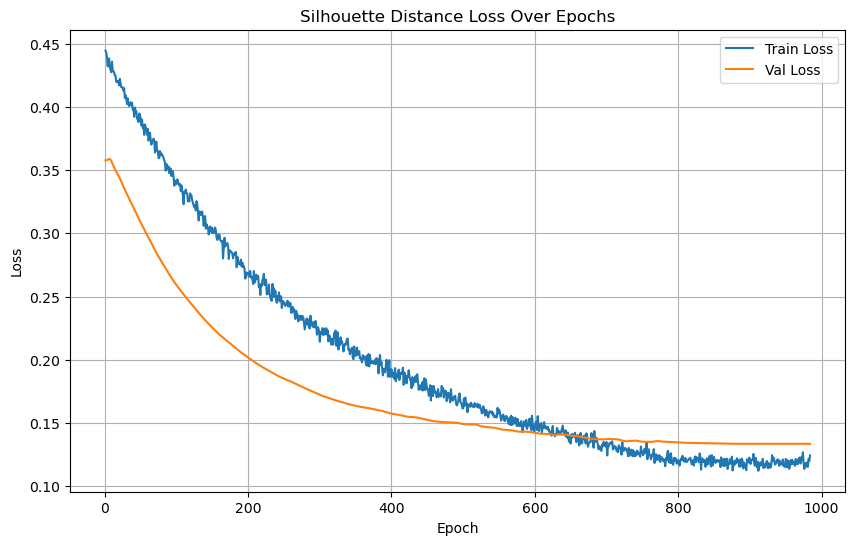

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2312], Loss: 0.0760


Test Batch [20/2312], Loss: 0.0644
Test Batch [30/2312], Loss: 0.5000
Test Batch [40/2312], Loss: 0.0334
Test Batch [50/2312], Loss: 0.5000
Test Batch [60/2312], Loss: 0.5000


Test Batch [70/2312], Loss: 0.5000


Test Batch [80/2312], Loss: 0.0844
Test Batch [90/2312], Loss: 0.5000
Test Batch [100/2312], Loss: 0.0611
Test Batch [110/2312], Loss: 0.5000
Test Batch [120/2312], Loss: 0.0628
Test Batch [130/2312], Loss: 0.5000


Test Batch [140/2312], Loss: 0.5000


Test Batch [150/2312], Loss: 0.5000
Test Batch [160/2312], Loss: 0.0899
Test Batch [170/2312], Loss: 0.5000
Test Batch [180/2312], Loss: 0.5000
Test Batch [190/2312], Loss: 0.5000


Test Batch [200/2312], Loss: 0.1066
Test Batch [210/2312], Loss: 0.5000


Test Batch [220/2312], Loss: 0.5000
Test Batch [230/2312], Loss: 0.0754
Test Batch [240/2312], Loss: 0.5000
Test Batch [250/2312], Loss: 0.0729
Test Batch [260/2312], Loss: 0.5000


Test Batch [270/2312], Loss: 0.5000


Test Batch [280/2312], Loss: 0.5000
Test Batch [290/2312], Loss: 0.0400
Test Batch [300/2312], Loss: 0.0802
Test Batch [310/2312], Loss: 0.5000
Test Batch [320/2312], Loss: 0.0769


Test Batch [330/2312], Loss: 0.5000
Test Batch [340/2312], Loss: 0.5000
Test Batch [350/2312], Loss: 0.0442


Test Batch [360/2312], Loss: 0.0939
Test Batch [370/2312], Loss: 0.0788
Test Batch [380/2312], Loss: 0.0695
Test Batch [390/2312], Loss: 0.0333
Test Batch [400/2312], Loss: 0.5000


Test Batch [410/2312], Loss: 0.0401
Test Batch [420/2312], Loss: 0.0608


Test Batch [430/2312], Loss: 0.0969
Test Batch [440/2312], Loss: 0.5000
Test Batch [450/2312], Loss: 0.0666
Test Batch [460/2312], Loss: 0.5000


Test Batch [470/2312], Loss: 0.0588


Test Batch [480/2312], Loss: 0.0280
Test Batch [490/2312], Loss: 0.5000
Test Batch [500/2312], Loss: 0.0750
Test Batch [510/2312], Loss: 0.5000
Test Batch [520/2312], Loss: 0.0858
Test Batch [530/2312], Loss: 0.5000


Test Batch [540/2312], Loss: 0.5000


Test Batch [550/2312], Loss: 0.0632
Test Batch [560/2312], Loss: 0.5000
Test Batch [570/2312], Loss: 0.5000
Test Batch [580/2312], Loss: 0.0310
Test Batch [590/2312], Loss: 0.0570


Test Batch [600/2312], Loss: 0.5000
Test Batch [610/2312], Loss: 0.5000
Test Batch [620/2312], Loss: 0.0402
Test Batch [630/2312], Loss: 0.0082


Test Batch [640/2312], Loss: 0.1016
Test Batch [650/2312], Loss: 0.5000
Test Batch [660/2312], Loss: 0.0770
Test Batch [670/2312], Loss: 0.0301
Test Batch [680/2312], Loss: 0.5000
Test Batch [690/2312], Loss: 0.5000
Test Batch [700/2312], Loss: 0.0760


Test Batch [710/2312], Loss: 0.0267
Test Batch [720/2312], Loss: 0.5000
Test Batch [730/2312], Loss: 0.0279
Test Batch [740/2312], Loss: 0.5000
Test Batch [750/2312], Loss: 0.0527
Test Batch [760/2312], Loss: 0.1129


Test Batch [770/2312], Loss: 0.5000
Test Batch [780/2312], Loss: 0.5000
Test Batch [790/2312], Loss: 0.0120
Test Batch [800/2312], Loss: 0.0875
Test Batch [810/2312], Loss: 0.5000
Test Batch [820/2312], Loss: 0.1066


Test Batch [830/2312], Loss: 0.5000
Test Batch [840/2312], Loss: 0.0431
Test Batch [850/2312], Loss: 0.1875
Test Batch [860/2312], Loss: 0.0302
Test Batch [870/2312], Loss: 0.1297
Test Batch [880/2312], Loss: 0.5000
Test Batch [890/2312], Loss: 0.5000
Test Batch [900/2312], Loss: 0.5000


Test Batch [910/2312], Loss: 0.5000
Test Batch [920/2312], Loss: 0.0399
Test Batch [930/2312], Loss: 0.0930
Test Batch [940/2312], Loss: 0.0570
Test Batch [950/2312], Loss: 0.5000
Test Batch [960/2312], Loss: 0.5000
Test Batch [970/2312], Loss: 0.5000


Test Batch [980/2312], Loss: 0.0456
Test Batch [990/2312], Loss: 0.0267
Test Batch [1000/2312], Loss: 0.0409
Test Batch [1010/2312], Loss: 0.0131
Test Batch [1020/2312], Loss: 0.0912
Test Batch [1030/2312], Loss: 0.5000


Test Batch [1040/2312], Loss: 0.0321
Test Batch [1050/2312], Loss: 0.0835
Test Batch [1060/2312], Loss: 0.0494
Test Batch [1070/2312], Loss: 0.0912
Test Batch [1080/2312], Loss: 0.0505


Test Batch [1090/2312], Loss: 0.1350
Test Batch [1100/2312], Loss: 0.0862
Test Batch [1110/2312], Loss: 0.1002
Test Batch [1120/2312], Loss: 0.0458
Test Batch [1130/2312], Loss: 0.0261


Test Batch [1140/2312], Loss: 0.5000
Test Batch [1150/2312], Loss: 0.0318
Test Batch [1160/2312], Loss: 0.0912
Test Batch [1170/2312], Loss: 0.0561


Test Batch [1180/2312], Loss: 0.1154
Test Batch [1190/2312], Loss: 0.0192
Test Batch [1200/2312], Loss: 0.1192
Test Batch [1210/2312], Loss: 0.0803


Test Batch [1220/2312], Loss: 0.1207
Test Batch [1230/2312], Loss: 0.1277
Test Batch [1240/2312], Loss: 0.0559
Test Batch [1250/2312], Loss: 0.5000
Test Batch [1260/2312], Loss: 0.0372


Test Batch [1270/2312], Loss: 0.0723
Test Batch [1280/2312], Loss: 0.2070
Test Batch [1290/2312], Loss: 0.5000
Test Batch [1300/2312], Loss: 0.0659


Test Batch [1310/2312], Loss: 0.0670
Test Batch [1320/2312], Loss: 0.0817
Test Batch [1330/2312], Loss: 0.0566
Test Batch [1340/2312], Loss: 0.0407


Test Batch [1350/2312], Loss: 0.0914
Test Batch [1360/2312], Loss: 0.1654
Test Batch [1370/2312], Loss: 0.1075
Test Batch [1380/2312], Loss: 0.0976


Test Batch [1390/2312], Loss: 0.0840
Test Batch [1400/2312], Loss: 0.0796
Test Batch [1410/2312], Loss: 0.0850


Test Batch [1420/2312], Loss: 0.1010
Test Batch [1430/2312], Loss: 0.5000
Test Batch [1440/2312], Loss: 0.0846
Test Batch [1450/2312], Loss: 0.1021


Test Batch [1460/2312], Loss: 0.1126
Test Batch [1470/2312], Loss: 0.0905
Test Batch [1480/2312], Loss: 0.0672
Test Batch [1490/2312], Loss: 0.0928
Test Batch [1500/2312], Loss: 0.0541


Test Batch [1510/2312], Loss: 0.5000
Test Batch [1520/2312], Loss: 0.5000
Test Batch [1530/2312], Loss: 0.0787
Test Batch [1540/2312], Loss: 0.0796


Test Batch [1550/2312], Loss: 0.0592
Test Batch [1560/2312], Loss: 0.0640
Test Batch [1570/2312], Loss: 0.1160
Test Batch [1580/2312], Loss: 0.0793


Test Batch [1590/2312], Loss: 0.0930
Test Batch [1600/2312], Loss: 0.0400
Test Batch [1610/2312], Loss: 0.0873
Test Batch [1620/2312], Loss: 0.1583


Test Batch [1630/2312], Loss: 0.0939
Test Batch [1640/2312], Loss: 0.5000
Test Batch [1650/2312], Loss: 0.0358
Test Batch [1660/2312], Loss: 0.1070


Test Batch [1670/2312], Loss: 0.0885
Test Batch [1680/2312], Loss: 0.1045
Test Batch [1690/2312], Loss: 0.1609
Test Batch [1700/2312], Loss: 0.0776


Test Batch [1710/2312], Loss: 0.1051
Test Batch [1720/2312], Loss: 0.0436
Test Batch [1730/2312], Loss: 0.0700
Test Batch [1740/2312], Loss: 0.5000
Test Batch [1750/2312], Loss: 0.0486
Test Batch [1760/2312], Loss: 0.0664
Test Batch [1770/2312], Loss: 0.0472
Test Batch [1780/2312], Loss: 0.0802


Test Batch [1790/2312], Loss: 0.0787
Test Batch [1800/2312], Loss: 0.0601
Test Batch [1810/2312], Loss: 0.0659
Test Batch [1820/2312], Loss: 0.1252
Test Batch [1830/2312], Loss: 0.0493
Test Batch [1840/2312], Loss: 0.1064


Test Batch [1850/2312], Loss: 0.0809
Test Batch [1860/2312], Loss: 0.0685
Test Batch [1870/2312], Loss: 0.0628
Test Batch [1880/2312], Loss: 0.0916
Test Batch [1890/2312], Loss: 0.0757


Test Batch [1900/2312], Loss: 0.0877
Test Batch [1910/2312], Loss: 0.1873
Test Batch [1920/2312], Loss: 0.1580


Test Batch [1930/2312], Loss: 0.1281
Test Batch [1940/2312], Loss: 0.1162
Test Batch [1950/2312], Loss: 0.0834
Test Batch [1960/2312], Loss: 0.1013
Test Batch [1970/2312], Loss: 0.0887
Test Batch [1980/2312], Loss: 0.0671
Test Batch [1990/2312], Loss: 0.0528


Test Batch [2000/2312], Loss: 0.0614
Test Batch [2010/2312], Loss: 0.0500
Test Batch [2020/2312], Loss: 0.0689
Test Batch [2030/2312], Loss: 0.0476
Test Batch [2040/2312], Loss: 0.0729


Test Batch [2050/2312], Loss: 0.1117
Test Batch [2060/2312], Loss: 0.1304
Test Batch [2070/2312], Loss: 0.0916
Test Batch [2080/2312], Loss: 0.5000
Test Batch [2090/2312], Loss: 0.0795
Test Batch [2100/2312], Loss: 0.1473
Test Batch [2110/2312], Loss: 0.0983


Test Batch [2120/2312], Loss: 0.1623
Test Batch [2130/2312], Loss: 0.0436
Test Batch [2140/2312], Loss: 0.0911
Test Batch [2150/2312], Loss: 0.1731
Test Batch [2160/2312], Loss: 0.0157
Test Batch [2170/2312], Loss: 0.5000
Test Batch [2180/2312], Loss: 0.1573


Test Batch [2190/2312], Loss: 0.5000
Test Batch [2200/2312], Loss: 0.5000
Test Batch [2210/2312], Loss: 0.5000
Test Batch [2220/2312], Loss: 0.0799
Test Batch [2230/2312], Loss: 0.0095
Test Batch [2240/2312], Loss: 0.0578


Test Batch [2250/2312], Loss: 0.0277
Test Batch [2260/2312], Loss: 0.5000
Test Batch [2270/2312], Loss: 0.0890
Test Batch [2280/2312], Loss: 0.5000
Test Batch [2290/2312], Loss: 0.0296
Test Batch [2300/2312], Loss: 0.0294


Test Batch [2310/2312], Loss: 0.5000

Test Loss: 0.2021


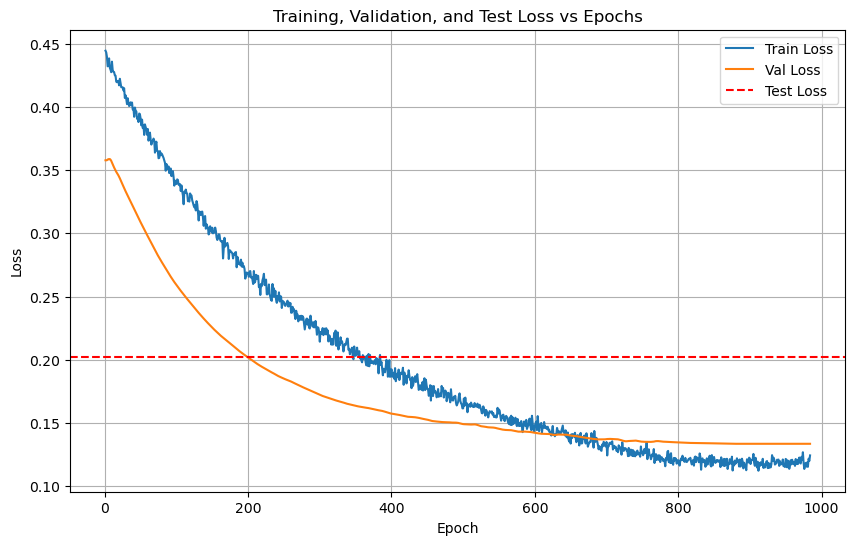

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2312 for test dataset.


  Processed batch 20/2312 for test dataset.


  Processed batch 30/2312 for test dataset.
  Processed batch 40/2312 for test dataset.
  Processed batch 50/2312 for test dataset.


  Processed batch 60/2312 for test dataset.


  Processed batch 70/2312 for test dataset.
  Processed batch 80/2312 for test dataset.
  Processed batch 90/2312 for test dataset.


  Processed batch 100/2312 for test dataset.


  Processed batch 110/2312 for test dataset.
  Processed batch 120/2312 for test dataset.


  Processed batch 130/2312 for test dataset.
  Processed batch 140/2312 for test dataset.


  Processed batch 150/2312 for test dataset.
  Processed batch 160/2312 for test dataset.


  Processed batch 170/2312 for test dataset.


  Processed batch 180/2312 for test dataset.
  Processed batch 190/2312 for test dataset.


  Processed batch 200/2312 for test dataset.


  Processed batch 210/2312 for test dataset.
  Processed batch 220/2312 for test dataset.


  Processed batch 230/2312 for test dataset.


  Processed batch 240/2312 for test dataset.
  Processed batch 250/2312 for test dataset.


  Processed batch 260/2312 for test dataset.


  Processed batch 270/2312 for test dataset.
  Processed batch 280/2312 for test dataset.
  Processed batch 290/2312 for test dataset.


  Processed batch 300/2312 for test dataset.


  Processed batch 310/2312 for test dataset.
  Processed batch 320/2312 for test dataset.
  Processed batch 330/2312 for test dataset.


  Processed batch 340/2312 for test dataset.
  Processed batch 350/2312 for test dataset.
  Processed batch 360/2312 for test dataset.
  Processed batch 370/2312 for test dataset.


  Processed batch 380/2312 for test dataset.
  Processed batch 390/2312 for test dataset.
  Processed batch 400/2312 for test dataset.
  Processed batch 410/2312 for test dataset.


  Processed batch 420/2312 for test dataset.
  Processed batch 430/2312 for test dataset.
  Processed batch 440/2312 for test dataset.


  Processed batch 450/2312 for test dataset.
  Processed batch 460/2312 for test dataset.
  Processed batch 470/2312 for test dataset.


  Processed batch 480/2312 for test dataset.
  Processed batch 490/2312 for test dataset.
  Processed batch 500/2312 for test dataset.


  Processed batch 510/2312 for test dataset.
  Processed batch 520/2312 for test dataset.
  Processed batch 530/2312 for test dataset.
  Processed batch 540/2312 for test dataset.


  Processed batch 550/2312 for test dataset.
  Processed batch 560/2312 for test dataset.
  Processed batch 570/2312 for test dataset.
  Processed batch 580/2312 for test dataset.


  Processed batch 590/2312 for test dataset.
  Processed batch 600/2312 for test dataset.
  Processed batch 610/2312 for test dataset.


  Processed batch 620/2312 for test dataset.
  Processed batch 630/2312 for test dataset.
  Processed batch 640/2312 for test dataset.
  Processed batch 650/2312 for test dataset.


  Processed batch 660/2312 for test dataset.
  Processed batch 670/2312 for test dataset.
  Processed batch 680/2312 for test dataset.
  Processed batch 690/2312 for test dataset.


  Processed batch 700/2312 for test dataset.
  Processed batch 710/2312 for test dataset.
  Processed batch 720/2312 for test dataset.


  Processed batch 730/2312 for test dataset.
  Processed batch 740/2312 for test dataset.
  Processed batch 750/2312 for test dataset.
  Processed batch 760/2312 for test dataset.


  Processed batch 770/2312 for test dataset.
  Processed batch 780/2312 for test dataset.
  Processed batch 790/2312 for test dataset.


  Processed batch 800/2312 for test dataset.
  Processed batch 810/2312 for test dataset.
  Processed batch 820/2312 for test dataset.


  Processed batch 830/2312 for test dataset.
  Processed batch 840/2312 for test dataset.
  Processed batch 850/2312 for test dataset.
  Processed batch 860/2312 for test dataset.


  Processed batch 870/2312 for test dataset.
  Processed batch 880/2312 for test dataset.
  Processed batch 890/2312 for test dataset.
  Processed batch 900/2312 for test dataset.


  Processed batch 910/2312 for test dataset.
  Processed batch 920/2312 for test dataset.
  Processed batch 930/2312 for test dataset.
  Processed batch 940/2312 for test dataset.


  Processed batch 950/2312 for test dataset.
  Processed batch 960/2312 for test dataset.
  Processed batch 970/2312 for test dataset.
  Processed batch 980/2312 for test dataset.


  Processed batch 990/2312 for test dataset.
  Processed batch 1000/2312 for test dataset.
  Processed batch 1010/2312 for test dataset.


  Processed batch 1020/2312 for test dataset.
  Processed batch 1030/2312 for test dataset.
  Processed batch 1040/2312 for test dataset.
  Processed batch 1050/2312 for test dataset.


  Processed batch 1060/2312 for test dataset.
  Processed batch 1070/2312 for test dataset.
  Processed batch 1080/2312 for test dataset.


  Processed batch 1090/2312 for test dataset.
  Processed batch 1100/2312 for test dataset.
  Processed batch 1110/2312 for test dataset.
  Processed batch 1120/2312 for test dataset.


  Processed batch 1130/2312 for test dataset.
  Processed batch 1140/2312 for test dataset.
  Processed batch 1150/2312 for test dataset.
  Processed batch 1160/2312 for test dataset.


  Processed batch 1170/2312 for test dataset.
  Processed batch 1180/2312 for test dataset.
  Processed batch 1190/2312 for test dataset.
  Processed batch 1200/2312 for test dataset.


  Processed batch 1210/2312 for test dataset.
  Processed batch 1220/2312 for test dataset.
  Processed batch 1230/2312 for test dataset.
  Processed batch 1240/2312 for test dataset.


  Processed batch 1250/2312 for test dataset.
  Processed batch 1260/2312 for test dataset.
  Processed batch 1270/2312 for test dataset.


  Processed batch 1280/2312 for test dataset.
  Processed batch 1290/2312 for test dataset.
  Processed batch 1300/2312 for test dataset.


  Processed batch 1310/2312 for test dataset.
  Processed batch 1320/2312 for test dataset.
  Processed batch 1330/2312 for test dataset.


  Processed batch 1340/2312 for test dataset.
  Processed batch 1350/2312 for test dataset.
  Processed batch 1360/2312 for test dataset.
  Processed batch 1370/2312 for test dataset.


  Processed batch 1380/2312 for test dataset.
  Processed batch 1390/2312 for test dataset.
  Processed batch 1400/2312 for test dataset.
  Processed batch 1410/2312 for test dataset.


  Processed batch 1420/2312 for test dataset.
  Processed batch 1430/2312 for test dataset.
  Processed batch 1440/2312 for test dataset.
  Processed batch 1450/2312 for test dataset.


  Processed batch 1460/2312 for test dataset.
  Processed batch 1470/2312 for test dataset.
  Processed batch 1480/2312 for test dataset.


  Processed batch 1490/2312 for test dataset.
  Processed batch 1500/2312 for test dataset.
  Processed batch 1510/2312 for test dataset.


  Processed batch 1520/2312 for test dataset.
  Processed batch 1530/2312 for test dataset.
  Processed batch 1540/2312 for test dataset.


  Processed batch 1550/2312 for test dataset.
  Processed batch 1560/2312 for test dataset.
  Processed batch 1570/2312 for test dataset.
  Processed batch 1580/2312 for test dataset.


  Processed batch 1590/2312 for test dataset.
  Processed batch 1600/2312 for test dataset.
  Processed batch 1610/2312 for test dataset.


  Processed batch 1620/2312 for test dataset.
  Processed batch 1630/2312 for test dataset.
  Processed batch 1640/2312 for test dataset.


  Processed batch 1650/2312 for test dataset.
  Processed batch 1660/2312 for test dataset.
  Processed batch 1670/2312 for test dataset.
  Processed batch 1680/2312 for test dataset.


  Processed batch 1690/2312 for test dataset.
  Processed batch 1700/2312 for test dataset.
  Processed batch 1710/2312 for test dataset.
  Processed batch 1720/2312 for test dataset.


  Processed batch 1730/2312 for test dataset.
  Processed batch 1740/2312 for test dataset.
  Processed batch 1750/2312 for test dataset.


  Processed batch 1760/2312 for test dataset.
  Processed batch 1770/2312 for test dataset.
  Processed batch 1780/2312 for test dataset.


  Processed batch 1790/2312 for test dataset.
  Processed batch 1800/2312 for test dataset.
  Processed batch 1810/2312 for test dataset.


  Processed batch 1820/2312 for test dataset.
  Processed batch 1830/2312 for test dataset.
  Processed batch 1840/2312 for test dataset.


  Processed batch 1850/2312 for test dataset.
  Processed batch 1860/2312 for test dataset.
  Processed batch 1870/2312 for test dataset.


  Processed batch 1880/2312 for test dataset.
  Processed batch 1890/2312 for test dataset.
  Processed batch 1900/2312 for test dataset.


  Processed batch 1910/2312 for test dataset.
  Processed batch 1920/2312 for test dataset.
  Processed batch 1930/2312 for test dataset.


  Processed batch 1940/2312 for test dataset.
  Processed batch 1950/2312 for test dataset.
  Processed batch 1960/2312 for test dataset.
  Processed batch 1970/2312 for test dataset.


  Processed batch 1980/2312 for test dataset.
  Processed batch 1990/2312 for test dataset.
  Processed batch 2000/2312 for test dataset.
  Processed batch 2010/2312 for test dataset.


  Processed batch 2020/2312 for test dataset.
  Processed batch 2030/2312 for test dataset.
  Processed batch 2040/2312 for test dataset.


  Processed batch 2050/2312 for test dataset.
  Processed batch 2060/2312 for test dataset.
  Processed batch 2070/2312 for test dataset.


  Processed batch 2080/2312 for test dataset.
  Processed batch 2090/2312 for test dataset.
  Processed batch 2100/2312 for test dataset.


  Processed batch 2110/2312 for test dataset.
  Processed batch 2120/2312 for test dataset.
  Processed batch 2130/2312 for test dataset.
  Processed batch 2140/2312 for test dataset.


  Processed batch 2150/2312 for test dataset.
  Processed batch 2160/2312 for test dataset.
  Processed batch 2170/2312 for test dataset.


  Processed batch 2180/2312 for test dataset.
  Processed batch 2190/2312 for test dataset.
  Processed batch 2200/2312 for test dataset.


  Processed batch 2210/2312 for test dataset.
  Processed batch 2220/2312 for test dataset.
  Processed batch 2230/2312 for test dataset.
  Processed batch 2240/2312 for test dataset.


  Processed batch 2250/2312 for test dataset.
  Processed batch 2260/2312 for test dataset.
  Processed batch 2270/2312 for test dataset.
  Processed batch 2280/2312 for test dataset.


  Processed batch 2290/2312 for test dataset.
  Processed batch 2300/2312 for test dataset.
  Processed batch 2310/2312 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 100.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


LOG: Evaluating on the test set...
Test Accuracy: 96.27%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     65946
           1       0.97      0.88      0.92      7573
           2       0.75      0.93      0.83      3065
           3       0.63      0.92      0.75      2660
           4       0.92      0.91      0.91      6559
           5       0.87      0.96      0.91      9223
           6       0.98      0.81      0.89      7262
           7       0.98      0.99      0.98     42801
           8       0.93      0.99      0.96      2838

    accuracy                           0.96    147927
   macro avg       0.89      0.93      0.91    147927
weighted avg       0.97      0.96      0.96    147927

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4261  |  Val Loss: 2.4052
Validation loss improved from inf to 2.4052.
[Epoch 2/1000] Train Loss: 2.3361  |  Val Loss: 2.3192
Validation loss improved from 2.4052 to 2.3192.
[Epoch 3/1000] Train Loss: 2.2519  |  Val Loss: 2.2370
Validation loss improved from 2.3192 to 2.2370.
[Epoch 4/1000] Train Loss: 2.1632  |  Val Loss: 2.1613
Validation loss improved from 2.2370 to 2.1613.
[Epoch 5/1000] Train Loss: 2.0945  |  Val Loss: 2.0892
Validation loss improved from 2.1613 to 2.0892.
[Epoch 6/1000] Train Loss: 2.0183  |  Val Loss: 2.0222
Validation loss improved from 2.0892 to 2.0222.
[Epoch 7/1000] Train Loss: 1.9487  |  Val Loss: 1.9585
Validation loss improved from 2.0222 to 1.9585.
[Epoch 8/1000] Train Loss: 1.8838  |  Val Loss: 1.8989
Validation loss improved from 1.9585 to 1.8989.
[Epoch 9/1000] Train Loss: 1.8280  |  Val Loss: 1.8460
Validation loss improved from 1.8989 to 1.8460.
[Epoch 10/1000] Train Loss: 1.7762  |  Val Loss: 1.7981
Validation loss impr

[Epoch 25/1000] Train Loss: 1.2471  |  Val Loss: 1.2981
Validation loss improved from 1.3239 to 1.2981.
[Epoch 26/1000] Train Loss: 1.2197  |  Val Loss: 1.2726
Validation loss improved from 1.2981 to 1.2726.
[Epoch 27/1000] Train Loss: 1.1930  |  Val Loss: 1.2475
Validation loss improved from 1.2726 to 1.2475.
[Epoch 28/1000] Train Loss: 1.1678  |  Val Loss: 1.2228
Validation loss improved from 1.2475 to 1.2228.
[Epoch 29/1000] Train Loss: 1.1425  |  Val Loss: 1.1988
Validation loss improved from 1.2228 to 1.1988.
[Epoch 30/1000] Train Loss: 1.1179  |  Val Loss: 1.1755
Validation loss improved from 1.1988 to 1.1755.
[Epoch 31/1000] Train Loss: 1.0945  |  Val Loss: 1.1526
Validation loss improved from 1.1755 to 1.1526.
[Epoch 32/1000] Train Loss: 1.0712  |  Val Loss: 1.1304
Validation loss improved from 1.1526 to 1.1304.


[Epoch 33/1000] Train Loss: 1.0488  |  Val Loss: 1.1086
Validation loss improved from 1.1304 to 1.1086.
[Epoch 34/1000] Train Loss: 1.0267  |  Val Loss: 1.0874
Validation loss improved from 1.1086 to 1.0874.
[Epoch 35/1000] Train Loss: 1.0053  |  Val Loss: 1.0668
Validation loss improved from 1.0874 to 1.0668.
[Epoch 36/1000] Train Loss: 0.9843  |  Val Loss: 1.0465
Validation loss improved from 1.0668 to 1.0465.
[Epoch 37/1000] Train Loss: 0.9635  |  Val Loss: 1.0261
Validation loss improved from 1.0465 to 1.0261.
[Epoch 38/1000] Train Loss: 0.9423  |  Val Loss: 1.0051
Validation loss improved from 1.0261 to 1.0051.
[Epoch 39/1000] Train Loss: 0.9205  |  Val Loss: 0.9837
Validation loss improved from 1.0051 to 0.9837.
[Epoch 40/1000] Train Loss: 0.8987  |  Val Loss: 0.9625
Validation loss improved from 0.9837 to 0.9625.
[Epoch 41/1000] Train Loss: 0.8770  |  Val Loss: 0.9412
Validation loss improved from 0.9625 to 0.9412.
[Epoch 42/1000] Train Loss: 0.8558  |  Val Loss: 0.9204
Validati

[Epoch 58/1000] Train Loss: 0.5964  |  Val Loss: 0.6718
Validation loss improved from 0.6843 to 0.6718.
[Epoch 59/1000] Train Loss: 0.5839  |  Val Loss: 0.6597
Validation loss improved from 0.6718 to 0.6597.
[Epoch 60/1000] Train Loss: 0.5720  |  Val Loss: 0.6478
Validation loss improved from 0.6597 to 0.6478.
[Epoch 61/1000] Train Loss: 0.5598  |  Val Loss: 0.6362
Validation loss improved from 0.6478 to 0.6362.
[Epoch 62/1000] Train Loss: 0.5482  |  Val Loss: 0.6250
Validation loss improved from 0.6362 to 0.6250.
[Epoch 63/1000] Train Loss: 0.5368  |  Val Loss: 0.6139
Validation loss improved from 0.6250 to 0.6139.
[Epoch 64/1000] Train Loss: 0.5257  |  Val Loss: 0.6029
Validation loss improved from 0.6139 to 0.6029.
[Epoch 65/1000] Train Loss: 0.5149  |  Val Loss: 0.5922
Validation loss improved from 0.6029 to 0.5922.
[Epoch 66/1000] Train Loss: 0.5041  |  Val Loss: 0.5817
Validation loss improved from 0.5922 to 0.5817.
[Epoch 67/1000] Train Loss: 0.4935  |  Val Loss: 0.5715
Validati

[Epoch 68/1000] Train Loss: 0.4831  |  Val Loss: 0.5615
Validation loss improved from 0.5715 to 0.5615.
[Epoch 69/1000] Train Loss: 0.4733  |  Val Loss: 0.5516
Validation loss improved from 0.5615 to 0.5516.
[Epoch 70/1000] Train Loss: 0.4635  |  Val Loss: 0.5418
Validation loss improved from 0.5516 to 0.5418.
[Epoch 71/1000] Train Loss: 0.4538  |  Val Loss: 0.5321
Validation loss improved from 0.5418 to 0.5321.
[Epoch 72/1000] Train Loss: 0.4441  |  Val Loss: 0.5228
Validation loss improved from 0.5321 to 0.5228.
[Epoch 73/1000] Train Loss: 0.4350  |  Val Loss: 0.5136
Validation loss improved from 0.5228 to 0.5136.
[Epoch 74/1000] Train Loss: 0.4259  |  Val Loss: 0.5046
Validation loss improved from 0.5136 to 0.5046.
[Epoch 75/1000] Train Loss: 0.4164  |  Val Loss: 0.4959
Validation loss improved from 0.5046 to 0.4959.
[Epoch 76/1000] Train Loss: 0.4078  |  Val Loss: 0.4872
Validation loss improved from 0.4959 to 0.4872.
[Epoch 77/1000] Train Loss: 0.3991  |  Val Loss: 0.4789
Validati

[Epoch 90/1000] Train Loss: 0.3026  |  Val Loss: 0.3863
Validation loss improved from 0.3926 to 0.3863.
[Epoch 91/1000] Train Loss: 0.2961  |  Val Loss: 0.3802
Validation loss improved from 0.3863 to 0.3802.
[Epoch 92/1000] Train Loss: 0.2897  |  Val Loss: 0.3743
Validation loss improved from 0.3802 to 0.3743.
[Epoch 93/1000] Train Loss: 0.2837  |  Val Loss: 0.3685
Validation loss improved from 0.3743 to 0.3685.
[Epoch 94/1000] Train Loss: 0.2778  |  Val Loss: 0.3629
Validation loss improved from 0.3685 to 0.3629.
[Epoch 95/1000] Train Loss: 0.2720  |  Val Loss: 0.3574
Validation loss improved from 0.3629 to 0.3574.
[Epoch 96/1000] Train Loss: 0.2663  |  Val Loss: 0.3522
Validation loss improved from 0.3574 to 0.3522.
[Epoch 97/1000] Train Loss: 0.2607  |  Val Loss: 0.3472
Validation loss improved from 0.3522 to 0.3472.
[Epoch 98/1000] Train Loss: 0.2558  |  Val Loss: 0.3424
Validation loss improved from 0.3472 to 0.3424.


[Epoch 99/1000] Train Loss: 0.2504  |  Val Loss: 0.3374
Validation loss improved from 0.3424 to 0.3374.
[Epoch 100/1000] Train Loss: 0.2456  |  Val Loss: 0.3327
Validation loss improved from 0.3374 to 0.3327.
[Epoch 101/1000] Train Loss: 0.2407  |  Val Loss: 0.3282
Validation loss improved from 0.3327 to 0.3282.
[Epoch 102/1000] Train Loss: 0.2358  |  Val Loss: 0.3237
Validation loss improved from 0.3282 to 0.3237.
[Epoch 103/1000] Train Loss: 0.2314  |  Val Loss: 0.3195
Validation loss improved from 0.3237 to 0.3195.
[Epoch 104/1000] Train Loss: 0.2270  |  Val Loss: 0.3155
Validation loss improved from 0.3195 to 0.3155.
[Epoch 105/1000] Train Loss: 0.2226  |  Val Loss: 0.3116
Validation loss improved from 0.3155 to 0.3116.
[Epoch 106/1000] Train Loss: 0.2184  |  Val Loss: 0.3080
Validation loss improved from 0.3116 to 0.3080.
[Epoch 107/1000] Train Loss: 0.2143  |  Val Loss: 0.3043
Validation loss improved from 0.3080 to 0.3043.
[Epoch 108/1000] Train Loss: 0.2103  |  Val Loss: 0.3006

[Epoch 118/1000] Train Loss: 0.1754  |  Val Loss: 0.2706
Validation loss improved from 0.2732 to 0.2706.
[Epoch 119/1000] Train Loss: 0.1726  |  Val Loss: 0.2682
Validation loss improved from 0.2706 to 0.2682.
[Epoch 120/1000] Train Loss: 0.1695  |  Val Loss: 0.2657
Validation loss improved from 0.2682 to 0.2657.
[Epoch 121/1000] Train Loss: 0.1666  |  Val Loss: 0.2634
Validation loss improved from 0.2657 to 0.2634.
[Epoch 122/1000] Train Loss: 0.1639  |  Val Loss: 0.2612
Validation loss improved from 0.2634 to 0.2612.
[Epoch 123/1000] Train Loss: 0.1612  |  Val Loss: 0.2592
Validation loss improved from 0.2612 to 0.2592.
[Epoch 124/1000] Train Loss: 0.1585  |  Val Loss: 0.2570
Validation loss improved from 0.2592 to 0.2570.
[Epoch 125/1000] Train Loss: 0.1560  |  Val Loss: 0.2551
Validation loss improved from 0.2570 to 0.2551.
[Epoch 126/1000] Train Loss: 0.1533  |  Val Loss: 0.2531
Validation loss improved from 0.2551 to 0.2531.
[Epoch 127/1000] Train Loss: 0.1509  |  Val Loss: 0.251

[Epoch 128/1000] Train Loss: 0.1486  |  Val Loss: 0.2491
Validation loss improved from 0.2510 to 0.2491.
[Epoch 129/1000] Train Loss: 0.1463  |  Val Loss: 0.2475
Validation loss improved from 0.2491 to 0.2475.
[Epoch 130/1000] Train Loss: 0.1440  |  Val Loss: 0.2461
Validation loss improved from 0.2475 to 0.2461.
[Epoch 131/1000] Train Loss: 0.1418  |  Val Loss: 0.2446
Validation loss improved from 0.2461 to 0.2446.
[Epoch 132/1000] Train Loss: 0.1396  |  Val Loss: 0.2431
Validation loss improved from 0.2446 to 0.2431.
[Epoch 133/1000] Train Loss: 0.1375  |  Val Loss: 0.2417
Validation loss improved from 0.2431 to 0.2417.
[Epoch 134/1000] Train Loss: 0.1354  |  Val Loss: 0.2403
Validation loss improved from 0.2417 to 0.2403.
[Epoch 135/1000] Train Loss: 0.1335  |  Val Loss: 0.2391
Validation loss improved from 0.2403 to 0.2391.
[Epoch 136/1000] Train Loss: 0.1315  |  Val Loss: 0.2379
Validation loss improved from 0.2391 to 0.2379.
[Epoch 137/1000] Train Loss: 0.1297  |  Val Loss: 0.236

[Epoch 146/1000] Train Loss: 0.1144  |  Val Loss: 0.2285
Validation loss improved from 0.2292 to 0.2285.
[Epoch 147/1000] Train Loss: 0.1130  |  Val Loss: 0.2278
Validation loss improved from 0.2285 to 0.2278.
[Epoch 148/1000] Train Loss: 0.1116  |  Val Loss: 0.2270
Validation loss improved from 0.2278 to 0.2270.
[Epoch 149/1000] Train Loss: 0.1101  |  Val Loss: 0.2263
Validation loss improved from 0.2270 to 0.2263.
[Epoch 150/1000] Train Loss: 0.1087  |  Val Loss: 0.2256
Validation loss improved from 0.2263 to 0.2256.
[Epoch 151/1000] Train Loss: 0.1074  |  Val Loss: 0.2251
Validation loss improved from 0.2256 to 0.2251.
[Epoch 152/1000] Train Loss: 0.1061  |  Val Loss: 0.2246
Validation loss improved from 0.2251 to 0.2246.
[Epoch 153/1000] Train Loss: 0.1047  |  Val Loss: 0.2241
Validation loss improved from 0.2246 to 0.2241.
[Epoch 154/1000] Train Loss: 0.1035  |  Val Loss: 0.2234
Validation loss improved from 0.2241 to 0.2234.
[Epoch 155/1000] Train Loss: 0.1023  |  Val Loss: 0.222

[Epoch 162/1000] Train Loss: 0.0944  |  Val Loss: 0.2194
Validation loss improved from 0.2198 to 0.2194.
[Epoch 163/1000] Train Loss: 0.0934  |  Val Loss: 0.2188
Validation loss improved from 0.2194 to 0.2188.
[Epoch 164/1000] Train Loss: 0.0923  |  Val Loss: 0.2186
Validation loss improved from 0.2188 to 0.2186.
[Epoch 165/1000] Train Loss: 0.0913  |  Val Loss: 0.2181
Validation loss improved from 0.2186 to 0.2181.
[Epoch 166/1000] Train Loss: 0.0904  |  Val Loss: 0.2178
Validation loss improved from 0.2181 to 0.2178.
[Epoch 167/1000] Train Loss: 0.0894  |  Val Loss: 0.2171
Validation loss improved from 0.2178 to 0.2171.
[Epoch 168/1000] Train Loss: 0.0885  |  Val Loss: 0.2165
Validation loss improved from 0.2171 to 0.2165.
[Epoch 169/1000] Train Loss: 0.0876  |  Val Loss: 0.2163
Validation loss improved from 0.2165 to 0.2163.
[Epoch 170/1000] Train Loss: 0.0867  |  Val Loss: 0.2159
Validation loss improved from 0.2163 to 0.2159.
[Epoch 171/1000] Train Loss: 0.0859  |  Val Loss: 0.215

[Epoch 179/1000] Train Loss: 0.0795  |  Val Loss: 0.2136
Validation loss improved from 0.2140 to 0.2136.
[Epoch 180/1000] Train Loss: 0.0787  |  Val Loss: 0.2134
Validation loss improved from 0.2136 to 0.2134.
[Epoch 181/1000] Train Loss: 0.0780  |  Val Loss: 0.2133
Validation loss improved from 0.2134 to 0.2133.
[Epoch 182/1000] Train Loss: 0.0773  |  Val Loss: 0.2131
Validation loss improved from 0.2133 to 0.2131.
[Epoch 183/1000] Train Loss: 0.0766  |  Val Loss: 0.2129
Validation loss improved from 0.2131 to 0.2129.
[Epoch 184/1000] Train Loss: 0.0759  |  Val Loss: 0.2130
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 185/1000] Train Loss: 0.0753  |  Val Loss: 0.2129
Validation loss improved from 0.2129 to 0.2129.
[Epoch 186/1000] Train Loss: 0.0746  |  Val Loss: 0.2127
Validation loss improved from 0.2129 to 0.2127.
[Epoch 187/1000] Train Loss: 0.0740  |  Val Loss: 0.2127
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 188/1000] Train Loss: 0.0734  |  Val

[Epoch 197/1000] Train Loss: 0.0683  |  Val Loss: 0.2121
Validation loss improved from 0.2121 to 0.2121.
[Epoch 198/1000] Train Loss: 0.0677  |  Val Loss: 0.2121
Validation loss improved from 0.2121 to 0.2121.
[Epoch 199/1000] Train Loss: 0.0672  |  Val Loss: 0.2120
Validation loss improved from 0.2121 to 0.2120.
[Epoch 200/1000] Train Loss: 0.0667  |  Val Loss: 0.2119
Validation loss improved from 0.2120 to 0.2119.
[Epoch 201/1000] Train Loss: 0.0662  |  Val Loss: 0.2118
Validation loss improved from 0.2119 to 0.2118.
[Epoch 202/1000] Train Loss: 0.0658  |  Val Loss: 0.2119
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 203/1000] Train Loss: 0.0653  |  Val Loss: 0.2118
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 204/1000] Train Loss: 0.0648  |  Val Loss: 0.2118
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 205/1000] Train Loss: 0.0643  |  Val Loss: 0.2118
Validation loss improved from 0.2118 to 0.2118.
[Epoch 206/1000] Train Loss: 0.0640  

[Epoch 212/1000] Train Loss: 0.0614  |  Val Loss: 0.2116
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 213/1000] Train Loss: 0.0610  |  Val Loss: 0.2115
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 214/1000] Train Loss: 0.0606  |  Val Loss: 0.2117
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 215/1000] Train Loss: 0.0603  |  Val Loss: 0.2115
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 216/1000] Train Loss: 0.0598  |  Val Loss: 0.2114
Validation loss improved from 0.2115 to 0.2114.
[Epoch 217/1000] Train Loss: 0.0595  |  Val Loss: 0.2113
Validation loss improved from 0.2114 to 0.2113.
[Epoch 218/1000] Train Loss: 0.0591  |  Val Loss: 0.2115
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 219/1000] Train Loss: 0.0588  |  Val Loss: 0.2114
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 220/1000] Train Loss: 0.0584  |  Val Loss: 0.2115
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 221/10

[Epoch 232/1000] Train Loss: 0.0545  |  Val Loss: 0.2112
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 233/1000] Train Loss: 0.0542  |  Val Loss: 0.2114
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 234/1000] Train Loss: 0.0539  |  Val Loss: 0.2116
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 235/1000] Train Loss: 0.0537  |  Val Loss: 0.2120
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 236/1000] Train Loss: 0.0533  |  Val Loss: 0.2124
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 237/1000] Train Loss: 0.0531  |  Val Loss: 0.2124
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 238/1000] Train Loss: 0.0527  |  Val Loss: 0.2125
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 239/1000] Train Loss: 0.0525  |  Val Loss: 0.2126
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 240/1000] Train Loss: 0.0522  |  Val Loss: 0.2128
!! Validation loss did NOT improve !! Patience: 15

[Epoch 241/1000] Train Loss: 0.0519  |  Val Loss: 0.2129
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 242/1000] Train Loss: 0.0518  |  Val Loss: 0.2132
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 243/1000] Train Loss: 0.0514  |  Val Loss: 0.2134
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 244/1000] Train Loss: 0.0512  |  Val Loss: 0.2135
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 245/1000] Train Loss: 0.0509  |  Val Loss: 0.2135
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 246/1000] Train Loss: 0.0507  |  Val Loss: 0.2136
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 247/1000] Train Loss: 0.0505  |  Val Loss: 0.2139
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 248/1000] Train Loss: 0.0502  |  Val Loss: 0.2140
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 249/1000] Train Loss: 0.0499  |  Val Loss: 0.2143
!! Validation loss did NOT improve !! Patience:

[Epoch 262/1000] Train Loss: 0.0470  |  Val Loss: 0.2155
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 263/1000] Train Loss: 0.0468  |  Val Loss: 0.2158
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 264/1000] Train Loss: 0.0466  |  Val Loss: 0.2161
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 265/1000] Train Loss: 0.0464  |  Val Loss: 0.2163
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 266/1000] Train Loss: 0.0462  |  Val Loss: 0.2166
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 267/1000] Train Loss: 0.0460  |  Val Loss: 0.2167
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 268/1000] Train Loss: 0.0459  |  Val Loss: 0.2171
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 269/1000] Train Loss: 0.0457  |  Val Loss: 0.2171
!! Validation loss did NOT improve !! Patience: 44/100


[Epoch 270/1000] Train Loss: 0.0455  |  Val Loss: 0.2174
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 271/1000] Train Loss: 0.0453  |  Val Loss: 0.2174
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 272/1000] Train Loss: 0.0451  |  Val Loss: 0.2173
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 273/1000] Train Loss: 0.0449  |  Val Loss: 0.2174
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 274/1000] Train Loss: 0.0448  |  Val Loss: 0.2176
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 275/1000] Train Loss: 0.0446  |  Val Loss: 0.2175
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 276/1000] Train Loss: 0.0444  |  Val Loss: 0.2176
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 277/1000] Train Loss: 0.0442  |  Val Loss: 0.2176
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 278/1000] Train Loss: 0.0441  |  Val Loss: 0.2177
!! Validation loss did NOT improve !! Patience:

[Epoch 291/1000] Train Loss: 0.0421  |  Val Loss: 0.2197
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 292/1000] Train Loss: 0.0420  |  Val Loss: 0.2196
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 293/1000] Train Loss: 0.0418  |  Val Loss: 0.2197
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 294/1000] Train Loss: 0.0417  |  Val Loss: 0.2197
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 295/1000] Train Loss: 0.0416  |  Val Loss: 0.2200
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 296/1000] Train Loss: 0.0414  |  Val Loss: 0.2201
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 297/1000] Train Loss: 0.0413  |  Val Loss: 0.2204
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 298/1000] Train Loss: 0.0411  |  Val Loss: 0.2206
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 299/1000] Train Loss: 0.0410  |  Val Loss: 0.2205
!! Validation loss did NOT improve !! Patience:

[Epoch 302/1000] Train Loss: 0.0407  |  Val Loss: 0.2207
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 303/1000] Train Loss: 0.0405  |  Val Loss: 0.2207
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 304/1000] Train Loss: 0.0404  |  Val Loss: 0.2208
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 305/1000] Train Loss: 0.0403  |  Val Loss: 0.2211
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 306/1000] Train Loss: 0.0401  |  Val Loss: 0.2213
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 307/1000] Train Loss: 0.0400  |  Val Loss: 0.2215
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 308/1000] Train Loss: 0.0399  |  Val Loss: 0.2215
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 309/1000] Train Loss: 0.0398  |  Val Loss: 0.2215
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 310/1000] Train Loss: 0.0397  |  Val Loss: 0.2218
!! Validation loss did NOT improve !! Patience:

[Epoch 321/1000] Train Loss: 0.0385  |  Val Loss: 0.2239
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 322/1000] Train Loss: 0.0384  |  Val Loss: 0.2239
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 323/1000] Train Loss: 0.0382  |  Val Loss: 0.2239
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 324/1000] Train Loss: 0.0383  |  Val Loss: 0.2236
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 325/1000] Train Loss: 0.0381  |  Val Loss: 0.2236
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 325 !!
No improvement for 100 epochs.


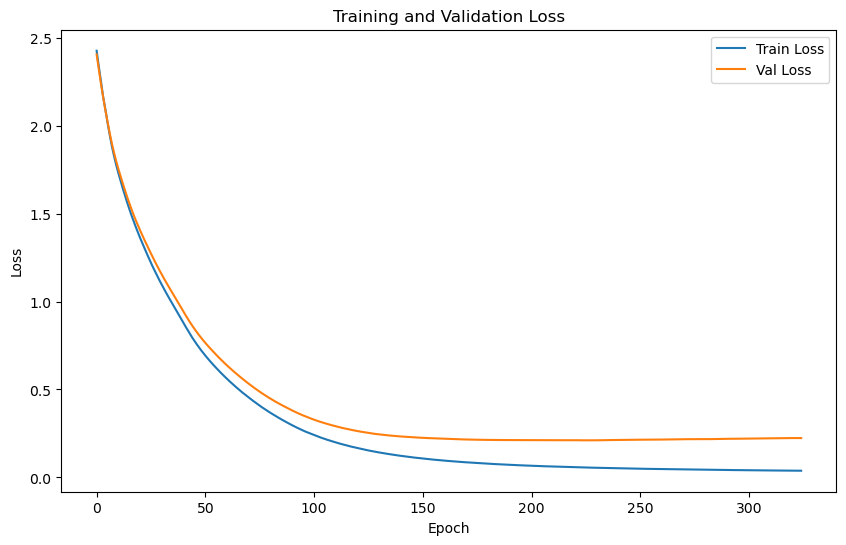

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.1575 | Test Accuracy: 95.77%


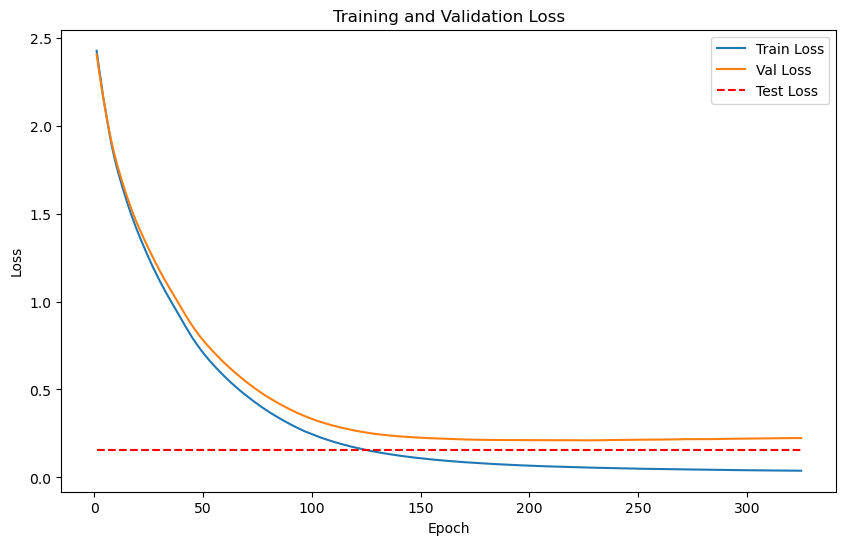

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


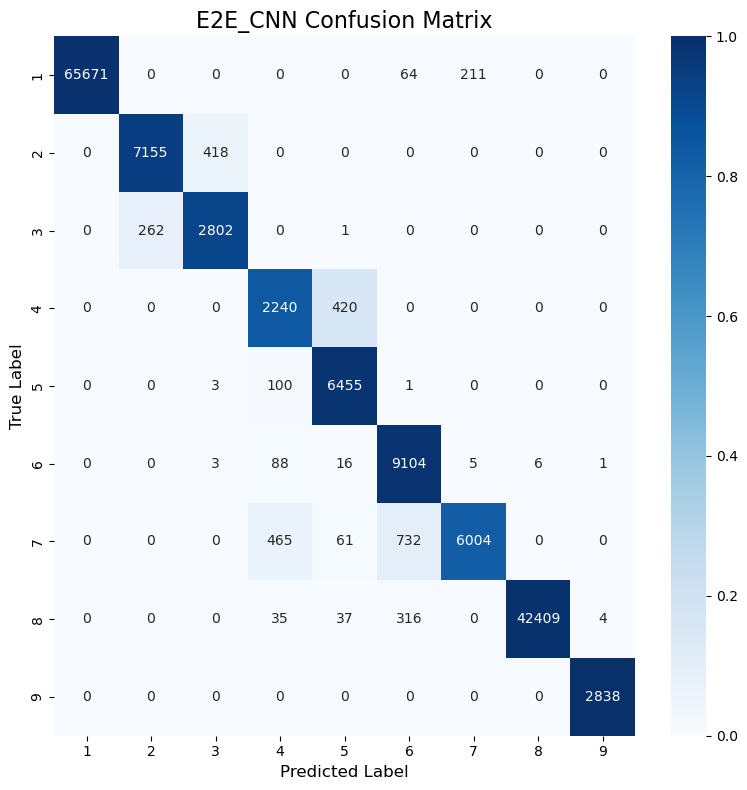

Classification Accuracy: 97.80%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


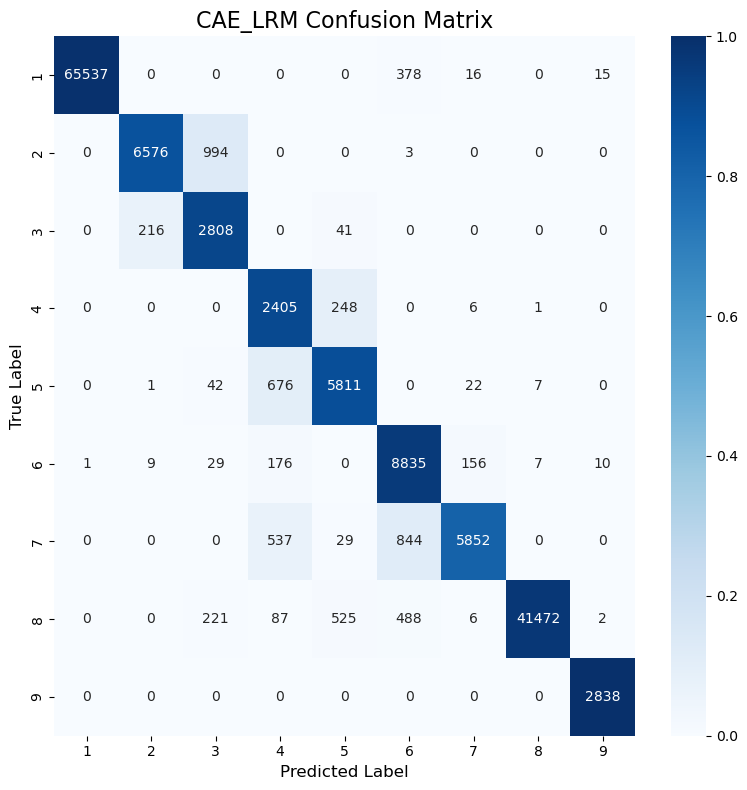

Classification Accuracy: 96.08%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


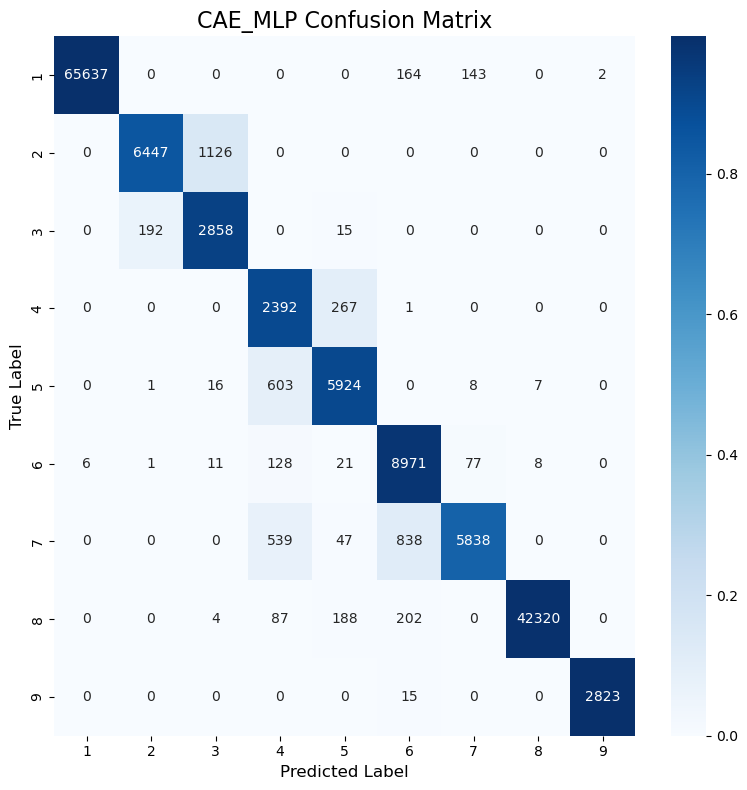

Classification Accuracy: 96.81%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


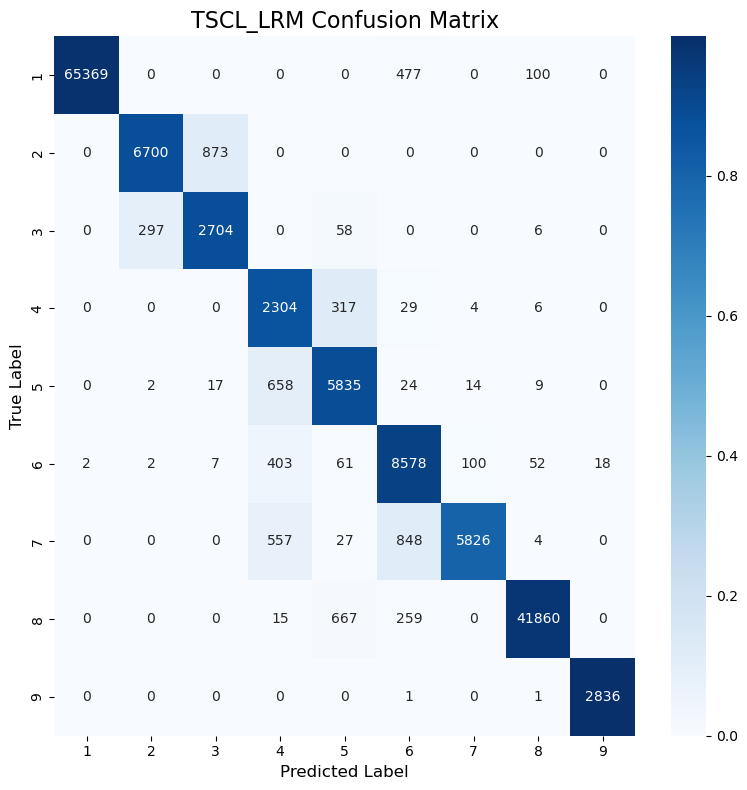

Classification Accuracy: 96.00%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


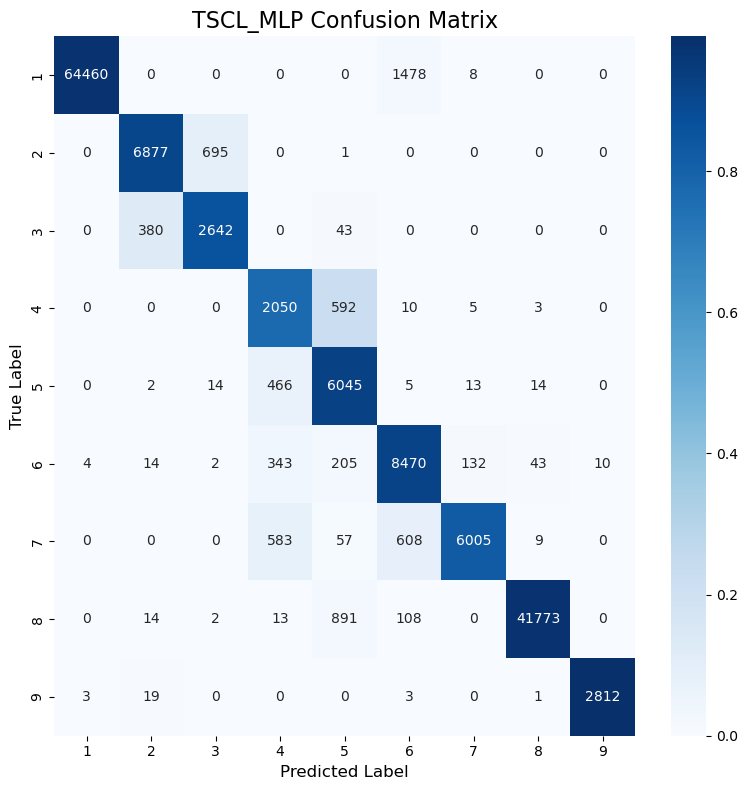

Classification Accuracy: 95.41%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


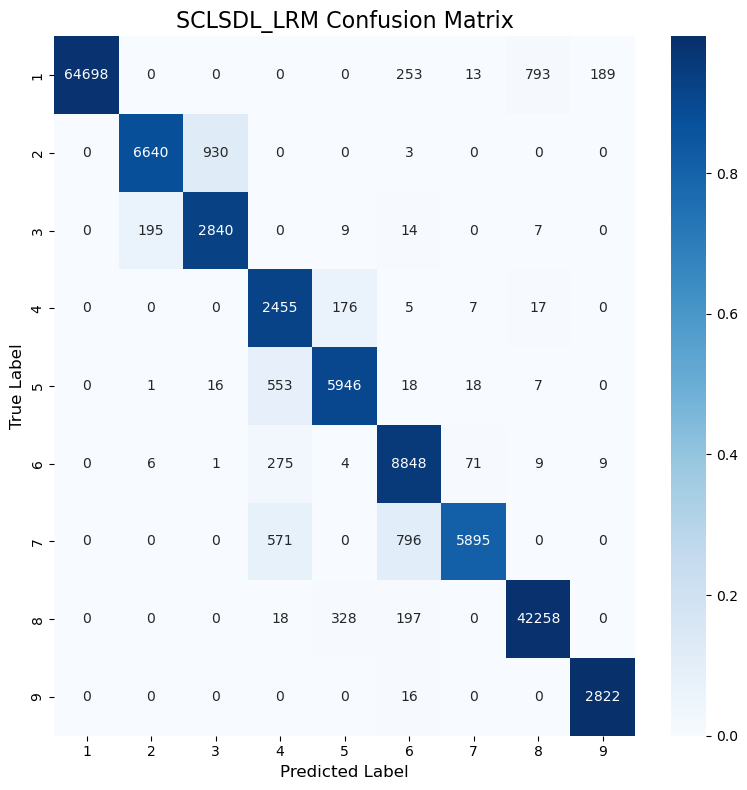

Classification Accuracy: 96.27%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


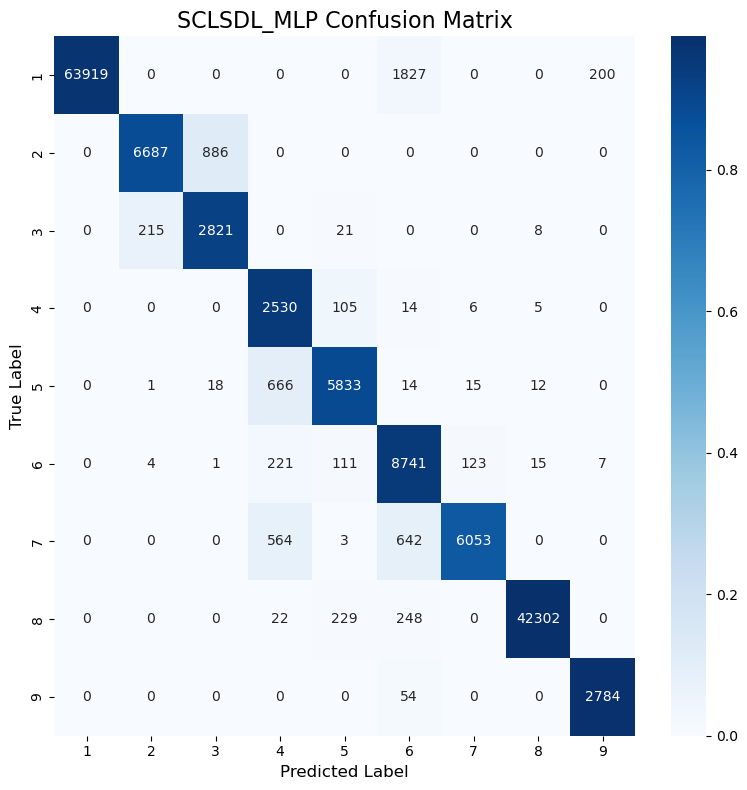

Classification Accuracy: 95.77%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          97.80
1    LRM (CAE)          96.08
2    MLP (CAE)          96.81
3     TSCL LRM          96.00
4     TSCL MLP          95.41
5  SCL_SDL LRM          96.27
6  SCL_SDL MLP          95.77

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          97.80
2    MLP (CAE)          96.81
5  SCL_SDL LRM          96.27
1    LRM (CAE)          96.08
3     TSCL LRM          96.00
6  SCL_SDL MLP          95.77
4     TSCL MLP          95.41
